# Configuration

In [ ]:
!pip install gensim --upgrade
!pip install emoji --upgrade
!pip install -q kaggle
!pip install pyLDAvis
!pip3 install --upgrade -e git+https://github.com/twintproject/twint.git@origin/master#egg=twint
!pip install contractions
!pip install vaderSentiment
!pip install NRCLex --upgrade
!pip install yellowbrick --upgrade

  Using cached numpy-1.21.2-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.2 which is incompatible.
tensorflow 2.5.0 requires numpy~=1.19.2, but you have numpy 1.21.2 which is incompatible.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.2 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Obtaining twint from git+https://github.com/twintproject/twint.git@origin/master#egg=twint
  Updating ./src/twint clone (to revision origin/master)
  Running command git fetch -q --tags
  Running command git reset --hard -q origin/master
  Attempting uninstall: twint
    Found existing installation: twint 2.1.21
    Can't uninstall 'twint'. No files were found to uninstall.
  Running setup.py develop for twint
  Using cached numpy-1.19.5-cp37-cp37m-manylinux2010_x86_64.whl (14.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.2
    Uninstalling numpy-1.21.2:
      Successfully uninstalled numpy-1.21.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.3.1 requires numpy>=1.20.0, but you have numpy 1.19.5 which is incompatible.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.2 whic

In [ ]:
##########
# IMPORT #
##########

# Utility
from collections import Counter
import emoji
import itertools
import json
import logging
import numpy as np
import os
import pandas as pd
import pickle
import random
import re
import string
import time
from string import punctuation


# Matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

# Nltk
import nltk
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
download('stopwords')
download('wordnet')
download('punkt')
download('averaged_perceptron_tagger')
STOPWORDS = stopwords.words("english") + ['covid', 'co', 'coronavirus', 'corona', 'virus', 'new','case', 'cases','coronavirusupdates', 'ha', 'amp']

# Sk-learn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import adjusted_rand_score, cohen_kappa_score
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Scipy 
import scipy.stats as st
from scipy.spatial.distance import cdist

# Gensim
import gensim
from gensim import corpora
from gensim import models

# Yellowbrick
from yellowbrick.cluster import KElbowVisualizer, InterclusterDistance

# Word Cloud
from wordcloud import WordCloud

# Pre-processing
from functools import reduce
from bs4 import BeautifulSoup 

# Contraction
import contractions

# VADER
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# NRCLex
from nrclex import NRCLex

# Chi square 
from scipy.stats import chi2
from scipy.stats import chi2_contingency

#####################
#  REPRODUCIBILITY  #
#####################

# Seed value
SEED_VALUE= 42

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(SEED_VALUE)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(SEED_VALUE)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(SEED_VALUE)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Download Data


In [ ]:
USER_ID = 'your_user_id'
USER_SECRET = 'your_user_secret'
KAGGLE_CONFIG_DIR = os.path.join(os.path.expandvars('$HOME'), '.kaggle')

# Create the required json file
os.makedirs(KAGGLE_CONFIG_DIR, exist_ok = True)
with open(os.path.join(KAGGLE_CONFIG_DIR, 'kaggle.json'), 'w') as f:
    json.dump({'username': USER_ID, 'key': USER_SECRET}, f)


In [ ]:
!chmod 600 {KAGGLE_CONFIG_DIR}/kaggle.json
!kaggle datasets download -d gpreda/covid19-tweets
!mkdir data
!unzip covid19-tweets.zip -d data

covid19-tweets.zip: Skipping, found more recently modified local copy (use --force to force download)
mkdir: cannot create directory ‘data’: File exists
Archive:  covid19-tweets.zip
replace data/covid19_tweets.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


We read data from the unzipped csv file by relying on `pandas` library:

In [ ]:
dataset_filename = os.listdir("data")[0]
dataset_path = os.path.join("data", dataset_filename)
df = pd.read_csv(dataset_path)

In [ ]:
df.head()

user_name         user_location  ...               source is_retweet
0           ᏉᎥ☻լꂅϮ            astroworld  ...   Twitter for iPhone      False
1    Tom Basile 🇺🇸          New York, NY  ...  Twitter for Android      False
2  Time4fisticuffs      Pewee Valley, KY  ...  Twitter for Android      False
3      ethel mertz  Stuck in the Middle   ...   Twitter for iPhone      False
4         DIPR-J&K     Jammu and Kashmir  ...  Twitter for Android      False

[5 rows x 13 columns]

# Exploratory Data Analysis

Our dataset contains 13 features:

 1.   `user_name [str]`    
 The name of the user, as they’ve defined it. Not necessarily a person’s name. Typically capped at 50 characters, but subject to change.           
 1.  ` user_location [str]`  
  *Nullable*. The user-defined location for this account’s profile. Not necessarily a location, nor machine-parseable. This field will occasionally be fuzzily interpreted by the Search service.     
 2.   `user_description [str]`  	
*Nullable*. The user-defined UTF-8 string describing their account.  
 3.   `user_created [str]`  
 The UTC datetime that the user account was created on Twitter.     
 4.   `user_followers [int]`  
 The number of followers this account currently has.     
 5.   `user_friends [int]`   
 The number of users this account is following (AKA their “followings”).     
 6.   `user_favourites [str]`  
 The number of Tweets this user has liked in the account’s lifetime.   
 7.   `user_verified [bool]`  
 When true, indicates that the user has a verified account.     
 8.   `date [str]`  
  The UTC datetime that the tweet was created.              
 9.   `text [str]`  
 Text of the tweet.              
 10.  `hashtags [list]`   
 List of hashtags contained in the tweet.
 11.  `source [str]`  
Source of the tweet.           
 12.  `is_retweet [Bool]`  
  When true, indicates that the tweet has been retweeted.  


In the following sections we will take a closer look to our data by analyzing missing and unique values.



## Utils

In [ ]:
########################
# MISSING VALUES UTILS #
########################

def return_missing_values(data_frame):
  """Returns a Series containing the number of missing values."""
  missing_values = data_frame.isnull().sum()
  missing_values = missing_values[missing_values>0]
  missing_values.sort_values(inplace=True)
  return missing_values

def plot_missing_values(data_frame):
  """Plot util for DataFrame missing values."""
  missing_values = return_missing_values(data_frame)
  missing_values = missing_values.to_frame()
  missing_values.columns = ['Frequency']
  missing_values.index.names = ['Name']
  missing_values['Name'] = missing_values.index

  f, ax = plt.subplots(1,1, figsize=(10,6))
  sns.set(style='whitegrid', color_codes=True)
  sns.barplot(x='Name', y='Frequency', data=missing_values)
  plt.xlabel("")
  plt.xticks(size=13)
  plt.yticks(size = 13)
  for i,p in enumerate(ax.patches):
      height = p.get_height()
      ax.text(p.get_x()+p.get_width()/2.,
              height + .5,
              '{:1.2f}%'.format(missing_values.Frequency[i]/len(data_frame) * 100),
              ha="center") 
  plt.show()

######################
# UNIQUE VALUES UTIL #
######################

def plot_frequency_charts(df, feature, n_values, missing_values = False, missing_values_df = None, pallete = 'BuGn_r'):
    """Creates a frequency chart of the given feature considering the first n_values most frequent values."""

    f, ax = plt.subplots(1,1, figsize=(16,4))
    if missing_values:
      total = missing_values_df[feature]
    else:
      total = len(df)
    g = sns.countplot(x = df[feature], order = df[feature].value_counts().index[:n_values], palette=pallete)

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 

    plt.title('Frequency of {} tweeting about Corona'.format(feature),fontsize=13)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(rotation=90, size=13)
    plt.yticks(size = 13)
    plt.show()

## Missing Values
Only 4 out of 13 columns of the dataset have missing values: `source`, `user_description`, `user_location` and `hashtags`. The former is useless in our analysis, while the remaining three features will be explored more in depth in the next section.




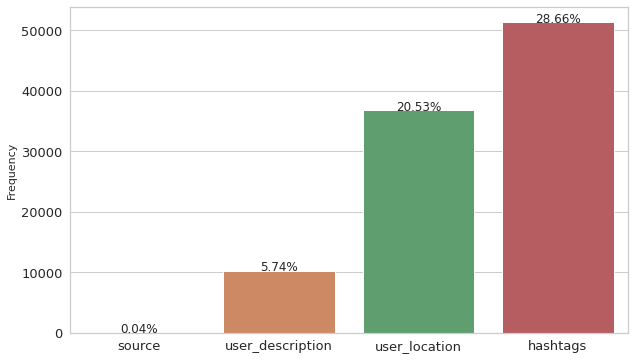

In [ ]:
missing_values = return_missing_values(df)
plot_missing_values(df)

## Unique Values
Let's count the unique value of each feature: 
* has expected `is_retweet` has only one unique value (`False`) since the dataset has been created by collecting not retweeted tweets;
* there are some identical tweets that we have to remove.

In [ ]:
for feature in df.columns.tolist():
  print("{} unique values -> {}".format(feature, len(df[feature].unique()))) 

user_name unique values -> 92276
user_location unique values -> 26921
user_description unique values -> 89201
user_created unique values -> 93708
user_followers unique values -> 27694
user_friends unique values -> 11022
user_favourites unique values -> 35259
user_verified unique values -> 2
date unique values -> 136611
text unique values -> 178683
hashtags unique values -> 52641
source unique values -> 611
is_retweet unique values -> 1


### **Remove text duplicates**



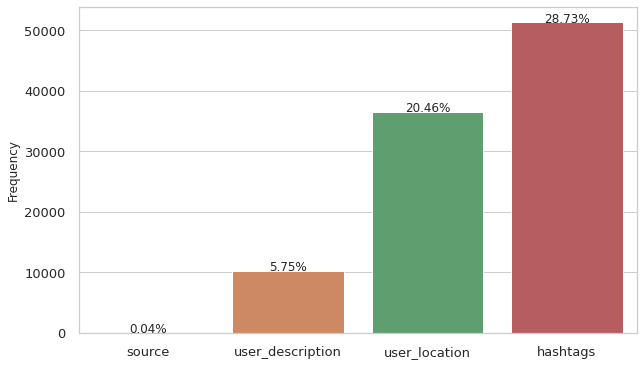

In [ ]:
df.drop_duplicates(subset='text', keep="last", inplace=True)
df.reset_index(inplace=True, drop = True)
# Udpate missing values
missing_values = return_missing_values(df)
plot_missing_values(df)

### **Locations**  
Around 20\% of locations are missing and we have nearly 30K different values for this feature.  
Some locations are quite creative (`'no e-pass to cross borders...', ' I ♥️ I ♥️ I ♥️ I', 'astroworld', "816 ways to say 'midwest'", 'Stuck in the Middle ' ...`) and there are many inconsistencies: `"New Delhi, India", "New Delhi", "London", "London, England", "UK", "United Kingdom", "USA", "U.S.A" ...`.  
To safely work with this feature we should prune out any fictional location and solve all the inconsistencies, which is out of this project scope.





In [ ]:
locations= df.user_location.unique()
locations[:10]

array(['astroworld', 'New York, NY', 'Pewee Valley, KY',
       'Stuck in the Middle ', 'Jammu and Kashmir', 'Новоро́ссия',
       'Gainesville, FL', nan, '👇🏻location at link below👇🏻',
       'Dhaka,Bangladesh'], dtype=object)

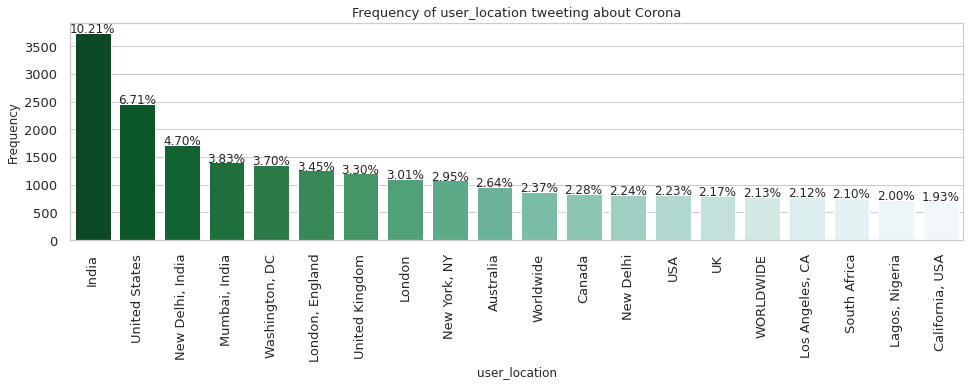

In [ ]:
plot_frequency_charts(df, 'user_location', 20, missing_values = True, missing_values_df = missing_values)

### **Hashtags**  
`hashtags` feature has nearly 29\% missing values and more than 52K different values.  
Since tweets have been collected searching for `#covid19`, the frequency chart displayed below is not unexpected: around 90\% of hashtags consists of different ways to write the search key (`#COVID19`, `#Covid19`, `#covid19`), and the remaining 10\% contains the search key and other subject related hashtags (`#pandemic`, `#coronavirus`, `#vaccine`,...).





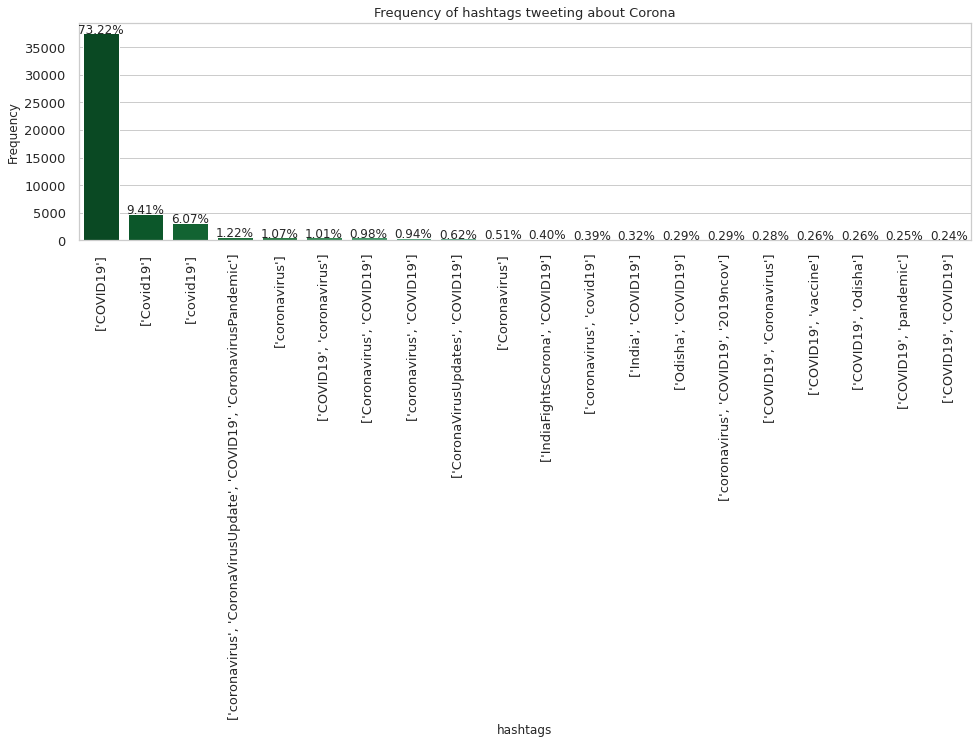

In [ ]:
plot_frequency_charts(df, 'hashtags', 20, missing_values = True, missing_values_df = missing_values)

### **User name**  
As we can see in the chart below, the most frequent names seem not to belong to physical people, but to **media**, **bots** and **private companies**.  
We confirmed our hypothesis by taking a look at users' description:

>*GlobalPandemic.NET*:
- Breaking News & Critical Information to SURVIVE the Coronavirus Outbreak / Civil Unrest

>*Coronavirus Updates*:
- COVID-19 (Coronavirus) Latest News & Statistics.
We post updates 24/7 as they come in, all stats are from official sources. #Coronavirus #COVID19

>*covidnews.ch*:
- Coronavirus Statistics, Information & News

>*Open Letters*:
- Copies of real letters delivered to the President, Congress, Governors, and State Legislators. Send 'resist' as a Direct Message to @resistbot to write yours.

>*Blood Donors India*:
- Focused on matching blood donors with those in need. No followers here, only contributors. Spread the word, help save lives. We save 8/day.

>...

Since our task is to in analyze people's emotions, we are not interested in tweets tweeted by media, bots or private companies; thus we try to filter out these tweets both by manually removing specific users' tweets and by searching for users whose description contains one or more words from the following list: 
>'news', 
           'newspaper', 
           'newspapers',
           'media', 
           'journal', 
           'journals', 
           'web sources', 
           'bot', 
           'bots', 
           'updates', 
           'headlines', 
           'official government'

At the end, we prune out around 39K tweets.





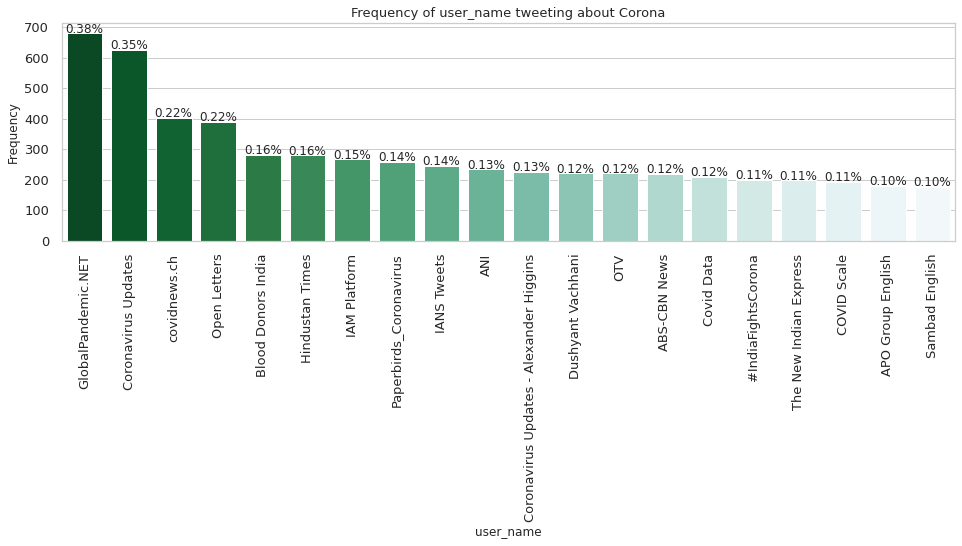

In [ ]:
plot_frequency_charts(df, 'user_name', 20)

Description of the top 20 most frequent users:

In [ ]:
target_names = df['user_name'].value_counts().index[:20]
for name in target_names:
  print(name,":\n-", df.user_description[df.user_name == name].values[0])
  print()

GlobalPandemic.NET :
- Breaking News & Critical Information to SURVIVE the Coronavirus Outbreak / Civil Unrest

Coronavirus Updates :
- COVID-19 (Coronavirus) Latest News & Statistics.
We post updates 24/7 as they come in, all stats are from official sources.
#Coronavirus #COVID19

covidnews.ch :
- Coronavirus Statistics, Information & News

Open Letters :
- Copies of real letters delivered to the President, Congress, Governors, and State Legislators. Send 'resist' as a Direct Message to @resistbot to write yours.

Blood Donors India :
- Focused on matching blood donors with those in need. No followers here, only contributors. Spread the word, help save lives. We save 8/day.

Hindustan Times :
- One of India's largest media companies. Latest news from around the world. Retweets are not endorsements

IAM Platform :
- Curation | Tools | Tips | Services

IAM Platform powers IAM Network:

GO: https://t.co/OJVc7LULBT

Blog | Social | Podcast | Code Trove

Paperbirds_Coronavirus :
- Paperbir

Examples of media and bots tweets:

In [ ]:
# Media
df.text[df.user_name == 'GlobalPandemic.NET']

221       ALERT: Eye Opener: Rep. John Lewis remembered ...
254       ALERT: Parents decide whether to send kids bac...
427       ALERT: Pregnant women at risk of death in Keny...
497       ALERT: Right-Wing People ‘Least Likely To Wear...
588       ALERT: Federal Agents Use Tear Gas To Clear Po...
                                ...                        
177758    ALERT: 1,200 students have tested positive for...
177983    ALERT: Portland Protestors Occupy Mayor Ted Wh...
178377    ALERT: Concealed Carry Permits are Increasing ...
178447    ALERT: People are trying to destroy a sheriff’...
178481    ALERT: U.S. Sanctions Russian Research Institu...
Name: text, Length: 679, dtype: object

In [ ]:
# Bot
df.text[df.user_name == 'Open Letters']

598       🖋 Sign “Protect ALL people from COVID-19” and ...
602       📬 I delivered “Impending Evictions” from Cathe...
1752      🖋 Sign “Extend COVID 19 Emergency Unemployment...
1787      🖋 Sign “Request for urgent support of Long Cov...
1928      🖋 Sign “Immediately impose a legislative morat...
                                ...                        
177447    🖋 Sign “COVID Crisis in ICE Detention, Release...
177694    🖋 Sign “GOP convention speech” and I’ll delive...
178184    📬 I delivered this ✉️ from Pamela, a 🗳 verifie...
178608    📬 I delivered “I VOTE FOR A BETTER TOMORROW” f...
178611    📬 I delivered “Why Didn’t You Wear a Face Mask...
Name: text, Length: 390, dtype: object

In [ ]:
# Cerca i tweet la cui descrizone utente contanga una fra queste parole per cercare di filtrare via i tweet di news:
matches = ['news', 
           'newspaper', 
           'newspapers',
           'media', 
           'journal', 
           'journals', 
           'web sources', 
           'bot', 
           'bots', 
           'updates', 
           'headlines', 
           'official government' ]

df_description = df.user_description.dropna()
indeces = []
for i in df_description.keys():
  text = df_description[i].lower()
  if text != None and any(x in text for x in matches):
    indeces.append(i)
print("Number of removed entries:", len(indeces))

# Cleaned DataFrame
df_cleaned = df.drop(df.index[indeces])
df_cleaned.reset_index(inplace=True, drop=True)

Number of removed entries: 37957


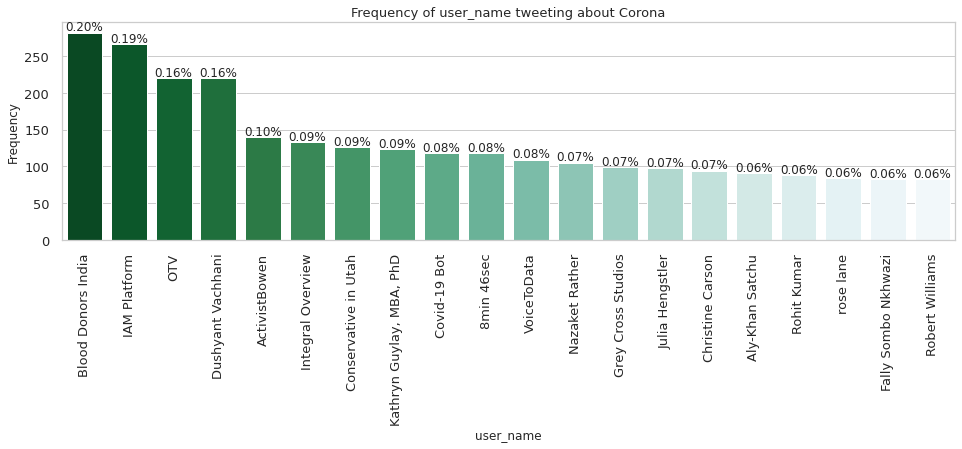

In [ ]:
plot_frequency_charts(df_cleaned, 'user_name', 20)

Removing specific accounts:

In [ ]:
target_names = ['Blood Donors India', 
                'IAM Platform', 
                'OTV', 
                'Covid-19 Bot',
                'CovidUpdate',
                'VoiceToData',
                'UnusualUpdate']
mask = df_cleaned.user_name.isin(target_names)
df_cleaned = df_cleaned[~mask] 

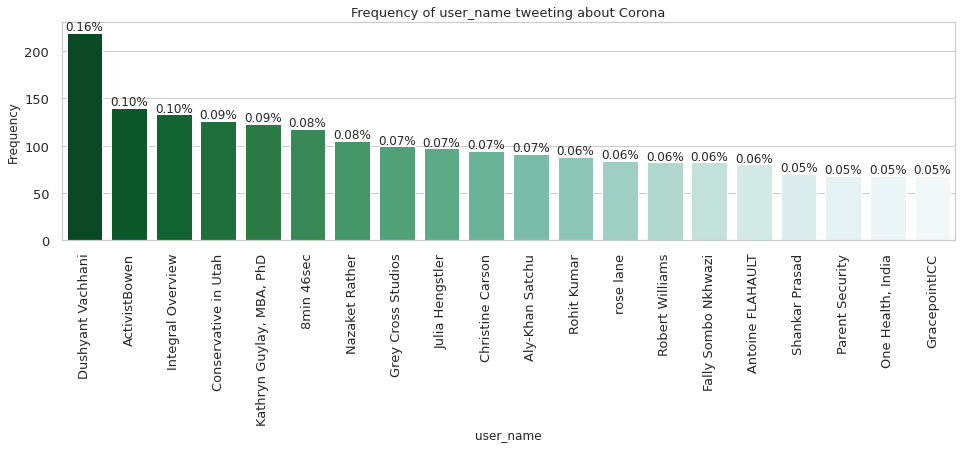

In [ ]:
plot_frequency_charts(df_cleaned, 'user_name', 20)

In [ ]:
df = df_cleaned
del df_cleaned
df.reset_index(inplace=True, drop=True)

### **Remove unuseful features**
For our purpose, we do not actually need all the information contained in the dataset: we will primarly focus our attention on **text**.

In [ ]:
df = df[['user_name', 'user_description', 'text']]

## Word Cloud
It could be interesting to visually inspect tweets content by generating a Word Cloud of the corpus.  
As expected, the **most frequent terms are related to CoVid19** topic('COVID19', 'CO', 'pandemy', 'coronaviru', 'case', 'death', 'mask',...).  
The term 'https' has a high frequency, since many tweets contain **external links**.  
Moreover, the importance of 'Trump' and 'realDonaldTrump' in the word cloud, may suggest us the presence of other topics. 

In [ ]:
# Creating Word Cloud
wordcloud = WordCloud(width = 3000, 
                      height = 2000, 
                      collocations=False, 
                      random_state = SEED_VALUE,
                      colormap = 'gist_rainbow').generate(" ".join(df.text.to_list()))


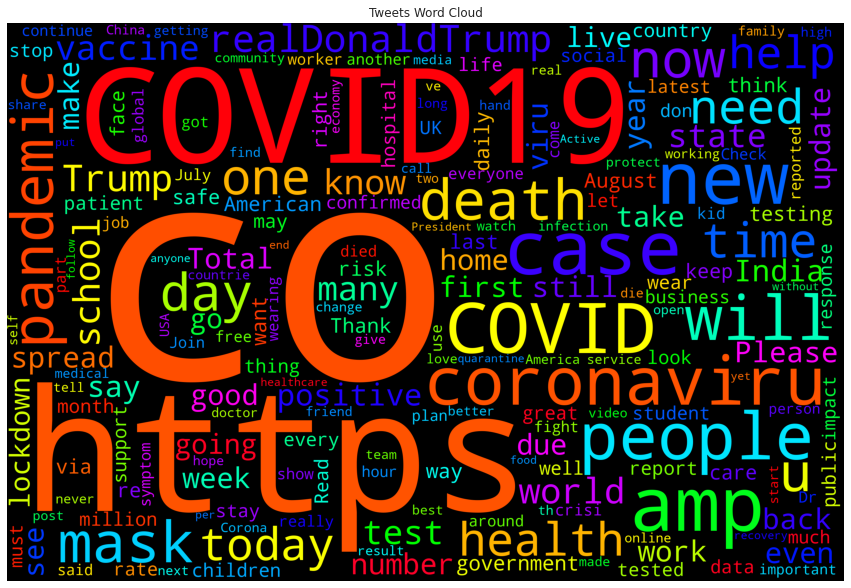

In [ ]:
# Plot
plt.figure(figsize=(15,20))
plt.axis("off")
plt.imshow(wordcloud) 
plt.title('Tweets Word Cloud')
plt.show()

# Text Preprocessing
In this section we are going to preprocess the tweets.

We had to define two types of preprocessing aimed at the different labeling techniques that we are going to implement.

In particular:
* The first preprocessing pipeline will be used to extract the `clean_text` to be used in **TWINT-labeling** and **NRClex-labeling**. 
* The second preprocessing pipeline will be used to extract the `clean_text` to be exploited in **VADER-labeling**.

**Pipeline 1**:
* remove format (bold, italic, and so on)
* lower text
* remove mentions 
* remove urls 
* transform emoji
* remove digits 
* remove punctuation 
* apostrophe 
* expand contractions 
* lemmatize 
* remove stopwords 

**Pipeline 2**:
* remove format
* remove mentions 
* remove urls 
* apostrophe 
* expand contractions (vader) 
* strip text
* hashtags
* trailing 
---------------------------

***NOTES ABOUT PIPELINE 2***:

As you can see from the lists above, in the second pipeline (compared to the first):
- we do not remove the punctuation
- we do not lower the text, we expand the contractions without replacing the slang
- we do not lemmatize
- we do not transform emojis and emoticons
we do not remove the stopwords
- since we do not remove the punctuation, we have to manually eliminate spurious characters referring to hashtags and trailing (\ n, \ t).

We need to use this pipeline because VADER assigns a polarity in reference to the following as well:

- Punctuation
- Capitalization
- Conjunctions
- Preceding Tri-gram
- Emojis, Slangs, and Emoticons

Please, refer to the **VADER Section** for furhter details. 

---------------------------
***NOTES ABOUT STOPWORDS***:

We have also included among the stopwords some very frequent words (see Word Cloud before Text Preprocessing) which were either not very significant (such as `ha` or `amp` -aint my problem-) or strictly related to the context of the tweets of our case study (such as `covid`, `coronavirus` etc.), and so not very significant too.
This is the complete list of words we have included in the stopwords list:

    ['covid', 'co', 'coronavirus', 'corona', 'virus', 'new','case', 'cases','coronavirusupdates', 'ha', 'amp']


The stopwords in **Pipeline 2** have not been removed because, since VADER also bases its analysis on bigrams and trigrams, it considers stopwords to evaluate the possible negativity of a sentence. (For example, the sentence 'not so happy' has a negative polarity due to presence of the stopword 'not'). 

----------------------------

***FURTHER PREPROCESSING -  DUPLICATES REMOVAL***:

We realized, from an analysis of the clean text, that there were many duplicates and we decided to leave a single copy for each text in order not to generate outliers in the Unsupervised Analysis (KMeans algorithms for Clustering).

------------------------------


In [ ]:
target = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '!', '?', '.', ',', '"', "'"];
specialList = {
        'serifBold' : ['𝐚', '𝐛', '𝐜', '𝐝', '𝐞', '𝐟', '𝐠', '𝐡', '𝐢', '𝐣', '𝐤', '𝐥', '𝐦', '𝐧', '𝐨', '𝐩', '𝐪', '𝐫', '𝐬', '𝐭', '𝐮', '𝐯', '𝐰', '𝐱', '𝐲', '𝐳', '𝐀', '𝐁', '𝐂', '𝐃', '𝐄', '𝐅', '𝐆', '𝐇', '𝐈', '𝐉', '𝐊', '𝐋', '𝐌', '𝐍', '𝐎', '𝐏', '𝐐', '𝐑', '𝐒', '𝐓', '𝐔', '𝐕', '𝐖', '𝐗', '𝐘', '𝐙', '𝟎', '𝟏', '𝟐', '𝟑', '𝟒', '𝟓', '𝟔', '𝟕', '𝟖', '𝟗', '❗', '❓'],
        'serifItalic' : ['𝑎', '𝑏', '𝑐', '𝑑', '𝑒', '𝑓', '𝑔', 'ℎ', '𝑖', '𝑗', '𝑘', '𝑙', '𝑚', '𝑛', '𝑜', '𝑝', '𝑞', '𝑟', '𝑠', '𝑡', '𝑢', '𝑣', '𝑤', '𝑥', '𝑦', '𝑧', '𝐴', '𝐵', '𝐶', '𝐷', '𝐸', '𝐹', '𝐺', '𝐻', '𝐼', '𝐽', '𝐾', '𝐿', '𝑀', '𝑁', '𝑂', '𝑃', '𝑄', '𝑅', '𝑆', '𝑇', '𝑈', '𝑉', '𝑊', '𝑋', '𝑌', '𝑍'],
        'serifBoldItalic' : ['𝒂', '𝒃', '𝒄', '𝒅', '𝒆', '𝒇', '𝒈', '𝒉', '𝒊', '𝒋', '𝒌', '𝒍', '𝒎', '𝒏', '𝒐', '𝒑', '𝒒', '𝒓', '𝒔', '𝒕', '𝒖', '𝒗', '𝒘', '𝒙', '𝒚', '𝒛', '𝑨', '𝑩', '𝑪', '𝑫', '𝑬', '𝑭', '𝑮', '𝑯', '𝑰', '𝑱', '𝑲', '𝑳', '𝑴', '𝑵', '𝑶', '𝑷', '𝑸', '𝑹', '𝑺', '𝑻', '𝑼', '𝑽', '𝑾', '𝑿', '𝒀', '𝒁', '𝟎', '𝟏', '𝟐', '𝟑', '𝟒', '𝟓', '𝟔', '𝟕', '𝟖', '𝟗', '❗', '❓'],
        'sans' : ['𝖺', '𝖻', '𝖼', '𝖽', '𝖾', '𝖿', '𝗀', '𝗁', '𝗂', '𝗃', '𝗄', '𝗅', '𝗆', '𝗇', '𝗈', '𝗉', '𝗊', '𝗋', '𝗌', '𝗍', '𝗎', '𝗏', '𝗐', '𝗑', '𝗒', '𝗓', '𝖠', '𝖡', '𝖢', '𝖣', '𝖤', '𝖥', '𝖦', '𝖧', '𝖨', '𝖩', '𝖪', '𝖫', '𝖬', '𝖭', '𝖮', '𝖯', '𝖰', '𝖱', '𝖲', '𝖳', '𝖴', '𝖵', '𝖶', '𝖷', '𝖸', '𝖹', '𝟢', '𝟣', '𝟤', '𝟥', '𝟦', '𝟧', '𝟨', '𝟩', '𝟪', '𝟫'],
        'sansBold' : ['𝗮', '𝗯', '𝗰', '𝗱', '𝗲', '𝗳', '𝗴', '𝗵', '𝗶', '𝗷', '𝗸', '𝗹', '𝗺', '𝗻', '𝗼', '𝗽', '𝗾', '𝗿', '𝘀', '𝘁', '𝘂', '𝘃', '𝘄', '𝘅', '𝘆', '𝘇', '𝗔', '𝗕', '𝗖', '𝗗', '𝗘', '𝗙', '𝗚', '𝗛', '𝗜', '𝗝', '𝗞', '𝗟', '𝗠', '𝗡', '𝗢', '𝗣', '𝗤', '𝗥', '𝗦', '𝗧', '𝗨', '𝗩', '𝗪', '𝗫', '𝗬', '𝗭', '𝟬', '𝟭', '𝟮', '𝟯', '𝟰', '𝟱', '𝟲', '𝟳', '𝟴', '𝟵', '❗', '❓'],
        'sansItalic' : ['𝘢', '𝘣', '𝘤', '𝘥', '𝘦', '𝘧', '𝘨', '𝘩', '𝘪', '𝘫', '𝘬', '𝘭', '𝘮', '𝘯', '𝘰', '𝘱', '𝘲', '𝘳', '𝘴', '𝘵', '𝘶', '𝘷', '𝘸', '𝘹', '𝘺', '𝘻', '𝘈', '𝘉', '𝘊', '𝘋', '𝘌', '𝘍', '𝘎', '𝘏', '𝘐', '𝘑', '𝘒', '𝘓', '𝘔', '𝘕', '𝘖', '𝘗', '𝘘', '𝘙', '𝘚', '𝘛', '𝘜', '𝘝', '𝘞', '𝘟', '𝘠', '𝘡'],
        'sansBoldItalic' : ['𝙖', '𝙗', '𝙘', '𝙙', '𝙚', '𝙛', '𝙜', '𝙝', '𝙞', '𝙟', '𝙠', '𝙡', '𝙢', '𝙣', '𝙤', '𝙥', '𝙦', '𝙧', '𝙨', '𝙩', '𝙪', '𝙫', '𝙬', '𝙭', '𝙮', '𝙯', '𝘼', '𝘽', '𝘾', '𝘿', '𝙀', '𝙁', '𝙂', '𝙃', '𝙄', '𝙅', '𝙆', '𝙇', '𝙈', '𝙉', '𝙊', '𝙋', '𝙌', '𝙍', '𝙎', '𝙏', '𝙐', '𝙑', '𝙒', '𝙓', '𝙔', '𝙕', '𝟎', '𝟏', '𝟐', '𝟑', '𝟒', '𝟓', '𝟔', '𝟕', '𝟖', '𝟗', '❗', '❓'],
    }


def format(text):
  for value in specialList.values():
    for i, char in enumerate(value):
        text = text.replace(char, target[i])
  return text


class CleanText(BaseEstimator, TransformerMixin):

    # DIGITS
    def remove_digits(self, input_text):
        """Removes any digits from the text."""
        return re.sub(r'\d+', ' ', input_text)
    
    # MENTIONS
    def remove_mentions(self, input_text):
        """Removes mentions from the text by finding them through @""" 
        return re.sub(r'@\w+', ' ', input_text)

    # PUNCTUATION
    def remove_punctuation(self, input_text):
        """Replaces any punctuation symbol by a space."""
        punct = string.punctuation + '…“”￼＆—●'
        trantab = str.maketrans(punct, len(punct)*' ')
        return input_text.translate(trantab) 
    
    # STOPWORDS
    def remove_stopwords(self, input_text):
        """Removes english stopwords"""
        words = input_text.split() 
        clean_words = [word for word in words if word not in STOPWORDS] 
        return " ".join(clean_words) 
    
    # URLS
    def remove_urls(self, input_text):
        """Removes external links from the text by finding them through http(s)""" 
        return re.sub(r'http.?://[^\s]+[\s]?', ' ', input_text)
    
    # STEMMING
    def stemming(self, input_text):
        """ Returns the input text stemmed using Snowball algorithms."""
        stemmer = SnowballStemmer(language="english")
        words = input_text.split() 
        stemmed_words = [stemmer.stem(word) for word in words]
        return " ".join(stemmed_words)

    # LEMMATIZATION
    def lemmatize(self, input_text):
        """ Returns the input text lemmatized."""
        lemmatizer = WordNetLemmatizer()
        words = input_text.split() 
        lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
        return " ".join(lemmatized_words)
    
    # EMOJI
    def transform_emoji(self, input_text):
        """ Transforms emoji in the corresponding word."""
        clean_text = emoji.demojize(input_text, delimiters=("_", "_"))
        return re.sub(r'_', ' ', clean_text) 

    # LOWER
    def to_lower(self, input_text):
        """ Transform given text in lower case. """"
        return input_text.lower()

    # APOSTROPHE
    def apostrophe(self, input_text):
        """ Substitute '‘' with standard apostrophe "'". """
       return re.sub(r'‘', "'", input_text) 

    # FORMAT
    def remove_format(self, input_text):
        """ Transform formatted text in standard text 
            (i.e. using only target letters)
        """
        return format(input_text)

    # CONTRACTIONS - NO VADER 
    def expand_contractions(self, input_text):
        """ Transform contracted words into their standard form. """
        return contractions.fix(input_text)

    #-----------------
    # VADER FORMAT
    #------------------
    # CONTRACTIONS
    def expand_contractions_vader(self, input_text):
      """
      Since VADER works well with slang,
      we do not transform the slang in the text (slang = False)
      """
      return contractions.fix(input_text, slang = False)
    
    # STRIP TEXT 
    def strip_text(self,input_text):
      """ Removes spaces at the beginning and at the end of the string."""
      return input_text.strip()
    
    # HASTAGS 
    def hashtags(self, input_text):
      """ Replace hashtag special character with white space. """
      return input_text.replace("#", " ")

    # TRAILING 
    def trailing(self, input_text):
      """ Replace trailing characters with white space. """
      return input_text.replace('\n', " ").replace("\r", " ")

    def fit(self, X, y=None, **fit_params):
        return self

    # PIPELINE 1
    def transform(self, X, **transform_params):
        
      clean_X = X.apply(self.remove_format)\
              .apply(self.to_lower)\
              .apply(self.remove_mentions)\
              .apply(self.remove_urls)\
              .apply(self.transform_emoji)\
              .apply(self.remove_digits)\
              .apply(self.remove_punctuation)\
              .apply(self.apostrophe)\
              .apply(self.expand_contractions)\
              .apply(self.lemmatize)\
              .apply(self.remove_stopwords)

      return clean_X
    
    # PIPELINE 2 
    def transform_vader(self, X, **transform_params):
      
      clean_X = X.apply(self.remove_format)\
                .apply(self.remove_mentions)\
                .apply(self.remove_urls)\
                .apply(self.apostrophe)\
                .apply(self.expand_contractions_vader)\
                .apply(self.strip_text)\
                .apply(self.hashtags)\
                .apply(self.trailing)

      return clean_X

In [ ]:
# WARNING: time consuming!

%%time 

ct = CleanText() 
df['clean_text'] = ct.fit(df.text).transform(df.text)

# VADER requires a different preprocessing pipeline
ct = CleanText() 
df['VADER_clean_text'] = ct.fit(df.text).transform_vader(df.text)

CPU times: user 2min, sys: 211 ms, total: 2min
Wall time: 2min


In [ ]:
# REMOVE TEXT DUPLICATES AFTER PREPROCESSING 
df.drop_duplicates(subset='clean_text', keep="last", inplace=True)
df.reset_index(inplace=True, drop = True)

In [ ]:
voc = set()
for sentence in df.clean_text:
  for word in sentence.split():
    voc.add(word)

voc = list(voc)

VADER_voc = set()
for sentence in df.VADER_clean_text:
  for word in sentence.split():
    VADER_voc.add(word)

VADER_voc = list(VADER_voc)

In [ ]:
len(voc) 

77736

In [ ]:
len(VADER_voc)

205599

In [ ]:
df[['text', 'clean_text', 'VADER_clean_text']][:20]

text  ...                                   VADER_clean_text
0   If I smelled the scent of hand sanitizers toda...  ...  If I smelled the scent of hand sanitizers toda...
1   @diane3443 @wdunlap @realDonaldTrump Trump nev...  ...  Trump never once claimed  COVID19 was a hoax. ...
2   @brookbanktv The one gift #COVID19 has give me...  ...  The one gift  COVID19 has give me is an apprec...
3   25 July : Media Bulletin on Novel #CoronaVirus...  ...  25 July : Media Bulletin on Novel  CoronaVirus...
4   #coronavirus #covid19 deaths continue to rise....  ...   coronavirus  covid19 deaths continue to rise....
5   You now have to wear face coverings when out s...  ...  You now have to wear face coverings when out s...
6   Praying for good health and recovery of @Chouh...  ...  Praying for good health and recovery of   .  c...
7   POPE AS GOD - Prophet Sadhu Sundar Selvaraj. W...  ...  POPE AS GOD - Prophet Sadhu Sundar Selvaraj. W...
8   49K+ Covid19 cases still no response from \n@c...  ...  49K+ Covid19 cases still no response from     ...
9   Order here: https://t.co/4NUrGX6EmA\n\n#logo #...  ...  Order here:    logo  graphicdesigner  logodesi...
10  Let's all protect ourselves from #COVID19.\nIt...  ...  let us all protect ourselves from  COVID19. it...
11  Nagaland police on Covid-19 Awareness at City ...  ...  Nagaland police on Covid-19 Awareness at City ...
12  July 25 #COVID19 update\n#TamilNadu - 6988\nDi...  ...  July 25  COVID19 update  TamilNadu - 6988 Disc...
13  Second wave of #COVID19 in Flanders..back to m...  ...  Second wave of  COVID19 in Flanders..back to m...
14  It is during our darkest moments that we must ...  ...  It is during our darkest moments that we must ...
15  COVID Update: The infection rate in Florida is...  ...  COVID Update: The infection rate in Florida is...
16  @EvanAKilgore @realDonaldTrump Good Patriots!\...  ...  Good Patriots! Call to Volunteer to be an Elec...
17  @JimBnntt Your image doesn't list a source, bu...  ...  Your image does not list a source, but I would...
18  The first comprehensive review of #WASH &amp; ...  ...  The first comprehensive review of  WASH &amp; ...
19  Holy water in times of #COVID19 https://t.co/Y...  ...                    Holy water in times of  COVID19

[20 rows x 3 columns]

### Save clean dataset

In [ ]:
with open('df_clean.pickle', 'wb') as handle:
    pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Word Cloud 
We will show below the Word Cloud referred to our tweets, before and after the cleaning carried out in the EDA and Preprocessing sections.

We also show the Word Cloud of clean texts through Pipeline 2 (for VADER-labeling).

A detailed analysis between the various Word Clouds is present in the **Word Cloud Analysis Section**.


In [ ]:
# Creating Word Cloud 
wordcloud_preprocessed = WordCloud(width = 3000, 
                      height = 2000, 
                      collocations=False, 
                      random_state = SEED_VALUE,
                      colormap = 'gist_rainbow').generate(" ".join(df.VADER_clean_text.to_list()))

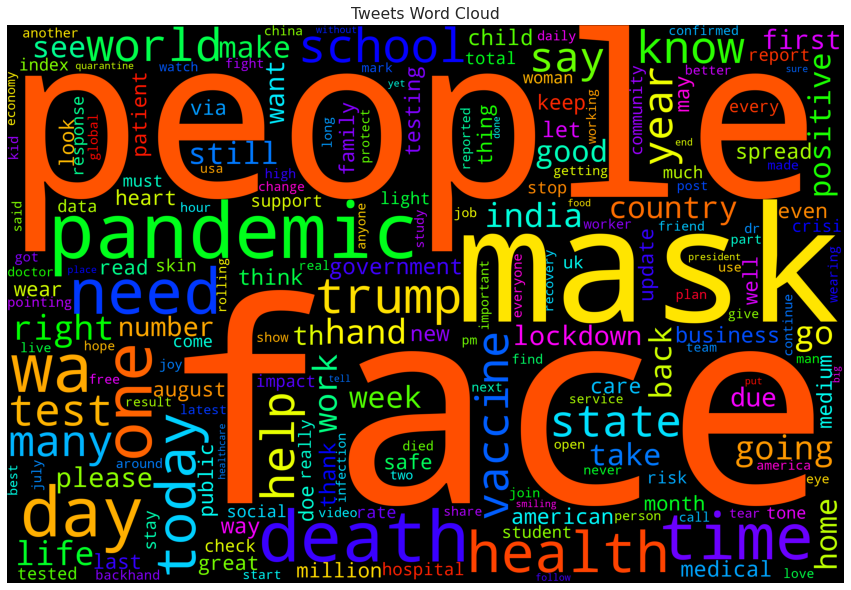

In [ ]:
# Word Cloud after cleaning 
# Plot
plt.figure(figsize=(15,20))
plt.axis("off")
plt.imshow(wordcloud_preprocessed) 
plt.title('Tweets Word Cloud')
plt.show()

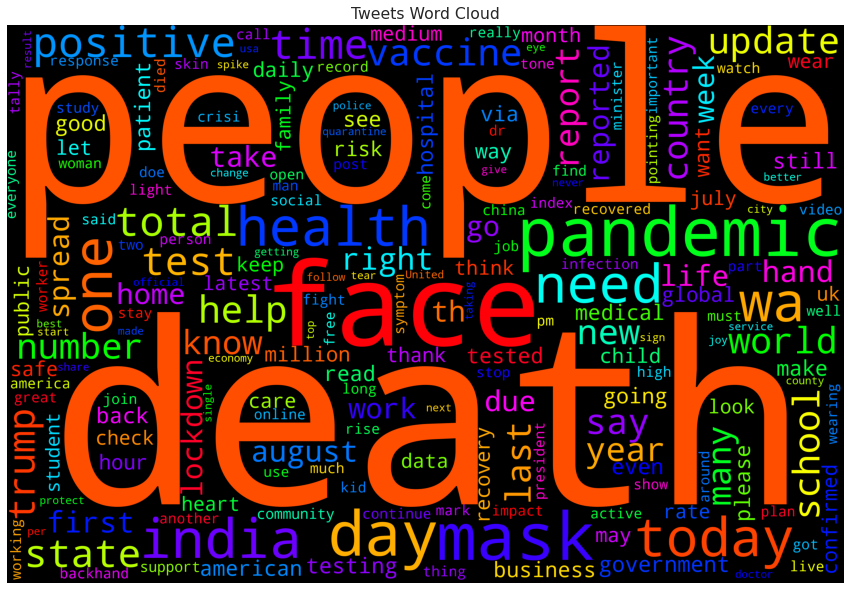

In [ ]:
# Word Cloud before cleaning and preprocessing (all tweets with duplicates)
# Plot
plt.figure(figsize=(15,20))
plt.axis("off")
plt.imshow(wordcloud_preprocessed) 
plt.title('Tweets Word Cloud')
plt.show()

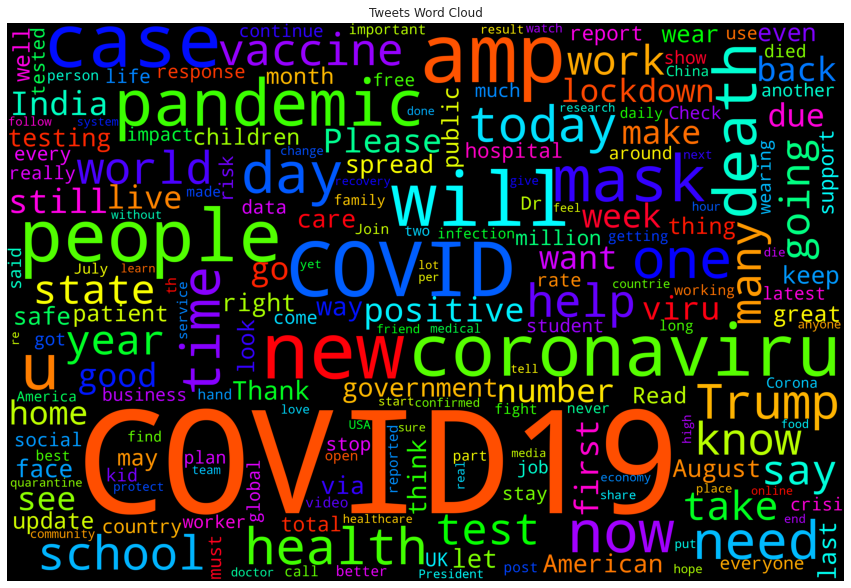

In [ ]:
# Word Cloud after cleaning - VADER
plt.figure(figsize=(15,20))
plt.axis("off")
plt.imshow(wordcloud_preprocessed) 
plt.title('Tweets Word Cloud')
plt.show()

# LDA
There are several existing algorithms you can use to perform the topic modeling. The most common of it are, Latent Semantic Analysis (LSA/LSI), Probabilistic Latent Semantic Analysis (pLSA), and Latent Dirichlet Allocation (LDA). 

Here we are going to use Latent Dirichlet Allocation (LDA). 


### Data preparation

To prepare data in order to be used in LDA algorithm, we need to peform some steps: 
- Text Preprocessing (already done in Text Preprocessing Section). In order to correctly extract topics it is recommended to perform the following steps: 
  - lower text 
  - remove punctuation 
  - remove stopwords 
  - lemmatize 
- Text tokenization 
- Convert the tokenized object into a corpus and dictionary

--------------------
***Optimize Interpretability***

In order to **optimize interpretatibility** is better to identify phrases through **n-grams** and **filter noun-type structures**. 

We want to identify phrases so the topic model can recognize them. 

- **Bigrams** are phrases containing 2 words e.g. ‘social media’. 
- Likewise, **trigrams** are phrases containing 3 words e.g. ‘Proctor and Gamble’. 

There are many ways to detect n-grams. We use **Pointwise Mutual Information (PMI)** score to identify significant bigrams and trigrams to concatenate. PMI measures how much more likely the words co-occur than if they were independent. The metric is sensitive to rare combination of words, so it is used with an occurrence frequency filter to ensure phrase relevance.

We also filter bigrams or trigrams with the filter (noun/adj, noun), (noun/adj,all types,noun/adj) because these are common structures pointing out noun-type n-grams. This helps the LDA model better cluster topics.

--------------------------
***NOTES: Stopwords and Personal Names***

In order to have less noisy results in the search for topics, we have decided to adopt the following strategies:
- Adding new stopwords to the original stopwords list (and used for preprocessing): we have removed very common and not very significant words for our purpose 
- Removal of personal names for the same reasons as above
- We filter bigrams or trigrams with noun structures (POS-tag = **NN**). This helps the LDA model better cluster topics, as nouns are better indicators of a topic being talked about. 

#### Utils 

In [ ]:
more_stopwords = ['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', 'around', 'as', 'at', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'between', 'beyond', 'bill', 'both', 'bottom', 'but', 'by', 'can', 'cannot', 'cant', 'co', 'con', 'could', 'couldnt', 'de', 'describe', 'detail', 'did', 'didn', 'do', 'does', 'doesn', 'doing', 'don', 'done', 'down', 'due', 'during', 'each', 'eg', 'eight', 'either', 'eleven', 'else', 'elsewhere', 'enough', 'etc', 'even', 'ever', 'every', 'everyone', 'everything', 'everywhere', 'except', 'few', 'fifteen', 'fify', 'fill', 'find', 'fire', 'first', 'five', 'for', 'former', 'formerly', 'forty', 'found', 'four', 'from', 'further', 'get', 'give', 'go', 'had', 'has', 'hasnt', 'have', 'he', 'hence', 'her', 'here', 'hereafter', 'hereby', 'herein', 'hereupon', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'however', 'hundred', 'i', 'ie', 'if', 'in', 'inc', 'indeed', 'into', 'is', 'it', 'its', 'itself', 'just', 'keep', 'kg', 'km', 'latter', 'latterly', 'ltd', 'lot', 'let','made', 'make', 'many', 'may', 'me', 'meanwhile', 'might', 'mill', 'mine', 'more', 'moreover', 'most', 'mostly', 'move', 'much', 'must', 'my', 'myself', 'name', 'namely', 'neither', 'nevertheless', 'next', 'nine', 'no', 'nor', 'not', 'nothing', 'now', 'of', 'off', 'often', 'on', 'once', 'one', 'only', 'onto', 'or', 'other', 'others', 'otherwise', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'per', 'perhaps', 'please', 'put', 'quite', 'rather', 'rather', 're', 'really', 'regarding', 'same', 'say', 'see', 'seem', 'seemed', 'seeming', 'seems', 'several', 'she', 'should', 'show', 'since', 'six', 'sixty', 'so', 'some', 'somehow', 'someone', 'something', 'sometime', 'sometimes', 'somewhere', 'still', 'such', 'take', 'ten', 'than', 'that', 'the', 'their', 'them', 'themselves', 'then', 'thence', 'there', 'thereafter', 'thereby', 'therefore', 'therein', 'thereupon', 'these', 'they', 'thick', 'thin', 'third', 'this', 'those', 'though', 'three', 'through', 'throughout', 'thru', 'thus', 'to', 'too', 'toward', 'towards', 'twelve', 'twenty', 'two', 'un', 'under', 'unless', 'until', 'up', 'upon', 'us', 'used', 'using', 'various', 'very', 'very', 'via', 'was', 'we', 'well', 'were', 'what', 'whatever', 'when', 'whence', 'whenever', 'where', 'whereafter', 'whereas', 'whereby', 'wherein', 'whereupon', 'wherever', 'whether', 'which', 'while', 'whither', 'who', 'whoever', 'whole', 'whom', 'whose', 'why', 'will', 'with', 'within', 'without', 'would', 'yet', 'you', 'your', 'yours', 'yourself', 'yourselves']
stop_word_list = STOPWORDS + list(set(more_stopwords) - set(STOPWORDS))
english_names = ['aaren', 'aarika', 'abagael', 'abagail', 'abbe', 'abbey', 'abbi', 'abbie', 'abby', 'abbye', 'abigael', 'abigail', 'abigale', 'abra', 'ada', 'adah', 'adaline', 'adan', 'adara', 'adda', 'addi', 'addia', 'addie', 'addy', 'adel', 'adela', 'adelaida', 'adelaide', 'adele', 'adelheid', 'adelice', 'adelina', 'adelind', 'adeline', 'adella', 'adelle', 'adena', 'adey', 'adi', 'adiana', 'adina', 'adora', 'adore', 'adoree', 'adorne', 'adrea', 'adria', 'adriaens', 'adrian', 'adriana', 'adriane', 'adrianna', 'adrianne', 'adriena', 'adrienne', 'aeriel', 'aeriela', 'aeriell', 'afton', 'ag', 'agace', 'agata', 'agatha', 'agathe', 'aggi', 'aggie', 'aggy', 'agna', 'agnella', 'agnes', 'agnese', 'agnesse', 'agneta', 'agnola', 'agretha', 'aida', 'aidan', 'aigneis', 'aila', 'aile', 'ailee', 'aileen', 'ailene', 'ailey', 'aili', 'ailina', 'ailis', 'ailsun', 'ailyn', 'aime', 'aimee', 'aimil', 'aindrea', 'ainslee', 'ainsley', 'ainslie', 'ajay', 'alaine', 'alameda', 'alana', 'alanah', 'alane', 'alanna', 'alayne', 'alberta', 'albertina', 'albertine', 'albina', 'alecia', 'aleda', 'aleece', 'aleen', 'alejandra', 'alejandrina', 'alena', 'alene', 'alessandra', 'aleta', 'alethea', 'alex', 'alexa', 'alexandra', 'alexandrina', 'alexi', 'alexia', 'alexina', 'alexine', 'alexis', 'alfi', 'alfie', 'alfreda', 'alfy', 'ali', 'alia', 'alica', 'alice', 'alicea', 'alicia', 'alida', 'alidia', 'alie', 'alika', 'alikee', 'alina', 'aline', 'alis', 'alisa', 'alisha', 'alison', 'alissa', 'alisun', 'alix', 'aliza', 'alla', 'alleen', 'allegra', 'allene', 'alli', 'allianora', 'allie', 'allina', 'allis', 'allison', 'allissa', 'allix', 'allsun', 'allx', 'ally', 'allyce', 'allyn', 'allys', 'allyson', 'alma', 'almeda', 'almeria', 'almeta', 'almira', 'almire', 'aloise', 'aloisia', 'aloysia', 'alta', 'althea', 'alvera', 'alverta', 'alvina', 'alvinia', 'alvira', 'alyce', 'alyda', 'alys', 'alysa', 'alyse', 'alysia', 'alyson', 'alyss', 'alyssa', 'amabel', 'amabelle', 'amalea', 'amalee', 'amaleta', 'amalia', 'amalie', 'amalita', 'amalle', 'amanda', 'amandi', 'amandie', 'amandy', 'amara', 'amargo', 'amata', 'amber', 'amberly', 'ambur', 'ame', 'amelia', 'amelie', 'amelina', 'ameline', 'amelita', 'ami', 'amie', 'amii', 'amil', 'amitie', 'amity', 'ammamaria', 'amy', 'amye', 'ana', 'anabal', 'anabel', 'anabella', 'anabelle', 'analiese', 'analise', 'anallese', 'anallise', 'anastasia', 'anastasie', 'anastassia', 'anatola', 'andee', 'andeee', 'anderea', 'andi', 'andie', 'andra', 'andrea', 'andreana', 'andree', 'andrei', 'andria', 'andriana', 'andriette', 'andromache', 'andy', 'anestassia', 'anet', 'anett', 'anetta', 'anette', 'ange', 'angel', 'angela', 'angele', 'angelia', 'angelica', 'angelika', 'angelina', 'angeline', 'angelique', 'angelita', 'angelle', 'angie', 'angil', 'angy', 'ania', 'anica', 'anissa', 'anita', 'anitra', 'anjanette', 'anjela', 'ann', 'ann-marie', 'anna', 'anna-diana', 'anna-diane', 'anna-maria', 'annabal', 'annabel', 'annabela', 'annabell', 'annabella', 'annabelle', 'annadiana', 'annadiane', 'annalee', 'annaliese', 'annalise', 'annamaria', 'annamarie', 'anne', 'anne-corinne', 'anne-marie', 'annecorinne', 'anneliese', 'annelise', 'annemarie', 'annetta', 'annette', 'anni', 'annice', 'annie', 'annis', 'annissa', 'annmaria', 'annmarie', 'annnora', 'annora', 'anny', 'anselma', 'ansley', 'anstice', 'anthe', 'anthea', 'anthia', 'anthiathia', 'antoinette', 'antonella', 'antonetta', 'antonia', 'antonie', 'antonietta', 'antonina', 'anya', 'appolonia', 'april', 'aprilette', 'ara', 'arabel', 'arabela', 'arabele', 'arabella', 'arabelle', 'arda', 'ardath', 'ardeen', 'ardelia', 'ardelis', 'ardella', 'ardelle', 'arden', 'ardene', 'ardenia', 'ardine', 'ardis', 'ardisj', 'ardith', 'ardra', 'ardyce', 'ardys', 'ardyth', 'aretha', 'ariadne', 'ariana', 'aridatha', 'ariel', 'ariela', 'ariella', 'arielle', 'arlana', 'arlee', 'arleen', 'arlen', 'arlena', 'arlene', 'arleta', 'arlette', 'arleyne', 'arlie', 'arliene', 'arlina', 'arlinda', 'arline', 'arluene', 'arly', 'arlyn', 'arlyne', 'aryn', 'ashely', 'ashia', 'ashien', 'ashil', 'ashla', 'ashlan', 'ashlee', 'ashleigh', 'ashlen', 'ashley', 'ashli', 'ashlie', 'ashly', 'asia', 'astra', 'astrid', 'astrix', 'atalanta', 'athena', 'athene', 'atlanta', 'atlante', 'auberta', 'aubine', 'aubree', 'aubrette', 'aubrey', 'aubrie', 'aubry', 'audi', 'audie', 'audra', 'audre', 'audrey', 'audrie', 'audry', 'audrye', 'audy', 'augusta', 'auguste', 'augustina', 'augustine', 'aundrea', 'aura', 'aurea', 'aurel', 'aurelea', 'aurelia', 'aurelie', 'auria', 'aurie', 'aurilia', 'aurlie', 'auroora', 'aurora', 'aurore', 'austin', 'austina', 'austine', 'ava', 'aveline', 'averil', 'averyl', 'avie', 'avis', 'aviva', 'avivah', 'avril', 'avrit', 'ayn', 'bab', 'babara', 'babb', 'babbette', 'babbie', 'babette', 'babita', 'babs', 'bambi', 'bambie', 'bamby', 'barb', 'barbabra', 'barbara', 'barbara-anne', 'barbaraanne', 'barbe', 'barbee', 'barbette', 'barbey', 'barbi', 'barbie', 'barbra', 'barby', 'bari', 'barrie', 'barry', 'basia', 'bathsheba', 'batsheva', 'bea', 'beatrice', 'beatrisa', 'beatrix', 'beatriz', 'bebe', 'becca', 'becka', 'becki', 'beckie', 'becky', 'bee', 'beilul', 'beitris', 'bekki', 'bel', 'belia', 'belicia', 'belinda', 'belita', 'bell', 'bella', 'bellanca', 'belle', 'bellina', 'belva', 'belvia', 'bendite', 'benedetta', 'benedicta', 'benedikta', 'benetta', 'benita', 'benni', 'bennie', 'benny', 'benoite', 'berenice', 'beret', 'berget', 'berna', 'bernadene', 'bernadette', 'bernadina', 'bernadine', 'bernardina', 'bernardine', 'bernelle', 'bernete', 'bernetta', 'bernette', 'berni', 'bernice', 'bernie', 'bernita', 'berny', 'berri', 'berrie', 'berry', 'bert', 'berta', 'berte', 'bertha', 'berthe', 'berti', 'bertie', 'bertina', 'bertine', 'berty', 'beryl', 'beryle', 'bess', 'bessie', 'bessy', 'beth', 'bethanne', 'bethany', 'bethena', 'bethina', 'betsey', 'betsy', 'betta', 'bette', 'bette-ann', 'betteann', 'betteanne', 'betti', 'bettina', 'bettine', 'betty', 'bettye', 'beulah', 'bev', 'beverie', 'beverlee', 'beverley', 'beverlie', 'beverly', 'bevvy', 'bianca', 'bianka', 'bibbie', 'bibby', 'bibbye', 'bibi', 'biddie', 'biddy', 'bidget', 'bili', 'bill', 'billi', 'billie', 'billy', 'billye', 'binni', 'binnie', 'binny', 'bird', 'birdie', 'birgit', 'birgitta', 'blair', 'blaire', 'blake', 'blakelee', 'blakeley', 'blanca', 'blanch', 'blancha', 'blanche', 'blinni', 'blinnie', 'blinny', 'bliss', 'blisse', 'blithe', 'blondell', 'blondelle', 'blondie', 'blondy', 'blythe', 'bobbe', 'bobbee', 'bobbette', 'bobbi', 'bobbie', 'bobby', 'bobbye', 'bobette', 'bobina', 'bobine', 'bobinette', 'bonita', 'bonnee', 'bonni', 'bonnibelle', 'bonnie', 'bonny', 'brana', 'brandais', 'brande', 'brandea', 'brandi', 'brandice', 'brandie', 'brandise', 'brandy', 'breanne', 'brear', 'bree', 'breena', 'bren', 'brena', 'brenda', 'brenn', 'brenna', 'brett', 'bria', 'briana', 'brianna', 'brianne', 'bride', 'bridget', 'bridgette', 'bridie', 'brier', 'brietta', 'brigid', 'brigida', 'brigit', 'brigitta', 'brigitte', 'brina', 'briney', 'brinn', 'brinna', 'briny', 'brit', 'brita', 'britney', 'britni', 'britt', 'britta', 'brittan', 'brittaney', 'brittani', 'brittany', 'britte', 'britteny', 'brittne', 'brittney', 'brittni', 'brook', 'brooke', 'brooks', 'brunhilda', 'brunhilde', 'bryana', 'bryn', 'bryna', 'brynn', 'brynna', 'brynne', 'buffy', 'bunni', 'bunnie', 'bunny', 'cacilia', 'cacilie', 'cahra', 'cairistiona', 'caitlin', 'caitrin', 'cal', 'calida', 'calla', 'calley', 'calli', 'callida', 'callie', 'cally', 'calypso', 'cam', 'camala', 'camel', 'camella', 'camellia', 'cami', 'camila', 'camile', 'camilla', 'camille', 'cammi', 'cammie', 'cammy', 'candace', 'candi', 'candice', 'candida', 'candide', 'candie', 'candis', 'candra', 'candy', 'caprice', 'cara', 'caralie', 'caren', 'carena', 'caresa', 'caressa', 'caresse', 'carey', 'cari', 'caria', 'carie', 'caril', 'carilyn', 'carin', 'carina', 'carine', 'cariotta', 'carissa', 'carita', 'caritta', 'carla', 'carlee', 'carleen', 'carlen', 'carlene', 'carley', 'carlie', 'carlin', 'carlina', 'carline', 'carlita', 'carlota', 'carlotta', 'carly', 'carlye', 'carlyn', 'carlynn', 'carlynne', 'carma', 'carmel', 'carmela', 'carmelia', 'carmelina', 'carmelita', 'carmella', 'carmelle', 'carmen', 'carmencita', 'carmina', 'carmine', 'carmita', 'carmon', 'caro', 'carol', 'carol-jean', 'carola', 'carolan', 'carolann', 'carole', 'carolee', 'carolin', 'carolina', 'caroline', 'caroljean', 'carolyn', 'carolyne', 'carolynn', 'caron', 'carree', 'carri', 'carrie', 'carrissa', 'carroll', 'carry', 'cary', 'caryl', 'caryn', 'casandra', 'casey', 'casi', 'casie', 'cass', 'cassandra', 'cassandre', 'cassandry', 'cassaundra', 'cassey', 'cassi', 'cassie', 'cassondra', 'cassy', 'catarina', 'cate', 'caterina', 'catha', 'catharina', 'catharine', 'cathe', 'cathee', 'catherin', 'catherina', 'catherine', 'cathi', 'cathie', 'cathleen', 'cathlene', 'cathrin', 'cathrine', 'cathryn', 'cathy', 'cathyleen', 'cati', 'catie', 'catina', 'catlaina', 'catlee', 'catlin', 'catrina', 'catriona', 'caty', 'caye', 'cayla', 'cecelia', 'cecil', 'cecile', 'ceciley', 'cecilia', 'cecilla', 'cecily', 'ceil', 'cele', 'celene', 'celesta', 'celeste', 'celestia', 'celestina', 'celestine', 'celestyn', 'celestyna', 'celia', 'celie', 'celina', 'celinda', 'celine', 'celinka', 'celisse', 'celka', 'celle', 'cesya', 'chad', 'chanda', 'chandal', 'chandra', 'channa', 'chantal', 'chantalle', 'charil', 'charin', 'charis', 'charissa', 'charisse', 'charita', 'charity', 'charla', 'charlean', 'charleen', 'charlena', 'charlene', 'charline', 'charlot', 'charlotta', 'charlotte', 'charmain', 'charmaine', 'charmane', 'charmian', 'charmine', 'charmion', 'charo', 'charyl', 'chastity', 'chelsae', 'chelsea', 'chelsey', 'chelsie', 'chelsy', 'cher', 'chere', 'cherey', 'cheri', 'cherianne', 'cherice', 'cherida', 'cherie', 'cherilyn', 'cherilynn', 'cherin', 'cherise', 'cherish', 'cherlyn', 'cherri', 'cherrita', 'cherry', 'chery', 'cherye', 'cheryl', 'cheslie', 'chiarra', 'chickie', 'chicky', 'chiquia', 'chiquita', 'chlo', 'chloe', 'chloette', 'chloris', 'chris', 'chrissie', 'chrissy', 'christa', 'christabel', 'christabella', 'christal', 'christalle', 'christan', 'christean', 'christel', 'christen', 'christi', 'christian', 'christiana', 'christiane', 'christie', 'christin', 'christina', 'christine', 'christy', 'christye', 'christyna', 'chrysa', 'chrysler', 'chrystal', 'chryste', 'chrystel', 'cicely', 'cicily', 'ciel', 'cilka', 'cinda', 'cindee', 'cindelyn', 'cinderella', 'cindi', 'cindie', 'cindra', 'cindy', 'cinnamon', 'cissiee', 'cissy', 'clair', 'claire', 'clara', 'clarabelle', 'clare', 'claresta', 'clareta', 'claretta', 'clarette', 'clarey', 'clari', 'claribel', 'clarice', 'clarie', 'clarinda', 'clarine', 'clarissa', 'clarisse', 'clarita', 'clary', 'claude', 'claudelle', 'claudetta', 'claudette', 'claudia', 'claudie', 'claudina', 'claudine', 'clea', 'clem', 'clemence', 'clementia', 'clementina', 'clementine', 'clemmie', 'clemmy', 'cleo', 'cleopatra', 'clerissa', 'clio', 'clo', 'cloe', 'cloris', 'clotilda', 'clovis', 'codee', 'codi', 'codie', 'cody', 'coleen', 'colene', 'coletta', 'colette', 'colleen', 'collen', 'collete', 'collette', 'collie', 'colline', 'colly', 'con', 'concettina', 'conchita', 'concordia', 'conni', 'connie', 'conny', 'consolata', 'constance', 'constancia', 'constancy', 'constanta', 'constantia', 'constantina', 'constantine', 'consuela', 'consuelo', 'cookie', 'cora', 'corabel', 'corabella', 'corabelle', 'coral', 'coralie', 'coraline', 'coralyn', 'cordelia', 'cordelie', 'cordey', 'cordi', 'cordie', 'cordula', 'cordy', 'coreen', 'corella', 'corenda', 'corene', 'coretta', 'corette', 'corey', 'cori', 'corie', 'corilla', 'corina', 'corine', 'corinna', 'corinne', 'coriss', 'corissa', 'corliss', 'corly', 'cornela', 'cornelia', 'cornelle', 'cornie', 'corny', 'correna', 'correy', 'corri', 'corrianne', 'corrie', 'corrina', 'corrine', 'corrinne', 'corry', 'cortney', 'cory', 'cosetta', 'cosette', 'costanza', 'courtenay', 'courtnay', 'courtney', 'crin', 'cris', 'crissie', 'crissy', 'crista', 'cristabel', 'cristal', 'cristen', 'cristi', 'cristie', 'cristin', 'cristina', 'cristine', 'cristionna', 'cristy', 'crysta', 'crystal', 'crystie', 'cthrine', 'cyb', 'cybil', 'cybill', 'cymbre', 'cynde', 'cyndi', 'cyndia', 'cyndie', 'cyndy', 'cynthea', 'cynthia', 'cynthie', 'cynthy', 'dacey', 'dacia', 'dacie', 'dacy', 'dael', 'daffi', 'daffie', 'daffy', 'dagmar', 'dahlia', 'daile', 'daisey', 'daisi', 'daisie', 'daisy', 'dale', 'dalenna', 'dalia', 'dalila', 'dallas', 'daloris', 'damara', 'damaris', 'damita', 'dana', 'danell', 'danella', 'danette', 'dani', 'dania', 'danica', 'danice', 'daniela', 'daniele', 'daniella', 'danielle', 'danika', 'danila', 'danit', 'danita', 'danna', 'danni', 'dannie', 'danny', 'dannye', 'danya', 'danyelle', 'danyette', 'daphene', 'daphna', 'daphne', 'dara', 'darb', 'darbie', 'darby', 'darcee', 'darcey', 'darci', 'darcie', 'darcy', 'darda', 'dareen', 'darell', 'darelle', 'dari', 'daria', 'darice', 'darla', 'darleen', 'darlene', 'darline', 'darlleen', 'daron', 'darrelle', 'darryl', 'darsey', 'darsie', 'darya', 'daryl', 'daryn', 'dasha', 'dasi', 'dasie', 'dasya', 'datha', 'daune', 'daveen', 'daveta', 'davida', 'davina', 'davine', 'davita', 'dawn', 'dawna', 'dayle', 'dayna', 'ddene', 'de', 'deana', 'deane', 'deanna', 'deanne', 'deb', 'debbi', 'debbie', 'debby', 'debee', 'debera', 'debi', 'debor', 'debora', 'deborah', 'debra', 'dede', 'dedie', 'dedra', 'dee', 'dee dee', 'deeann', 'deeanne', 'deedee', 'deena', 'deerdre', 'deeyn', 'dehlia', 'deidre', 'deina', 'deirdre', 'del', 'dela', 'delcina', 'delcine', 'delia', 'delila', 'delilah', 'delinda', 'dell', 'della', 'delly', 'delora', 'delores', 'deloria', 'deloris', 'delphine', 'delphinia', 'demeter', 'demetra', 'demetria', 'demetris', 'dena', 'deni', 'denice', 'denise', 'denna', 'denni', 'dennie', 'denny', 'deny', 'denys', 'denyse', 'deonne', 'desdemona', 'desirae', 'desiree', 'desiri', 'deva', 'devan', 'devi', 'devin', 'devina', 'devinne', 'devon', 'devondra', 'devonna', 'devonne', 'devora', 'di', 'diahann', 'dian', 'diana', 'diandra', 'diane', 'diane-marie', 'dianemarie', 'diann', 'dianna', 'dianne', 'diannne', 'didi', 'dido', 'diena', 'dierdre', 'dina', 'dinah', 'dinnie', 'dinny', 'dion', 'dione', 'dionis', 'dionne', 'dita', 'dix', 'dixie', 'dniren', 'dode', 'dodi', 'dodie', 'dody', 'doe', 'doll', 'dolley', 'dolli', 'dollie', 'dolly', 'dolores', 'dolorita', 'doloritas', 'domeniga', 'dominga', 'domini', 'dominica', 'dominique', 'dona', 'donella', 'donelle', 'donetta', 'donia', 'donica', 'donielle', 'donna', 'donnamarie', 'donni', 'donnie', 'donny', 'dora', 'doralia', 'doralin', 'doralyn', 'doralynn', 'doralynne', 'dore', 'doreen', 'dorelia', 'dorella', 'dorelle', 'dorena', 'dorene', 'doretta', 'dorette', 'dorey', 'dori', 'doria', 'dorian', 'dorice', 'dorie', 'dorine', 'doris', 'dorisa', 'dorise', 'dorita', 'doro', 'dorolice', 'dorolisa', 'dorotea', 'doroteya', 'dorothea', 'dorothee', 'dorothy', 'dorree', 'dorri', 'dorrie', 'dorris', 'dorry', 'dorthea', 'dorthy', 'dory', 'dosi', 'dot', 'doti', 'dotti', 'dottie', 'dotty', 'dre', 'dreddy', 'dredi', 'drona', 'dru', 'druci', 'drucie', 'drucill', 'drucy', 'drusi', 'drusie', 'drusilla', 'drusy', 'dulce', 'dulcea', 'dulci', 'dulcia', 'dulciana', 'dulcie', 'dulcine', 'dulcinea', 'dulcy', 'dulsea', 'dusty', 'dyan', 'dyana', 'dyane', 'dyann', 'dyanna', 'dyanne', 'dyna', 'dynah', 'eachelle', 'eada', 'eadie', 'eadith', 'ealasaid', 'eartha', 'easter', 'eba', 'ebba', 'ebonee', 'ebony', 'eda', 'eddi', 'eddie', 'eddy', 'ede', 'edee', 'edeline', 'eden', 'edi', 'edie', 'edin', 'edita', 'edith', 'editha', 'edithe', 'ediva', 'edna', 'edwina', 'edy', 'edyth', 'edythe', 'effie', 'eileen', 'eilis', 'eimile', 'eirena', 'ekaterina', 'elaina', 'elaine', 'elana', 'elane', 'elayne', 'elberta', 'elbertina', 'elbertine', 'eleanor', 'eleanora', 'eleanore', 'electra', 'eleen', 'elena', 'elene', 'eleni', 'elenore', 'eleonora', 'eleonore', 'elfie', 'elfreda', 'elfrida', 'elfrieda', 'elga', 'elianora', 'elianore', 'elicia', 'elie', 'elinor', 'elinore', 'elisa', 'elisabet', 'elisabeth', 'elisabetta', 'elise', 'elisha', 'elissa', 'elita', 'eliza', 'elizabet', 'elizabeth', 'elka', 'elke', 'ella', 'elladine', 'elle', 'ellen', 'ellene', 'ellette', 'elli', 'ellie', 'ellissa', 'elly', 'ellyn', 'ellynn', 'elmira', 'elna', 'elnora', 'elnore', 'eloisa', 'eloise', 'elonore', 'elora', 'elsa', 'elsbeth', 'else', 'elset', 'elsey', 'elsi', 'elsie', 'elsinore', 'elspeth', 'elsy', 'elva', 'elvera', 'elvina', 'elvira', 'elwira', 'elyn', 'elyse', 'elysee', 'elysha', 'elysia', 'elyssa', 'em', 'ema', 'emalee', 'emalia', 'emelda', 'emelia', 'emelina', 'emeline', 'emelita', 'emelyne', 'emera', 'emilee', 'emili', 'emilia', 'emilie', 'emiline', 'emily', 'emlyn', 'emlynn', 'emlynne', 'emma', 'emmalee', 'emmaline', 'emmalyn', 'emmalynn', 'emmalynne', 'emmeline', 'emmey', 'emmi', 'emmie', 'emmy', 'emmye', 'emogene', 'emyle', 'emylee', 'engracia', 'enid', 'enrica', 'enrichetta', 'enrika', 'enriqueta', 'eolanda', 'eolande', 'eran', 'erda', 'erena', 'erica', 'ericha', 'ericka', 'erika', 'erin', 'erina', 'erinn', 'erinna', 'erma', 'ermengarde', 'ermentrude', 'ermina', 'erminia', 'erminie', 'erna', 'ernaline', 'ernesta', 'ernestine', 'ertha', 'eryn', 'esma', 'esmaria', 'esme', 'esmeralda', 'essa', 'essie', 'essy', 'esta', 'estel', 'estele', 'estell', 'estella', 'estelle', 'ester', 'esther', 'estrella', 'estrellita', 'ethel', 'ethelda', 'ethelin', 'ethelind', 'etheline', 'ethelyn', 'ethyl', 'etta', 'etti', 'ettie', 'etty', 'eudora', 'eugenia', 'eugenie', 'eugine', 'eula', 'eulalie', 'eunice', 'euphemia', 'eustacia', 'eva', 'evaleen', 'evangelia', 'evangelin', 'evangelina', 'evangeline', 'evania', 'evanne', 'eve', 'eveleen', 'evelina', 'eveline', 'evelyn', 'evey', 'evie', 'evita', 'evonne', 'evvie', 'evvy', 'evy', 'eyde', 'eydie', 'ezmeralda', 'fae', 'faina', 'faith', 'fallon', 'fan', 'fanchette', 'fanchon', 'fancie', 'fancy', 'fanechka', 'fania', 'fanni', 'fannie', 'fanny', 'fanya', 'fara', 'farah', 'farand', 'farica', 'farra', 'farrah', 'farrand', 'faun', 'faunie', 'faustina', 'faustine', 'fawn', 'fawne', 'fawnia', 'fay', 'faydra', 'faye', 'fayette', 'fayina', 'fayre', 'fayth', 'faythe', 'federica', 'fedora', 'felecia', 'felicdad', 'felice', 'felicia', 'felicity', 'felicle', 'felipa', 'felisha', 'felita', 'feliza', 'fenelia', 'feodora', 'ferdinanda', 'ferdinande', 'fern', 'fernanda', 'fernande', 'fernandina', 'ferne', 'fey', 'fiann', 'fianna', 'fidela', 'fidelia', 'fidelity', 'fifi', 'fifine', 'filia', 'filide', 'filippa', 'fina', 'fiona', 'fionna', 'fionnula', 'fiorenze', 'fleur', 'fleurette', 'flo', 'flor', 'flora', 'florance', 'flore', 'florella', 'florence', 'florencia', 'florentia', 'florenza', 'florette', 'flori', 'floria', 'florida', 'florie', 'florina', 'florinda', 'floris', 'florri', 'florrie', 'florry', 'flory', 'flossi', 'flossie', 'flossy', 'flss', 'fran', 'francene', 'frances', 'francesca', 'francine', 'francisca', 'franciska', 'francoise', 'francyne', 'frank', 'frankie', 'franky', 'franni', 'frannie', 'franny', 'frayda', 'fred', 'freda', 'freddi', 'freddie', 'freddy', 'fredelia', 'frederica', 'fredericka', 'frederique', 'fredi', 'fredia', 'fredra', 'fredrika', 'freida', 'frieda', 'friederike', 'fulvia', 'gabbey', 'gabbi', 'gabbie', 'gabey', 'gabi', 'gabie', 'gabriel', 'gabriela', 'gabriell', 'gabriella', 'gabrielle', 'gabriellia', 'gabrila', 'gaby', 'gae', 'gael', 'gail', 'gale', 'galina', 'garland', 'garnet', 'garnette', 'gates', 'gavra', 'gavrielle', 'gay', 'gaye', 'gayel', 'gayla', 'gayle', 'gayleen', 'gaylene', 'gaynor', 'gelya', 'gena', 'gene', 'geneva', 'genevieve', 'genevra', 'genia', 'genna', 'genni', 'gennie', 'gennifer', 'genny', 'genovera', 'genvieve', 'george', 'georgeanna', 'georgeanne', 'georgena', 'georgeta', 'georgetta', 'georgette', 'georgia', 'georgiana', 'georgianna', 'georgianne', 'georgie', 'georgina', 'georgine', 'geralda', 'geraldine', 'gerda', 'gerhardine', 'geri', 'gerianna', 'gerianne', 'gerladina', 'germain', 'germaine', 'germana', 'gerri', 'gerrie', 'gerrilee', 'gerry', 'gert', 'gerta', 'gerti', 'gertie', 'gertrud', 'gertruda', 'gertrude', 'gertrudis', 'gerty', 'giacinta', 'giana', 'gianina', 'gianna', 'gigi', 'gilberta', 'gilberte', 'gilbertina', 'gilbertine', 'gilda', 'gilemette', 'gill', 'gillan', 'gilli', 'gillian', 'gillie', 'gilligan', 'gilly', 'gina', 'ginelle', 'ginevra', 'ginger', 'ginni', 'ginnie', 'ginnifer', 'ginny', 'giorgia', 'giovanna', 'gipsy', 'giralda', 'gisela', 'gisele', 'gisella', 'giselle', 'giuditta', 'giulia', 'giulietta', 'giustina', 'gizela', 'glad', 'gladi', 'gladys', 'gleda', 'glen', 'glenda', 'glenine', 'glenn', 'glenna', 'glennie', 'glennis', 'glori', 'gloria', 'gloriana', 'gloriane', 'glory', 'glyn', 'glynda', 'glynis', 'glynnis', 'gnni', 'godiva', 'golda', 'goldarina', 'goldi', 'goldia', 'goldie', 'goldina', 'goldy', 'grace', 'gracia', 'gracie', 'grata', 'gratia', 'gratiana', 'gray', 'grayce', 'grazia', 'greer', 'greta', 'gretal', 'gretchen', 'grete', 'gretel', 'grethel', 'gretna', 'gretta', 'grier', 'griselda', 'grissel', 'guendolen', 'guenevere', 'guenna', 'guglielma', 'gui', 'guillema', 'guillemette', 'guinevere', 'guinna', 'gunilla', 'gus', 'gusella', 'gussi', 'gussie', 'gussy', 'gusta', 'gusti', 'gustie', 'gusty', 'gwen', 'gwendolen', 'gwendolin', 'gwendolyn', 'gweneth', 'gwenette', 'gwenneth', 'gwenni', 'gwennie', 'gwenny', 'gwenora', 'gwenore', 'gwyn', 'gwyneth', 'gwynne', 'gypsy', 'hadria', 'hailee', 'haily', 'haleigh', 'halette', 'haley', 'hali', 'halie', 'halimeda', 'halley', 'halli', 'hallie', 'hally', 'hana', 'hanna', 'hannah', 'hanni', 'hannie', 'hannis', 'hanny', 'happy', 'harlene', 'harley', 'harli', 'harlie', 'harmonia', 'harmonie', 'harmony', 'harri', 'harrie', 'harriet', 'harriett', 'harrietta', 'harriette', 'harriot', 'harriott', 'hatti', 'hattie', 'hatty', 'hayley', 'hazel', 'heath', 'heather', 'heda', 'hedda', 'heddi', 'heddie', 'hedi', 'hedvig', 'hedvige', 'hedwig', 'hedwiga', 'hedy', 'heida', 'heidi', 'heidie', 'helaina', 'helaine', 'helen', 'helen-elizabeth', 'helena', 'helene', 'helenka', 'helga', 'helge', 'helli', 'heloise', 'helsa', 'helyn', 'hendrika', 'henka', 'henrie', 'henrieta', 'henrietta', 'henriette', 'henryetta', 'hephzibah', 'hermia', 'hermina', 'hermine', 'herminia', 'hermione', 'herta', 'hertha', 'hester', 'hesther', 'hestia', 'hetti', 'hettie', 'hetty', 'hilary', 'hilda', 'hildagard', 'hildagarde', 'hilde', 'hildegaard', 'hildegarde', 'hildy', 'hillary', 'hilliary', 'hinda', 'holli', 'hollie', 'holly', 'holly-anne', 'hollyanne', 'honey', 'honor', 'honoria', 'hope', 'horatia', 'hortense', 'hortensia', 'hulda', 'hyacinth', 'hyacintha', 'hyacinthe', 'hyacinthia', 'hyacinthie', 'hynda', 'ianthe', 'ibbie', 'ibby', 'ida', 'idalia', 'idalina', 'idaline', 'idell', 'idelle', 'idette', 'ileana', 'ileane', 'ilene', 'ilise', 'ilka', 'illa', 'ilsa', 'ilse', 'ilysa', 'ilyse', 'ilyssa', 'imelda', 'imogen', 'imogene', 'imojean', 'ina', 'indira', 'ines', 'inesita', 'inessa', 'inez', 'inga', 'ingaberg', 'ingaborg', 'inge', 'ingeberg', 'ingeborg', 'inger', 'ingrid', 'ingunna', 'inna', 'iolande', 'iolanthe', 'iona', 'iormina', 'ira', 'irena', 'irene', 'irina', 'iris', 'irita', 'irma', 'isa', 'isabel', 'isabelita', 'isabella', 'isabelle', 'isadora', 'isahella', 'iseabal', 'isidora', 'isis', 'isobel', 'issi', 'issie', 'issy', 'ivett', 'ivette', 'ivie', 'ivonne', 'ivory', 'ivy', 'izabel', 'jacenta', 'jacinda', 'jacinta', 'jacintha', 'jacinthe', 'jackelyn', 'jacki', 'jackie', 'jacklin', 'jacklyn', 'jackquelin', 'jackqueline', 'jacky', 'jaclin', 'jaclyn', 'jacquelin', 'jacqueline', 'jacquelyn', 'jacquelynn', 'jacquenetta', 'jacquenette', 'jacquetta', 'jacquette', 'jacqui', 'jacquie', 'jacynth', 'jada', 'jade', 'jaime', 'jaimie', 'jaine', 'jami', 'jamie', 'jamima', 'jammie', 'jan', 'jana', 'janaya', 'janaye', 'jandy', 'jane', 'janean', 'janeczka', 'janeen', 'janel', 'janela', 'janella', 'janelle', 'janene', 'janenna', 'janessa', 'janet', 'janeta', 'janetta', 'janette', 'janeva', 'janey', 'jania', 'janice', 'janie', 'janifer', 'janina', 'janine', 'janis', 'janith', 'janka', 'janna', 'jannel', 'jannelle', 'janot', 'jany', 'jaquelin', 'jaquelyn', 'jaquenetta', 'jaquenette', 'jaquith', 'jasmin', 'jasmina', 'jasmine', 'jayme', 'jaymee', 'jayne', 'jaynell', 'jazmin', 'jean', 'jeana', 'jeane', 'jeanelle', 'jeanette', 'jeanie', 'jeanine', 'jeanna', 'jeanne', 'jeannette', 'jeannie', 'jeannine', 'jehanna', 'jelene', 'jemie', 'jemima', 'jemimah', 'jemmie', 'jemmy', 'jen', 'jena', 'jenda', 'jenelle', 'jeni', 'jenica', 'jeniece', 'jenifer', 'jeniffer', 'jenilee', 'jenine', 'jenn', 'jenna', 'jennee', 'jennette', 'jenni', 'jennica', 'jennie', 'jennifer', 'jennilee', 'jennine', 'jenny', 'jeralee', 'jere', 'jeri', 'jermaine', 'jerrie', 'jerrilee', 'jerrilyn', 'jerrine', 'jerry', 'jerrylee', 'jess', 'jessa', 'jessalin', 'jessalyn', 'jessamine', 'jessamyn', 'jesse', 'jesselyn', 'jessi', 'jessica', 'jessie', 'jessika', 'jessy', 'jewel', 'jewell', 'jewelle', 'jill', 'jillana', 'jillane', 'jillayne', 'jilleen', 'jillene', 'jilli', 'jillian', 'jillie', 'jilly', 'jinny', 'jo', 'jo ann', 'jo-ann', 'jo-anne', 'joan', 'joana', 'joane', 'joanie', 'joann', 'joanna', 'joanne', 'joannes', 'jobey', 'jobi', 'jobie', 'jobina', 'joby', 'jobye', 'jobyna', 'jocelin', 'joceline', 'jocelyn', 'jocelyne', 'jodee', 'jodi', 'jodie', 'jody', 'joeann', 'joela', 'joelie', 'joell', 'joella', 'joelle', 'joellen', 'joelly', 'joellyn', 'joelynn', 'joete', 'joey', 'johanna', 'johannah', 'johna', 'johnath', 'johnette', 'johnna', 'joice', 'jojo', 'jolee', 'joleen', 'jolene', 'joletta', 'joli', 'jolie', 'joline', 'joly', 'jolyn', 'jolynn', 'jonell', 'joni', 'jonie', 'jonis', 'jordain', 'jordan', 'jordana', 'jordanna', 'jorey', 'jori', 'jorie', 'jorrie', 'jorry', 'joscelin', 'josee', 'josefa', 'josefina', 'josepha', 'josephina', 'josephine', 'josey', 'josi', 'josie', 'josselyn', 'josy', 'jourdan', 'joy', 'joya', 'joyan', 'joyann', 'joyce', 'joycelin', 'joye', 'jsandye', 'juana', 'juanita', 'judi', 'judie', 'judith', 'juditha', 'judy', 'judye', 'juieta', 'julee', 'juli', 'julia', 'juliana', 'juliane', 'juliann', 'julianna', 'julianne', 'julie', 'julienne', 'juliet', 'julieta', 'julietta', 'juliette', 'julina', 'juline', 'julissa', 'julita', 'june', 'junette', 'junia', 'junie', 'junina', 'justina', 'justine', 'justinn', 'jyoti', 'kacey', 'kacie', 'kacy', 'kaela', 'kai', 'kaia', 'kaila', 'kaile', 'kailey', 'kaitlin', 'kaitlyn', 'kaitlynn', 'kaja', 'kakalina', 'kala', 'kaleena', 'kali', 'kalie', 'kalila', 'kalina', 'kalinda', 'kalindi', 'kalli', 'kally', 'kameko', 'kamila', 'kamilah', 'kamillah', 'kandace', 'kandy', 'kania', 'kanya', 'kara', 'kara-lynn', 'karalee', 'karalynn', 'kare', 'karee', 'karel', 'karen', 'karena', 'kari', 'karia', 'karie', 'karil', 'karilynn', 'karin', 'karina', 'karine', 'kariotta', 'karisa', 'karissa', 'karita', 'karla', 'karlee', 'karleen', 'karlen', 'karlene', 'karlie', 'karlotta', 'karlotte', 'karly', 'karlyn', 'karmen', 'karna', 'karol', 'karola', 'karole', 'karolina', 'karoline', 'karoly', 'karon', 'karrah', 'karrie', 'karry', 'kary', 'karyl', 'karylin', 'karyn', 'kasey', 'kass', 'kassandra', 'kassey', 'kassi', 'kassia', 'kassie', 'kat', 'kata', 'katalin', 'kate', 'katee', 'katerina', 'katerine', 'katey', 'kath', 'katha', 'katharina', 'katharine', 'katharyn', 'kathe', 'katherina', 'katherine', 'katheryn', 'kathi', 'kathie', 'kathleen', 'kathlin', 'kathrine', 'kathryn', 'kathryne', 'kathy', 'kathye', 'kati', 'katie', 'katina', 'katine', 'katinka', 'katleen', 'katlin', 'katrina', 'katrine', 'katrinka', 'katti', 'kattie', 'katuscha', 'katusha', 'katy', 'katya', 'kay', 'kaycee', 'kaye', 'kayla', 'kayle', 'kaylee', 'kayley', 'kaylil', 'kaylyn', 'keeley', 'keelia', 'keely', 'kelcey', 'kelci', 'kelcie', 'kelcy', 'kelila', 'kellen', 'kelley', 'kelli', 'kellia', 'kellie', 'kellina', 'kellsie', 'kelly', 'kellyann', 'kelsey', 'kelsi', 'kelsy', 'kendra', 'kendre', 'kenna', 'keri', 'keriann', 'kerianne', 'kerri', 'kerrie', 'kerrill', 'kerrin', 'kerry', 'kerstin', 'kesley', 'keslie', 'kessia', 'kessiah', 'ketti', 'kettie', 'ketty', 'kevina', 'kevyn', 'ki', 'kiah', 'kial', 'kiele', 'kiersten', 'kikelia', 'kiley', 'kim', 'kimberlee', 'kimberley', 'kimberli', 'kimberly', 'kimberlyn', 'kimbra', 'kimmi', 'kimmie', 'kimmy', 'kinna', 'kip', 'kipp', 'kippie', 'kippy', 'kira', 'kirbee', 'kirbie', 'kirby', 'kiri', 'kirsten', 'kirsteni', 'kirsti', 'kirstin', 'kirstyn', 'kissee', 'kissiah', 'kissie', 'kit', 'kitti', 'kittie', 'kitty', 'kizzee', 'kizzie', 'klara', 'klarika', 'klarrisa', 'konstance', 'konstanze', 'koo', 'kora', 'koral', 'koralle', 'kordula', 'kore', 'korella', 'koren', 'koressa', 'kori', 'korie', 'korney', 'korrie', 'korry', 'kris', 'krissie', 'krissy', 'krista', 'kristal', 'kristan', 'kriste', 'kristel', 'kristen', 'kristi', 'kristien', 'kristin', 'kristina', 'kristine', 'kristy', 'kristyn', 'krysta', 'krystal', 'krystalle', 'krystle', 'krystyna', 'kyla', 'kyle', 'kylen', 'kylie', 'kylila', 'kylynn', 'kym', 'kynthia', 'kyrstin', 'la verne', 'lacee', 'lacey', 'lacie', 'lacy', 'ladonna', 'laetitia', 'laina', 'lainey', 'lana', 'lanae', 'lane', 'lanette', 'laney', 'lani', 'lanie', 'lanita', 'lanna', 'lanni', 'lanny', 'lara', 'laraine', 'lari', 'larina', 'larine', 'larisa', 'larissa', 'lark', 'laryssa', 'latashia', 'latia', 'latisha', 'latrena', 'latrina', 'laura', 'lauraine', 'laural', 'lauralee', 'laure', 'lauree', 'laureen', 'laurel', 'laurella', 'lauren', 'laurena', 'laurene', 'lauretta', 'laurette', 'lauri', 'laurianne', 'laurice', 'laurie', 'lauryn', 'lavena', 'laverna', 'laverne', 'lavina', 'lavinia', 'lavinie', 'layla', 'layne', 'layney', 'lea', 'leah', 'leandra', 'leann', 'leanna', 'leanor', 'leanora', 'lebbie', 'leda', 'lee', 'leeann', 'leeanne', 'leela', 'leelah', 'leena', 'leesa', 'leese', 'legra', 'leia', 'leigh', 'leigha', 'leila', 'leilah', 'leisha', 'lela', 'lelah', 'leland', 'lelia', 'lena', 'lenee', 'lenette', 'lenka', 'lenna', 'lenora', 'lenore', 'leodora', 'leoine', 'leola', 'leoline', 'leona', 'leonanie', 'leone', 'leonelle', 'leonie', 'leonora', 'leonore', 'leontine', 'leontyne', 'leora', 'leshia', 'lesley', 'lesli', 'leslie', 'lesly', 'lesya', 'leta', 'lethia', 'leticia', 'letisha', 'letitia', 'letizia', 'letta', 'letti', 'lettie', 'letty', 'lexi', 'lexie', 'lexine', 'lexis', 'lexy', 'leyla', 'lezlie', 'lia', 'lian', 'liana', 'liane', 'lianna', 'lianne', 'lib', 'libbey', 'libbi', 'libbie', 'libby', 'licha', 'lida', 'lidia', 'liesa', 'lil', 'lila', 'lilah', 'lilas', 'lilia', 'lilian', 'liliane', 'lilias', 'lilith', 'lilla', 'lilli', 'lillian', 'lillis', 'lilllie', 'lilly', 'lily', 'lilyan', 'lin', 'lina', 'lind', 'linda', 'lindi', 'lindie', 'lindsay', 'lindsey', 'lindsy', 'lindy', 'linea', 'linell', 'linet', 'linette', 'linn', 'linnea', 'linnell', 'linnet', 'linnie', 'linzy', 'lira', 'lisa', 'lisabeth', 'lisbeth', 'lise', 'lisetta', 'lisette', 'lisha', 'lishe', 'lissa', 'lissi', 'lissie', 'lissy', 'lita', 'liuka', 'liv', 'liva', 'livia', 'livvie', 'livvy', 'livvyy', 'livy', 'liz', 'liza', 'lizabeth', 'lizbeth', 'lizette', 'lizzie', 'lizzy', 'loella', 'lois', 'loise', 'lola', 'loleta', 'lolita', 'lolly', 'lona', 'lonee', 'loni', 'lonna', 'lonni', 'lonnie', 'lora', 'lorain', 'loraine', 'loralee', 'loralie', 'loralyn', 'loree', 'loreen', 'lorelei', 'lorelle', 'loren', 'lorena', 'lorene', 'lorenza', 'loretta', 'lorette', 'lori', 'loria', 'lorianna', 'lorianne', 'lorie', 'lorilee', 'lorilyn', 'lorinda', 'lorine', 'lorita', 'lorna', 'lorne', 'lorraine', 'lorrayne', 'lorri', 'lorrie', 'lorrin', 'lorry', 'lory', 'lotta', 'lotte', 'lotti', 'lottie', 'lotty', 'lou', 'louella', 'louisa', 'louise', 'louisette', 'loutitia', 'lu', 'luce', 'luci', 'lucia', 'luciana', 'lucie', 'lucienne', 'lucila', 'lucilia', 'lucille', 'lucina', 'lucinda', 'lucine', 'lucita', 'lucky', 'lucretia', 'lucy', 'ludovika', 'luella', 'luelle', 'luisa', 'luise', 'lula', 'lulita', 'lulu', 'lura', 'lurette', 'lurleen', 'lurlene', 'lurline', 'lusa', 'luz', 'lyda', 'lydia', 'lydie', 'lyn', 'lynda', 'lynde', 'lyndel', 'lyndell', 'lyndsay', 'lyndsey', 'lyndsie', 'lyndy', 'lynea', 'lynelle', 'lynett', 'lynette', 'lynn', 'lynna', 'lynne', 'lynnea', 'lynnell', 'lynnelle', 'lynnet', 'lynnett', 'lynnette', 'lynsey', 'lyssa', 'mab', 'mabel', 'mabelle', 'mable', 'mada', 'madalena', 'madalyn', 'maddalena', 'maddi', 'maddie', 'maddy', 'madel', 'madelaine', 'madeleine', 'madelena', 'madelene', 'madelin', 'madelina', 'madeline', 'madella', 'madelle', 'madelon', 'madelyn', 'madge', 'madlen', 'madlin', 'madonna', 'mady', 'mae', 'maegan', 'mag', 'magda', 'magdaia', 'magdalen', 'magdalena', 'magdalene', 'maggee', 'maggi', 'maggie', 'maggy', 'mahala', 'mahalia', 'maia', 'maible', 'maiga', 'maighdiln', 'mair', 'maire', 'maisey', 'maisie', 'maitilde', 'mala', 'malanie', 'malena', 'malia', 'malina', 'malinda', 'malinde', 'malissa', 'malissia', 'mallissa', 'mallorie', 'mallory', 'malorie', 'malory', 'malva', 'malvina', 'malynda', 'mame', 'mamie', 'manda', 'mandi', 'mandie', 'mandy', 'manon', 'manya', 'mara', 'marabel', 'marcela', 'marcelia', 'marcella', 'marcelle', 'marcellina', 'marcelline', 'marchelle', 'marci', 'marcia', 'marcie', 'marcile', 'marcille', 'marcy', 'mareah', 'maren', 'marena', 'maressa', 'marga', 'margalit', 'margalo', 'margaret', 'margareta', 'margarete', 'margaretha', 'margarethe', 'margaretta', 'margarette', 'margarita', 'margaux', 'marge', 'margeaux', 'margery', 'marget', 'margette', 'margi', 'margie', 'margit', 'margo', 'margot', 'margret', 'marguerite', 'margy', 'mari', 'maria', 'mariam', 'marian', 'mariana', 'mariann', 'marianna', 'marianne', 'maribel', 'maribelle', 'maribeth', 'marice', 'maridel', 'marie', 'marie-ann', 'marie-jeanne', 'marieann', 'mariejeanne', 'mariel', 'mariele', 'marielle', 'mariellen', 'marietta', 'mariette', 'marigold', 'marijo', 'marika', 'marilee', 'marilin', 'marillin', 'marilyn', 'marin', 'marina', 'marinna', 'marion', 'mariquilla', 'maris', 'marisa', 'mariska', 'marissa', 'marita', 'maritsa', 'mariya', 'marj', 'marja', 'marje', 'marji', 'marjie', 'marjorie', 'marjory', 'marjy', 'marketa', 'marla', 'marlane', 'marleah', 'marlee', 'marleen', 'marlena', 'marlene', 'marley', 'marlie', 'marline', 'marlo', 'marlyn', 'marna', 'marne', 'marney', 'marni', 'marnia', 'marnie', 'marquita', 'marrilee', 'marris', 'marrissa', 'marsha', 'marsiella', 'marta', 'martelle', 'martguerita', 'martha', 'marthe', 'marthena', 'marti', 'martica', 'martie', 'martina', 'martita', 'marty', 'martynne', 'mary', 'marya', 'maryann', 'maryanna', 'maryanne', 'marybelle', 'marybeth', 'maryellen', 'maryjane', 'maryjo', 'maryl', 'marylee', 'marylin', 'marylinda', 'marylou', 'marylynne', 'maryrose', 'marys', 'marysa', 'masha', 'matelda', 'mathilda', 'mathilde', 'matilda', 'matilde', 'matti', 'mattie', 'matty', 'maud', 'maude', 'maudie', 'maura', 'maure', 'maureen', 'maureene', 'maurene', 'maurine', 'maurise', 'maurita', 'maurizia', 'mavis', 'mavra', 'max', 'maxi', 'maxie', 'maxine', 'maxy', 'may', 'maybelle', 'maye', 'mead', 'meade', 'meagan', 'meaghan', 'meara', 'mechelle', 'meg', 'megan', 'megen', 'meggi', 'meggie', 'meggy', 'meghan', 'meghann', 'mehetabel', 'mei', 'mel', 'mela', 'melamie', 'melania', 'melanie', 'melantha', 'melany', 'melba', 'melesa', 'melessa', 'melicent', 'melina', 'melinda', 'melinde', 'melisa', 'melisande', 'melisandra', 'melisenda', 'melisent', 'melissa', 'melisse', 'melita', 'melitta', 'mella', 'melli', 'mellicent', 'mellie', 'mellisa', 'mellisent', 'melloney', 'melly', 'melodee', 'melodie', 'melody', 'melonie', 'melony', 'melosa', 'melva', 'mercedes', 'merci', 'mercie', 'mercy', 'meredith', 'meredithe', 'meridel', 'meridith', 'meriel', 'merilee', 'merilyn', 'meris', 'merissa', 'merl', 'merla', 'merle', 'merlina', 'merline', 'merna', 'merola', 'merralee', 'merridie', 'merrie', 'merrielle', 'merrile', 'merrilee', 'merrili', 'merrill', 'merrily', 'merry', 'mersey', 'meryl', 'meta', 'mia', 'micaela', 'michaela', 'michaelina', 'michaeline', 'michaella', 'michal', 'michel', 'michele', 'michelina', 'micheline', 'michell', 'michelle', 'micki', 'mickie', 'micky', 'midge', 'mignon', 'mignonne', 'miguela', 'miguelita', 'mikaela', 'mil', 'mildred', 'mildrid', 'milena', 'milicent', 'milissent', 'milka', 'milli', 'millicent', 'millie', 'millisent', 'milly', 'milzie', 'mimi', 'min', 'mina', 'minda', 'mindy', 'minerva', 'minetta', 'minette', 'minna', 'minnaminnie', 'minne', 'minni', 'minnie', 'minnnie', 'minny', 'minta', 'miof mela', 'miquela', 'mira', 'mirabel', 'mirabella', 'mirabelle', 'miran', 'miranda', 'mireielle', 'mireille', 'mirella', 'mirelle', 'miriam', 'mirilla', 'mirna', 'misha', 'missie', 'missy', 'misti', 'misty', 'mitzi', 'modesta', 'modestia', 'modestine', 'modesty', 'moina', 'moira', 'moll', 'mollee', 'molli', 'mollie', 'molly', 'mommy', 'mona', 'monah', 'monica', 'monika', 'monique', 'mora', 'moreen', 'morena', 'morgan', 'morgana', 'morganica', 'morganne', 'morgen', 'moria', 'morissa', 'morna', 'moselle', 'moyna', 'moyra', 'mozelle', 'muffin', 'mufi', 'mufinella', 'muire', 'mureil', 'murial', 'muriel', 'murielle', 'myra', 'myrah', 'myranda', 'myriam', 'myrilla', 'myrle', 'myrlene', 'myrna', 'myrta', 'myrtia', 'myrtice', 'myrtie', 'myrtle', 'nada', 'nadean', 'nadeen', 'nadia', 'nadine', 'nadiya', 'nady', 'nadya', 'nalani', 'nan', 'nana', 'nananne', 'nance', 'nancee', 'nancey', 'nanci', 'nancie', 'nancy', 'nanete', 'nanette', 'nani', 'nanice', 'nanine', 'nannette', 'nanni', 'nannie', 'nanny', 'nanon', 'naoma', 'naomi', 'nara', 'nari', 'nariko', 'nat', 'nata', 'natala', 'natalee', 'natalie', 'natalina', 'nataline', 'natalya', 'natasha', 'natassia', 'nathalia', 'nathalie', 'natividad', 'natka', 'natty', 'neala', 'neda', 'nedda', 'nedi', 'neely', 'neila', 'neile', 'neilla', 'neille', 'nelia', 'nelie', 'nell', 'nelle', 'nelli', 'nellie', 'nelly', 'nerissa', 'nerita', 'nert', 'nerta', 'nerte', 'nerti', 'nertie', 'nerty', 'nessa', 'nessi', 'nessie', 'nessy', 'nesta', 'netta', 'netti', 'nettie', 'nettle', 'netty', 'nevsa', 'neysa', 'nichol', 'nichole', 'nicholle', 'nicki', 'nickie', 'nicky', 'nicol', 'nicola', 'nicole', 'nicolea', 'nicolette', 'nicoli', 'nicolina', 'nicoline', 'nicolle', 'nikaniki', 'nike', 'niki', 'nikki', 'nikkie', 'nikoletta', 'nikolia', 'nina', 'ninetta', 'ninette', 'ninnetta', 'ninnette', 'ninon', 'nissa', 'nisse', 'nissie', 'nissy', 'nita', 'nixie', 'noami', 'noel', 'noelani', 'noell', 'noella', 'noelle', 'noellyn', 'noelyn', 'noemi', 'nola', 'nolana', 'nolie', 'nollie', 'nomi', 'nona', 'nonah', 'noni', 'nonie', 'nonna', 'nonnah', 'nora', 'norah', 'norean', 'noreen', 'norene', 'norina', 'norine', 'norma', 'norri', 'norrie', 'norry', 'novelia', 'nydia', 'nyssa', 'octavia', 'odele', 'odelia', 'odelinda', 'odella', 'odelle', 'odessa', 'odetta', 'odette', 'odilia', 'odille', 'ofelia', 'ofella', 'ofilia', 'ola', 'olenka', 'olga', 'olia', 'olimpia', 'olive', 'olivette', 'olivia', 'olivie', 'oliy', 'ollie', 'olly', 'olva', 'olwen', 'olympe', 'olympia', 'olympie', 'ondrea', 'oneida', 'onida', 'oona', 'opal', 'opalina', 'opaline', 'ophelia', 'ophelie', 'ora', 'oralee', 'oralia', 'oralie', 'oralla', 'oralle', 'orel', 'orelee', 'orelia', 'orelie', 'orella', 'orelle', 'oriana', 'orly', 'orsa', 'orsola', 'ortensia', 'otha', 'othelia', 'othella', 'othilia', 'othilie', 'ottilie', 'page', 'paige', 'paloma', 'pam', 'pamela', 'pamelina', 'pamella', 'pammi', 'pammie', 'pammy', 'pandora', 'pansie', 'pansy', 'paola', 'paolina', 'papagena', 'pat', 'patience', 'patrica', 'patrice', 'patricia', 'patrizia', 'patsy', 'patti', 'pattie', 'patty', 'paula', 'paule', 'pauletta', 'paulette', 'pauli', 'paulie', 'paulina', 'pauline', 'paulita', 'pauly', 'pavia', 'pavla', 'pearl', 'pearla', 'pearle', 'pearline', 'peg', 'pegeen', 'peggi', 'peggie', 'peggy', 'pen', 'penelopa', 'penelope', 'penni', 'pennie', 'penny', 'pepi', 'pepita', 'peri', 'peria', 'perl', 'perla', 'perle', 'perri', 'perrine', 'perry', 'persis', 'pet', 'peta', 'petra', 'petrina', 'petronella', 'petronia', 'petronilla', 'petronille', 'petunia', 'phaedra', 'phaidra', 'phebe', 'phedra', 'phelia', 'phil', 'philipa', 'philippa', 'philippe', 'philippine', 'philis', 'phillida', 'phillie', 'phillis', 'philly', 'philomena', 'phoebe', 'phylis', 'phyllida', 'phyllis', 'phyllys', 'phylys', 'pia', 'pier', 'pierette', 'pierrette', 'pietra', 'piper', 'pippa', 'pippy', 'polly', 'pollyanna', 'pooh', 'poppy', 'portia', 'pris', 'prisca', 'priscella', 'priscilla', 'prissie', 'pru', 'prudence', 'prudi', 'prudy', 'prue', 'queenie', 'quentin', 'querida', 'quinn', 'quinta', 'quintana', 'quintilla', 'quintina', 'rachael', 'rachel', 'rachele', 'rachelle', 'rae', 'raeann', 'raf', 'rafa', 'rafaela', 'rafaelia', 'rafaelita', 'rahal', 'rahel', 'raina', 'raine', 'rakel', 'ralina', 'ramona', 'ramonda', 'rana', 'randa', 'randee', 'randene', 'randi', 'randie', 'randy', 'ranee', 'rani', 'rania', 'ranice', 'ranique', 'ranna', 'raphaela', 'raquel', 'raquela', 'rasia', 'rasla', 'raven', 'ray', 'raychel', 'raye', 'rayna', 'raynell', 'rayshell', 'rea', 'reba', 'rebbecca', 'rebe', 'rebeca', 'rebecca', 'rebecka', 'rebeka', 'rebekah', 'rebekkah', 'ree', 'reeba', 'reena', 'reeta', 'reeva', 'regan', 'reggi', 'reggie', 'regina', 'regine', 'reiko', 'reina', 'reine', 'remy', 'rena', 'renae', 'renata', 'renate', 'rene', 'renee', 'renell', 'renelle', 'renie', 'rennie', 'reta', 'retha', 'revkah', 'rey', 'reyna', 'rhea', 'rheba', 'rheta', 'rhetta', 'rhiamon', 'rhianna', 'rhianon', 'rhoda', 'rhodia', 'rhodie', 'rhody', 'rhona', 'rhonda', 'riane', 'riannon', 'rianon', 'rica', 'ricca', 'rici', 'ricki', 'rickie', 'ricky', 'riki', 'rikki', 'rina', 'risa', 'rita', 'riva', 'rivalee', 'rivi', 'rivkah', 'rivy', 'roana', 'roanna', 'roanne', 'robbi', 'robbie', 'robbin', 'robby', 'robbyn', 'robena', 'robenia', 'roberta', 'robin', 'robina', 'robinet', 'robinett', 'robinetta', 'robinette', 'robinia', 'roby', 'robyn', 'roch', 'rochell', 'rochella', 'rochelle', 'rochette', 'roda', 'rodi', 'rodie', 'rodina', 'rois', 'romola', 'romona', 'romonda', 'romy', 'rona', 'ronalda', 'ronda', 'ronica', 'ronna', 'ronni', 'ronnica', 'ronnie', 'ronny', 'roobbie', 'rora', 'rori', 'rorie', 'rory', 'ros', 'rosa', 'rosabel', 'rosabella', 'rosabelle', 'rosaleen', 'rosalia', 'rosalie', 'rosalind', 'rosalinda', 'rosalinde', 'rosaline', 'rosalyn', 'rosalynd', 'rosamond', 'rosamund', 'rosana', 'rosanna', 'rosanne', 'rose', 'roseann', 'roseanna', 'roseanne', 'roselia', 'roselin', 'roseline', 'rosella', 'roselle', 'rosemaria', 'rosemarie', 'rosemary', 'rosemonde', 'rosene', 'rosetta', 'rosette', 'roshelle', 'rosie', 'rosina', 'rosita', 'roslyn', 'rosmunda', 'rosy', 'row', 'rowe', 'rowena', 'roxana', 'roxane', 'roxanna', 'roxanne', 'roxi', 'roxie', 'roxine', 'roxy', 'roz', 'rozalie', 'rozalin', 'rozamond', 'rozanna', 'rozanne', 'roze', 'rozele', 'rozella', 'rozelle', 'rozina', 'rubetta', 'rubi', 'rubia', 'rubie', 'rubina', 'ruby', 'ruperta', 'ruth', 'ruthann', 'ruthanne', 'ruthe', 'ruthi', 'ruthie', 'ruthy', 'ryann', 'rycca', 'saba', 'sabina', 'sabine', 'sabra', 'sabrina', 'sacha', 'sada', 'sadella', 'sadie', 'sadye', 'saidee', 'sal', 'salaidh', 'sallee', 'salli', 'sallie', 'sally', 'sallyann', 'sallyanne', 'saloma', 'salome', 'salomi', 'sam', 'samantha', 'samara', 'samaria', 'sammy', 'sande', 'sandi', 'sandie', 'sandra', 'sandy', 'sandye', 'sapphira', 'sapphire', 'sara', 'sara-ann', 'saraann', 'sarah', 'sarajane', 'saree', 'sarena', 'sarene', 'sarette', 'sari', 'sarina', 'sarine', 'sarita', 'sascha', 'sasha', 'sashenka', 'saudra', 'saundra', 'savina', 'sayre', 'scarlet', 'scarlett', 'sean', 'seana', 'seka', 'sela', 'selena', 'selene', 'selestina', 'selia', 'selie', 'selina', 'selinda', 'seline', 'sella', 'selle', 'selma', 'sena', 'sephira', 'serena', 'serene', 'shae', 'shaina', 'shaine', 'shalna', 'shalne', 'shana', 'shanda', 'shandee', 'shandeigh', 'shandie', 'shandra', 'shandy', 'shane', 'shani', 'shanie', 'shanna', 'shannah', 'shannen', 'shannon', 'shanon', 'shanta', 'shantee', 'shara', 'sharai', 'shari', 'sharia', 'sharity', 'sharl', 'sharla', 'sharleen', 'sharlene', 'sharline', 'sharon', 'sharona', 'sharron', 'sharyl', 'shaun', 'shauna', 'shawn', 'shawna', 'shawnee', 'shay', 'shayla', 'shaylah', 'shaylyn', 'shaylynn', 'shayna', 'shayne', 'shea', 'sheba', 'sheela', 'sheelagh', 'sheelah', 'sheena', 'sheeree', 'sheila', 'sheila-kathryn', 'sheilah', 'shel', 'shela', 'shelagh', 'shelba', 'shelbi', 'shelby', 'shelia', 'shell', 'shelley', 'shelli', 'shellie', 'shelly', 'shena', 'sher', 'sheree', 'sheri', 'sherie', 'sherill', 'sherilyn', 'sherline', 'sherri', 'sherrie', 'sherry', 'sherye', 'sheryl', 'shina', 'shir', 'shirl', 'shirlee', 'shirleen', 'shirlene', 'shirley', 'shirline', 'shoshana', 'shoshanna', 'siana', 'sianna', 'sib', 'sibbie', 'sibby', 'sibeal', 'sibel', 'sibella', 'sibelle', 'sibilla', 'sibley', 'sibyl', 'sibylla', 'sibylle', 'sidoney', 'sidonia', 'sidonnie', 'sigrid', 'sile', 'sileas', 'silva', 'silvana', 'silvia', 'silvie', 'simona', 'simone', 'simonette', 'simonne', 'sindee', 'siobhan', 'sioux', 'siouxie', 'sisely', 'sisile', 'sissie', 'sissy', 'siusan', 'sofia', 'sofie', 'sondra', 'sonia', 'sonja', 'sonni', 'sonnie', 'sonnnie', 'sonny', 'sonya', 'sophey', 'sophi', 'sophia', 'sophie', 'sophronia', 'sorcha', 'sosanna', 'stace', 'stacee', 'stacey', 'staci', 'stacia', 'stacie', 'stacy', 'stafani', 'star', 'starla', 'starlene', 'starlin', 'starr', 'stefa', 'stefania', 'stefanie', 'steffane', 'steffi', 'steffie', 'stella', 'stepha', 'stephana', 'stephani', 'stephanie', 'stephannie', 'stephenie', 'stephi', 'stephie', 'stephine', 'stesha', 'stevana', 'stevena', 'stoddard', 'storm', 'stormi', 'stormie', 'stormy', 'sue', 'suellen', 'sukey', 'suki', 'sula', 'sunny', 'sunshine', 'susan', 'susana', 'susanetta', 'susann', 'susanna', 'susannah', 'susanne', 'susette', 'susi', 'susie', 'susy', 'suzann', 'suzanna', 'suzanne', 'suzette', 'suzi', 'suzie', 'suzy', 'sybil', 'sybila', 'sybilla', 'sybille', 'sybyl', 'sydel', 'sydelle', 'sydney', 'sylvia', 'tabatha', 'tabbatha', 'tabbi', 'tabbie', 'tabbitha', 'tabby', 'tabina', 'tabitha', 'taffy', 'talia', 'tallia', 'tallie', 'tallou', 'tallulah', 'tally', 'talya', 'talyah', 'tamar', 'tamara', 'tamarah', 'tamarra', 'tamera', 'tami', 'tamiko', 'tamma', 'tammara', 'tammi', 'tammie', 'tammy', 'tamqrah', 'tamra', 'tana', 'tandi', 'tandie', 'tandy', 'tanhya', 'tani', 'tania', 'tanitansy', 'tansy', 'tanya', 'tara', 'tarah', 'tarra', 'tarrah', 'taryn', 'tasha', 'tasia', 'tate', 'tatiana', 'tatiania', 'tatum', 'tawnya', 'tawsha', 'ted', 'tedda', 'teddi', 'teddie', 'teddy', 'tedi', 'tedra', 'teena', 'teirtza', 'teodora', 'tera', 'teresa', 'terese', 'teresina', 'teresita', 'teressa', 'teri', 'teriann', 'terra', 'terri', 'terrie', 'terrijo', 'terry', 'terrye', 'tersina', 'terza', 'tess', 'tessa', 'tessi', 'tessie', 'tessy', 'thalia', 'thea', 'theadora', 'theda', 'thekla', 'thelma', 'theo', 'theodora', 'theodosia', 'theresa', 'therese', 'theresina', 'theresita', 'theressa', 'therine', 'thia', 'thomasa', 'thomasin', 'thomasina', 'thomasine', 'tiena', 'tierney', 'tiertza', 'tiff', 'tiffani', 'tiffanie', 'tiffany', 'tiffi', 'tiffie', 'tiffy', 'tilda', 'tildi', 'tildie', 'tildy', 'tillie', 'tilly', 'tim', 'timi', 'timmi', 'timmie', 'timmy', 'timothea', 'tina', 'tine', 'tiphani', 'tiphanie', 'tiphany', 'tish', 'tisha', 'tobe', 'tobey', 'tobi', 'toby', 'tobye', 'toinette', 'toma', 'tomasina', 'tomasine', 'tomi', 'tommi', 'tommie', 'tommy', 'toni', 'tonia', 'tonie', 'tony', 'tonya', 'tonye', 'tootsie', 'torey', 'tori', 'torie', 'torrie', 'tory', 'tova', 'tove', 'tracee', 'tracey', 'traci', 'tracie', 'tracy', 'trenna', 'tresa', 'trescha', 'tressa', 'tricia', 'trina', 'trish', 'trisha', 'trista', 'trix', 'trixi', 'trixie', 'trixy', 'truda', 'trude', 'trudey', 'trudi', 'trudie', 'trudy', 'trula', 'tuesday', 'twila', 'twyla', 'tybi', 'tybie', 'tyne', 'ula', 'ulla', 'ulrica', 'ulrika', 'ulrikaumeko', 'ulrike', 'umeko', 'una', 'ursa', 'ursala', 'ursola', 'ursula', 'ursulina', 'ursuline', 'uta', 'val', 'valaree', 'valaria', 'vale', 'valeda', 'valencia', 'valene', 'valenka', 'valentia', 'valentina', 'valentine', 'valera', 'valeria', 'valerie', 'valery', 'valerye', 'valida', 'valina', 'valli', 'vallie', 'vally', 'valma', 'valry', 'van', 'vanda', 'vanessa', 'vania', 'vanna', 'vanni', 'vannie', 'vanny', 'vanya', 'veda', 'velma', 'velvet', 'venita', 'venus', 'vera', 'veradis', 'vere', 'verena', 'verene', 'veriee', 'verile', 'verina', 'verine', 'verla', 'verna', 'vernice', 'veronica', 'veronika', 'veronike', 'veronique', 'vevay', 'vi', 'vicki', 'vickie', 'vicky', 'victoria', 'vida', 'viki', 'vikki', 'vikky', 'vilhelmina', 'vilma', 'vin', 'vina', 'vinita', 'vinni', 'vinnie', 'vinny', 'viola', 'violante', 'viole', 'violet', 'violetta', 'violette', 'virgie', 'virgina', 'virginia', 'virginie', 'vita', 'vitia', 'vitoria', 'vittoria', 'viv', 'viva', 'vivi', 'vivia', 'vivian', 'viviana', 'vivianna', 'vivianne', 'vivie', 'vivien', 'viviene', 'vivienne', 'viviyan', 'vivyan', 'vivyanne', 'vonni', 'vonnie', 'vonny', 'vyky', 'wallie', 'wallis', 'walliw', 'wally', 'waly', 'wanda', 'wandie', 'wandis', 'waneta', 'wanids', 'wenda', 'wendeline', 'wendi', 'wendie', 'wendy', 'wendye', 'wenona', 'wenonah', 'whitney', 'wileen', 'wilhelmina', 'wilhelmine', 'wilie', 'willa', 'willabella', 'willamina', 'willetta', 'willette', 'willi', 'willie', 'willow', 'willy', 'willyt', 'wilma', 'wilmette', 'wilona', 'wilone', 'wilow', 'windy', 'wini', 'winifred', 'winna', 'winnah', 'winne', 'winni', 'winnie', 'winnifred', 'winny', 'winona', 'winonah', 'wren', 'wrennie', 'wylma', 'wynn', 'wynne', 'wynnie', 'wynny', 'xaviera', 'xena', 'xenia', 'xylia', 'xylina', 'yalonda', 'yasmeen', 'yasmin', 'yelena', 'yetta', 'yettie', 'yetty', 'yevette', 'ynes', 'ynez', 'yoko', 'yolanda', 'yolande', 'yolane', 'yolanthe', 'yoshi', 'yoshiko', 'yovonnda', 'ysabel', 'yvette', 'yvonne', 'zabrina', 'zahara', 'zandra', 'zaneta', 'zara', 'zarah', 'zaria', 'zarla', 'zea', 'zelda', 'zelma', 'zena', 'zenia', 'zia', 'zilvia', 'zita', 'zitella', 'zoe', 'zola', 'zonda', 'zondra', 'zonnya', 'zora', 'zorah', 'zorana', 'zorina', 'zorine', 'zsa zsa', 'zsazsa', 'zulema', 'zuzana']

In [ ]:
def create_bigrams_trigrams(df): 
  # List of tokens
  data = df['clean_text']
  tokens = data.map(lambda sentences: list(sentences.split()))
  tokens = list(tokens)

  bigram_measures = nltk.collocations.BigramAssocMeasures()
  finder = nltk.collocations.BigramCollocationFinder.from_documents([term for term in tokens])
  # Filter only those that occur at least 50 times
  finder.apply_freq_filter(50)
  bigram_scores = finder.score_ngrams(bigram_measures.pmi)

  trigram_measures = nltk.collocations.TrigramAssocMeasures()
  finder = nltk.collocations.TrigramCollocationFinder.from_documents([term for term in tokens])
  # Filter only those that occur at least 50 times
  finder.apply_freq_filter(50)
  trigram_scores = finder.score_ngrams(trigram_measures.pmi)

  bigram_pmi = pd.DataFrame(bigram_scores)
  bigram_pmi.columns = ['bigram', 'pmi']
  bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

  trigram_pmi = pd.DataFrame(trigram_scores)
  trigram_pmi.columns = ['trigram', 'pmi']
  trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)
  
  return bigram_pmi, trigram_pmi

# Filter for bigrams with only noun-type structures
def bigram_filter(bigram):
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    if bigram[0] in stop_word_list or bigram[1] in stop_word_list:
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    if 'PRON' in bigram:
        return False
    return True


# Filter for trigrams with only noun-type structures
def trigram_filter(trigram):
    tag = nltk.pos_tag(trigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['JJ','NN']:
        return False
    if trigram[0] in stop_word_list or trigram[-1] in stop_word_list or trigram[1] in stop_word_list:
        return False
    if 'n' in trigram or 't' in trigram:
         return False
    if 'PRON' in trigram:
        return False
    return True

def filtered_bigrams_trigrams(bigram_pmi, trigram_pmi):
  # Can set pmi threshold to whatever makes sense - eyeball through and select threshold where n-grams stop making sense
  # choose top 500 ngrams in this case ranked by PMI that have noun like structures
  filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram:\
                                              bigram_filter(bigram['bigram'])\
                                              and bigram.pmi > 5, axis = 1)][:500]

  filtered_trigram = trigram_pmi[trigram_pmi.apply(lambda trigram: \
                                                  trigram_filter(trigram['trigram'])\
                                                  and trigram.pmi > 5, axis = 1)][:500]


  bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]
  trigrams = [' '.join(x) for x in filtered_trigram.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]

  return bigrams, trigrams

# Concatenate n-grams
def replace_ngram(x, bigrams, trigrams):
    for gram in trigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x

def get_bigrams_trigrams(df, bigrams, trigrams):
  bigrams_trigrams = pd.DataFrame(df.clean_text.copy(), columns = ['clean_text'])
  bigrams_trigrams.clean_text = bigrams_trigrams.clean_text.map(lambda x: replace_ngram(x, bigrams, trigrams))
  return bigrams_trigrams 

def clean_bigrams_trigrams(bigrams_trigrams):
  # tokenize reviews + remove stop words + remove names + remove words with less than 2 characters
  bigrams_trigrams = bigrams_trigrams.clean_text.map(lambda x: [word for word in x.split()\
                                                 if word not in stop_word_list\
                                                              and word not in english_names\
                                                              and len(word) > 2])
  
  return bigrams_trigrams

# Filter for only nouns
def noun_only(x):
    pos_comment = nltk.pos_tag(x)
    filtered = [word[0] for word in pos_comment if word[1] in ['NN']]
    # to filter both noun and verbs
    #filtered = [word[0] for word in pos_comment if word[1] in ['NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ']]
    return filtered


#### Bigrams and trigrams 

In [ ]:
bigram_pmi, trigram_pmi = create_bigrams_trigrams(df)
bigrams, trigrams = filtered_bigrams_trigrams (bigram_pmi, trigram_pmi)

In [ ]:
# examples of bigrams
bigrams[:20]

['gracepoint wemerry',
 'herman cain',
 'hong kong',
 'ganesh chaturthi',
 'amit shah',
 'madhya pradesh',
 'beer mug',
 'flexed biceps',
 'blowing kiss',
 'counted nov',
 'coffin coffin',
 'super spreader',
 'auspol thedrum',
 'vladimir putin',
 'convalescent plasma',
 'conspiracy theory',
 'orange diamond',
 'boris johnson',
 'double exclamation',
 'raised fist']

In [ ]:
# examples of trigrams
trigrams[:20]

['counted nov eod',
 'gracepoint wemerry amid',
 'minus minus minus',
 'coffin coffin coffin',
 'apple green apple',
 'skull skull skull',
 'earlyvoting able willing',
 'nov eod e',
 'green apple green',
 'art artist photography',
 'globe showing Americas',
 'globe showing Europe',
 'small orange diamond',
 'double exclamation mark',
 'keycap keycap keycap',
 'eod e g',
 'rolling floor laughing',
 'person earlyvoting able',
 'small blue diamond',
 'black small square']

In [ ]:
bigrams_trigrams = get_bigrams_trigrams(df, bigrams, trigrams)
bigrams_trigrams = clean_bigrams_trigrams(bigrams_trigrams)

In [ ]:
bigrams_trigrams.head()

0    [smelled, scent, hand_sanitizers, today, past,...
1         [trump, never, claimed, hoax, claim, effort]
2                  [gift, appreciation, simple, thing]
3                      [july, medium, bulletin, novel]
4    [death, continue, rise, bad, politician, busin...
Name: clean_text, dtype: object

#### Filter only nouns 
Nouns are most likely indicators of a topic. For example, for the sentence ‘The store is nice’, we know the sentence is talking about ‘store’. The other words in the sentence provide more context and explanation about the topic (‘store’) itself. Therefore, filtering for the noun cleans the text for words that are more interpretable in the topic model.

In [ ]:
final_tweets = bigrams_trigrams.map(noun_only)

#### Corpus and Dictionary
The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(final_tweets)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in final_tweets] # [[(word_id, frequency), ... ], [(word_id, frequency), ... ], ...]

### Running LDA

--------------------
***Parameters of LDA***
- **Alpha parameter** is Dirichlet prior concentration parameter that represents document-topic density — with a higher alpha, documents are assumed to be made up of more topics and result in more specific topic distribution per document.
- **Beta parameter** is the same prior concentration parameter that represents topic-word density — with high beta, topics are assumed to made up of most of the words and result in a more specific word distribution per topic.

---------------------

***Optimize number of k topics***

LDA requires that we specify the number of topics that exists in a corpus of text. There are several common measures that can be optimized, such as predictive likelihood, perplexity, and coherence. Much literature has indicated that maximizing coherence, particularly a measure named $C_v$ (https://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf), leads to better human interpretability. This measure assesses the interpretability of topics given the set of words in generated topics. Therefore, we will optimize this measure.

Since eval_only calculates perplexity metric, we can set it to None to save time, as we will use a different metric called $C_v$.

We will compute the coherence for a range of **2-14 topics**. 

------------------

***LDA hyperparameters***

- `chunksize` is the number of documents to be loaded into memory each time for training.
- `passes` is the number of training iterations through the entire corpus.
- `iterations` is  the maximum iterations over each document to reach convergence — limiting this means that some documents may not converge in time. 

-------------------

***Strategy: adjust LDA hyperparameters while finding the best number of topics***
- We set a configuration of hyperparameters (we will try many different combinations of hyperparameters)
- We run an LDA model with different number of topics (from 2 to 14) 
- We plot the coherence graph 
- We select the **best number of topics** by looking at the coherence graph
    - it is not always best where the highest $C_v$ is, so we can try multiple times to find the best result. Adding topics can help reveal further sub topics. Nonetheless, if the same words start to appear across multiple topics, the number of topics is too high.
- We plot and save the Word Clouds referred to the words per topic for each possible best_k that we retrieved from the coherence graph. 
- If the topics still do not make sense, we try to increase `passes` and `iterations`, while increasing `chunksize` to the extent your memory can handle. To understand how we evalute if certain topics make sense, plese look below at the **Evaluation Method** paragraph. 
    - The topic distributions for entire corpus is updated after each `chunksize`, and after each `passes`. Increasing `chunksize` to the extent your memory can handle will increase speed as topic distribution update is expensive. However, increasing `chunksize` requires increasing number of `passes` to ensure sufficient corpus topic distribution updates, especially in small corpuses. `iterations` also needs to be high enough to ensure a good amount of documents reach convergence before moving on.
- Once we are satisfied with the number and the quality of the topics that we obtained with a specific configuration of hyperparameters we save that configuration, compare all the WordClouds that we obtained  and we go on by analyzing more in details the computed topics. 


Summarizing, this is an **iterative process**. 

----------------------------

***Evalutation Method***

There is no scientific way to evaluate the quality of topics and it is precisely here that the difficulty of evaluating the results obtained with LDA lies.  
Therefore, evaluating the quality of the topics and then deciding whether to continue in the search for the best hyperparameters is a human task and has to be executed by who is carrying out the evaluation. 
In particular, this type of evaluation greatly depends on the cultural background of the person who is performing the analysis. 

To conclude, it must be said that, although we were able to find a more technical strategy to evaluate the best number of topics for each configuration, it did not seem correct to carry out a GridSearch for the other parameters for the reason previously illustrated. 

Take home message: we cannot evaluate the quality of the topics in a statistical way. 

-------------------

***Note***

We set the `random_seed`=100 in the LDA in order to obtain reproducible results. 

---------------------------
***Configurations (passes, iterations,  chuncksize)***

For each configuration we extract the best number of topics $k$ following the strategy explained above. 

1. 1, 50, 10000
    - k = 10, 13
2. 10, 50, 10000
    - k = 11, 13
3. 10, 100, 10000
    - k = 8, 11, 13 , 14
4. 10, 1000, 10000
    - k = 8, 10, 12 , 14 


For each configuration we report below the Coherence Graph and the Word Clouds of words-per-topic obtained with the $k$ numbers listed above. Othwerwise, if you want to visualize the full size Word Clouds, you can follow this link: https://drive.google.com/drive/folders/17giJRMS5mfvi3Osvo8xOS7qFHqHWZuSj?usp=sharing. 

<img src="https://drive.google.com/uc?id=17pz_EcWkAfuxHTBL70crGwIV5l5VEfcZ" style="float: right;" width="700">

<img src="https://drive.google.com/uc?id=1BsMwB7kWZKkIrLNWqLeLCf4nA_f-q719" style="float: right;" width="700">

<img src="https://drive.google.com/uc?id=1hgSZcBP0sMrr98aiwF3LJOzthxsxU_t5" style="float: right;" width="700">

<img src="https://drive.google.com/uc?id=19TUI_XQ30qjjpUtgGQoB7ILP1HcWgXjg" style="float: right;" width="700">

<img src="https://drive.google.com/uc?id=1q_VOgFiOP1lyDNTeKvxFo3q0BTCIP7Vj" style="float: right;" width="700">

<img src="https://drive.google.com/uc?id=1tUBcw3aQgP42T7drol1lLcvh2S9HqLwe" style="float: right;" width="700">

------------------

***Word Clouds Analysis***

After carefully analyzing the Word Clouds shown above, we selected the best configuration by looking for the configuration that allows us to extract the greatest amount of significant topics.  
Obviously, this type of analysis, as specified in the **Evaluation Method** section, is very subjective.

We have tried to recover some objectivity by looking at the news published in the same period of our tweets.

In light of this analysis, the best configuration is: **Configuration 3, k = 13**.

Below is the Word Cloud linked to this configuration:

<img src="https://drive.google.com/uc?id=103zVNyrKyycMwShA8bSazxRf3h11hlv5" style="float: right;" width="800">

Topic analysis: 
0. **Aspects related to the COVID19 crisis**: governement, university, friend (and so friendships), use the mask 
1. **Number of deaths and use of the medical mask**: related to population, story in the sense of 'historical period', event, person
2. **Russia's first vaccine announced in August 2020**: "Aug. 11, 2020
MOSCOW — Russia has become the first country in the world to approve a vaccine for the coronavirus." 
3. **Issue of osepdals/doctors and people at risk, suffering from other diseases (such as heart disease)**
4. **Students, college, infection**
5. **Topics related to the economy in general**
6. It is difficult to categorize the Topic 6. 
7. **The challenge of hospitals against time. The importance of taking action, gratitude for the things done by the hospitals.**
8. **School and Education of kids**: parents forced to stay home and look their children instead of going to the office. Being at home and not going at school increase safety. It is linked to the themes of **smart-working** and **distance learning**. 
9. **In August, India recorded the highest number of COVID19 cases since the start of the pandemic and a very high number of deaths per day**: "India reported close to 2 million Covid-19 cases in August, the highest recorded in any country during any month since the outbreak of the pandemic. The country also saw a surge in deaths from the virus, with 28,859 fatalities reported in August, a 50% jump from the previous month’s toll."
10. **U.S.A Elections**: trump, america, vote, election 
11. **Work issue: risk in the workplace, risk of losing your job**
12. **Pandemic crisis shared by the whole community, worldwide impact**




-------------------
***Best Configuration of LDA hyperparameters***

- `passes` = 10
- `iterations` = 100
- `chunksize` = 10000
- `num_topics` = 13





-------------------



#### Utils

In [ ]:
def plot_coherence_graph(coherence):
    """
      Plot coherence-number of topics graph 

    """
    x_val = [x[0] for x in coherence]
    y_val = [x[1] for x in coherence] 
    plt.plot(x_val,y_val)
    plt.scatter(x_val,y_val)
    plt.title('Number of Topics vs. Coherence')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence')
    plt.xticks(x_val)
    plt.show()


def find_best_k(smallest_k, biggest_k, id2word, passes, iterations, chunksize, texts): 
  """
    Paramters: 
      - smallesk_k: smallest number of topics 
      - biggest_k: biggest number of topics
      - id2word: dictionary on which LDA works 
      - passes: look at LDA documentation
      - iterations: look at LDA documentation 
      - chucksize: look at LDA documentation
      - texts: texts on which we compute the coherence 
    
    Return:
      - lda_models: list of LDA models produced with 
                    num_topics = range(smallest_k, biggest_k)
      - coherence: list of the coherence values computed for each LDA model
  """
  coherence = []
  lda_models = []
  
  for k in range(smallest_k,biggest_k):
      print('Round: '+str(k))
      # logging 
      '''
      filename = 'gensim'+'i'+'.log'
      logging.basicConfig(filename=filename,
                    format="%(asctime)s:%(levelname)s:%(message)s",
                    level=logging.INFO)
      '''
      
      ldamodel = models.LdaModel(corpus, num_topics=k, id2word = id2word, passes=passes,\
                    iterations=iterations, chunksize = chunksize, 
                    eval_every = None, random_state = 100)
      lda_models.append(ldamodel)
      cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=texts,\
                                                      dictionary=id2word, coherence='c_v')
      coherence.append((k,cm.get_coherence()))
  
  
  return lda_models, coherence

def show_topics(lda_model, num_topics): 
  """
    Parameters: 
      - lda_model: LDA model of which we want to show the topics 
      - num_topics: the number of topics that we want to show 
  """
  for i, topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=20):
    print("Topic " + str(i) + ":\n"+ topic)
    print()

def word_clouds_words_per_topic(lda_model, k):
  """
    Show Word Cloud of Top N words in each topic 
    Parameters: 
      - lda_model: LDA model of which we want to show the Word Cloud 
      - k: optimal number of topics for lda_model
  """

  cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

  cloud = WordCloud(stopwords=STOPWORDS,
                    background_color='black',
                    width=2500,
                    height=1800,
                    max_words=10,
                    colormap='hsv',
                    random_state = 42,
                    color_func=lambda *args, **kwargs: cols[i],
                    prefer_horizontal=1.0)

  topics = lda_model.show_topics(formatted=False, num_topics=k)


  col = math.ceil(k/2)
  fig, axes = plt.subplots(2, col, figsize=(18,18), sharex=True, sharey=True)

  a = axes.flatten()

  print(k%2)

  if (k%2 != 0): 
    fig.delaxes(axes[1,col-1])
    a = np.resize(a, a.size - 1)
    for i, ax in enumerate(a):
      fig.add_subplot(ax)
      topic_words = dict(topics[i][1])
      cloud.generate_from_frequencies(topic_words, max_font_size=300)
      plt.gca().imshow(cloud)
      plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
      plt.gca().axis('off')
  else: 
    for i, ax in enumerate(axes.flatten()):
      fig.add_subplot(ax)
      topic_words = dict(topics[i][1])
      cloud.generate_from_frequencies(topic_words, max_font_size=500)
      plt.gca().imshow(cloud)
      plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=30))
      plt.gca().axis('off')

  plt.subplots_adjust(wspace=0, hspace=0)
  plt.axis('off')
  plt.margins(x=0, y=0)
  plt.tight_layout()
  plt.style.use('dark_background')
  plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "white",
    "axes.facecolor": "white",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgray",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"})
  plt.show()


#### Run LDA

In [ ]:
lda_models, coherence = find_best_k(2,15, id2word, 10, 1000, 10000, final_tweets)


Round: 2
Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14


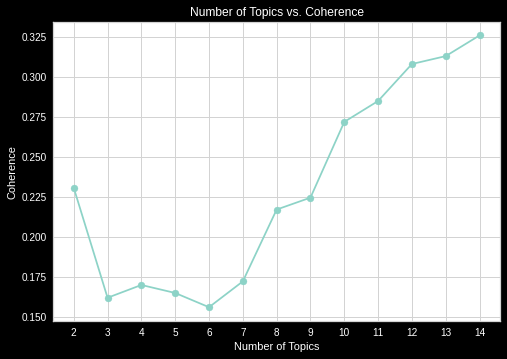

In [ ]:
plot_coherence_graph(coherence)

0


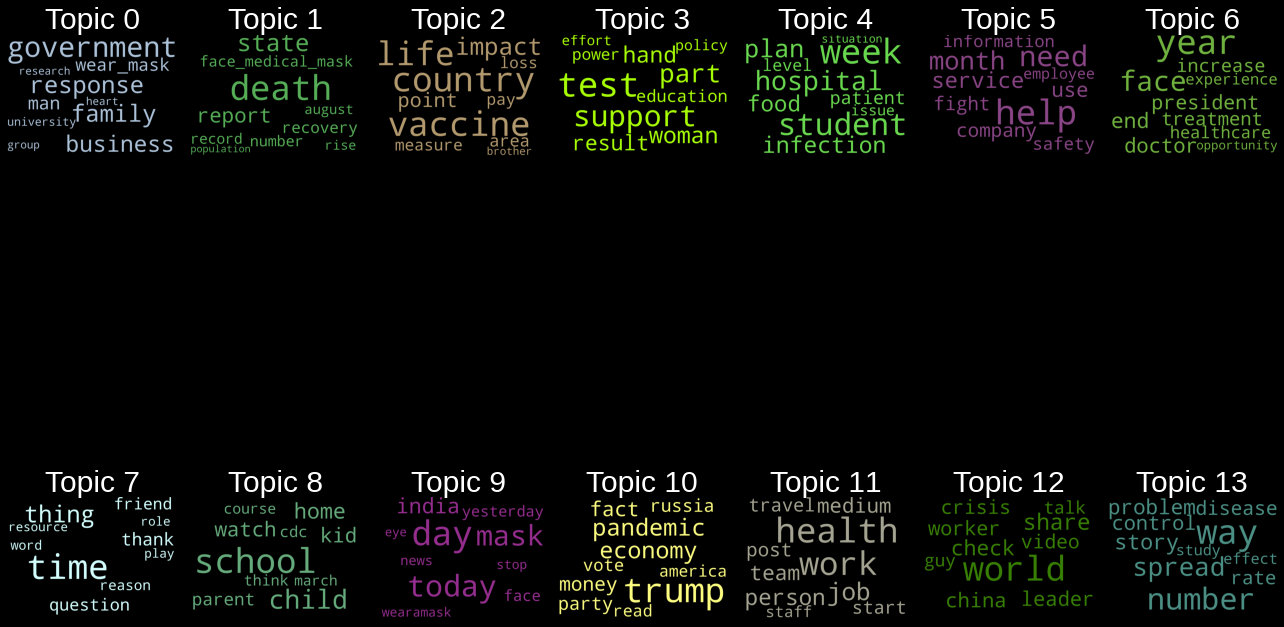

In [ ]:
best_k = 14
index = best_k -2
word_clouds_words_per_topic(lda_models[index], best_k)

In [ ]:
# show topics for the 'k' selected from the coherence graph  
show_topics(lda_models[index], best_k)

Topic 0:
0.020*"government" + 0.015*"student" + 0.013*"risk" + 0.010*"child" + 0.010*"support" + 0.008*"time" + 0.008*"help" + 0.007*"job" + 0.007*"part" + 0.007*"university" + 0.006*"business" + 0.006*"impact" + 0.006*"need" + 0.006*"health" + 0.006*"worker" + 0.006*"system" + 0.006*"crisis" + 0.006*"today" + 0.005*"woman" + 0.005*"family"

Topic 1:
0.021*"mask" + 0.020*"world" + 0.019*"trump" + 0.010*"president" + 0.010*"life" + 0.009*"year" + 0.008*"face_medical_mask" + 0.008*"person" + 0.007*"election" + 0.007*"china" + 0.006*"health" + 0.006*"care" + 0.006*"man" + 0.006*"restriction" + 0.005*"thank" + 0.005*"team" + 0.005*"god" + 0.005*"heart" + 0.005*"count" + 0.005*"nation"

Topic 2:
0.019*"face" + 0.018*"thing" + 0.017*"help" + 0.011*"mask" + 0.008*"time" + 0.007*"hand" + 0.006*"fact" + 0.006*"fight" + 0.006*"let" + 0.006*"check" + 0.006*"money" + 0.006*"vaccine" + 0.005*"community" + 0.005*"talk" + 0.005*"level" + 0.005*"wearing_mask" + 0.005*"lockdown" + 0.004*"canada" + 0.00

### Running LDA with best hyperparameters 

In [ ]:
# WARNING: time consuming
best_k = 13
best_passes = 10 
best_iterations = 100 
best_chunksize = 10000

lda_model = models.LdaModel(corpus, num_topics=best_k, id2word = id2word, passes=best_passes,\
                    iterations=best_iterations, chunksize = best_chunksize, 
                    eval_every = None, random_state = 100)

### Exploration of LDA results 

#### Utils

In [ ]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        if i % 1000 == 0:
          print("doc:", i)
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


def dominant_topic_per_tweet(df_topic_sents_keywords):
  df_dominant_topic = df_topic_sents_keywords.reset_index()
  df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
  df_dominant_topic.set_index('Document_No', inplace=True)
  return df_dominant_topic


def most_representative_sentence_per_topic(df_topic_sents_keywords, max_col_width = 100): 
  pd.options.display.max_colwidth = max_col_width

  sent_topics_sorteddf_mallet = pd.DataFrame()
  sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

  for i, grp in sent_topics_outdf_grpd:
      sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                              grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                              axis=0)

  # Reset Index    
  sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

  # Format
  sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

  return sent_topics_sorteddf_mallet

def cluster_wordcount(lda_model, bigrams_trigrams, k=10, mode='show'):
  # Prepare data
  topics = lda_model.show_topics(formatted=False, num_topics = k)
  data_flat = [w for w_list in bigrams_trigrams for w in w_list]
  counter = Counter(data_flat)

  out = []
  for i, topic in topics:
      for word, weight in topic:
          out.append([word, i , weight, counter[word]])

  df_word_counts = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count']) 
  cols = [color for name, color in mcolors.TABLEAU_COLORS.items()] +  [color for name, color in mcolors.TABLEAU_COLORS.items()]    
  for i in range(len(df_word_counts.topic_id.unique())):
      fig, ax = plt.subplots(1,1, figsize=(10,6))
      ax.bar(x='word', height="word_count", data=df_word_counts.loc[df_word_counts.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
      ax_twin = ax.twinx()
      ax_twin.bar(x='word', height="importance", data=df_word_counts.loc[df_word_counts.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
      # Y-axes
      ax.set_ylabel('Word Count', color=cols[i], size = 15)
      y_max_importance = max(df_word_counts[df_word_counts.topic_id==i].importance) + 0.005
      y_max_wc = max(df_word_counts[df_word_counts.topic_id==i].word_count) + 500
      ax_twin.set_ylim(0, y_max_importance); ax.set_ylim(0, y_max_wc)
      # X-axis
      ax.set_xticklabels(df_word_counts.loc[df_word_counts.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right', size = 15)
      # General
      ax.set_title('Topic ' + str(i), color=cols[i], fontsize=16)
      ax.tick_params(axis='y', left=False, size = 15)
      ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')
      fig.tight_layout(w_pad=2) 
      if mode == 'show':
        plt.show()
      elif mode == 'save': 
        plt.savefig('8_clusters_keywords'+str(i+1))
      else: 
        print("Error!")


In [ ]:
#HIGHLY TIME CONSUMING!
%%time
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=bigrams_trigrams)



In [ ]:
with open('df_topic_sents_keywords.pickle', 'wb') as handle:
    pickle.dump(df_topic_sents_keywords, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('df_topic_sents_keywords.pickle', 'rb') as handle:
    df_topic_sents_keywords = pickle.load(handle)

#### **Dominant topic and its percentage contribution in each document**
Here is the main topic of each tweet and the percentage of that topic within the tweet.

Observing the texts and the topic associated with the text, we can say that the analysis carried out by LDA turns out to be satisfactory.

Furthermore, the texts broadly confirm that the topics we identified in the previous section have been interpreted fairly correctly.

An example: 

    Document_No Dominant_Topic	Topic_Perc_Contrib	Keywords	Text
      			
      0	9.0	0.5188	day, today, week, india, death, change, quaran...	[smelled, scent, hand_sanitizers, today, past,...
      1	10.0	0.2692	trump, fact, money, situation, election, vote,...	[trump, never, claimed, hoax, claim, effort]
      2	7.0	0.2693	time, thing, hospital, thank, question, county...	[gift, appreciation, simple, thing]
      3	9.0	0.6154	day, today, week, india, death, change, quaran...	[july, medium, bulletin, novel]
      4	1.0	0.4154	death, number, state, person, face_medical_mas...	[death, continue, rise, bad, politician, busin...
      5	12.0	0.2693	world, crisis, care, community, impact, woman,...	[wear, face_covering, shopping, includes, visi...
      6	11.0	0.3590	health, work, news, risk, job, medium, problem...	[praying, good, health, recovery, covidpositive]
      7	10.0	0.4864	trump, fact, money, situation, election, vote,...	[pope, god, prophet, sadhu, sundar, selvaraj, ...
      8	8.0	0.4154	school, child, home, look, kid, education, saf...	[response, cancel, compartment, exa]
      9	5.0	0.5126	help, month, business, spread, president, need...	[order, logo, graphicdesigner, logodesign, log...
      10	1.0	0.3590	death, number, state, person, face_medical_mas...	[protect, real, number, climbing, fast, contin..

In [ ]:
df_dominant_topic = dominant_topic_per_tweet(df_topic_sents_keywords)
df_dominant_topic.head(20)

Dominant_Topic  ...                                                                                  Text
Document_No                  ...                                                                                      
0                       9.0  ...                    [smelled, scent, hand_sanitizers, today, past, think, intoxicated]
1                      10.0  ...                                          [trump, never, claimed, hoax, claim, effort]
2                       7.0  ...                                                   [gift, appreciation, simple, thing]
3                       9.0  ...                                                       [july, medium, bulletin, novel]
4                       1.0  ...                              [death, continue, rise, bad, politician, business, want]
5                      12.0  ...          [wear, face_covering, shopping, includes, visit, local, community, pharmacy]
6                      11.0  ...                                      [praying, good, health, recovery, covidpositive]
7                      10.0  ...                  [pope, god, prophet, sadhu, sundar, selvaraj, watch, hurricanehanna]
8                       8.0  ...                                                  [response, cancel, compartment, exa]
9                       5.0  ...  [order, logo, graphicdesigner, logodesign, logodesinger, icon, minimalist, abstract]
10                      1.0  ...                                    [protect, real, number, climbing, fast, continent]
11                      1.0  ...     [nagaland, police, awareness, city, tower, junction, dimapur, keepsocialdistance]
12                      9.0  ...                 [july, update, tamilnadu, discharge, people, tested, actice, chennai]
13                     12.0  ...                                                     [second_wave, flanders, homework]
14                      8.0  ...                                            [darkest, moment, focus, light, aristotle]
15                     11.0  ...       [update, infection_rate, following, natural, curve, expert, predicted, initial]
16                      5.0  ...                         [good, patriot, call, volunteer, election, judge, poll, open]
17                     11.0  ...              [image, list, source, careful, overall, risk, dying, statistic, related]
18                      0.0  ...   [comprehensive, review, wash, analysis, key, way, wash, help, reduce, transmission]
19                      7.0  ...                                                                   [holy, water, time]

[20 rows x 4 columns]

#### **The most representative sentence for each topic**
We have extracted the text that best represents each topic.
It is interesting to focus on the following:
- **Topic 11**: for this topic, which we have previously identified as "**Work issue**", it is interesting to observe that the representative text contains words such as *depression*, *stress*, *die*, *problem*. This makes us think, in the context of our analysis, that in the period of the pandemic there was a close correlation between the fear of losing a job and stress / depression.
- **Topic 2**: from the observation of the representative text, our interpretation of **Topic 2** is also correct, identified as "**Russia's first vaccine announced in August 2020**". There is even the word *sputnikv* which is the specific name of the vaccine in question.
- **Topic 10**: from the observation of the representative text, our interpretation of **Topic 10** is also correct, identified as "**U.S.A. elections**". It's very interesting the fact that, in the Representative Text,  4 words out of 9 are "**maga**" which means **Make America Great Again**. 
- **Topic 7**: from the observation of the representative text, our interpretation of **Topic 7** is also correct, identified as "**The challenge of hospitals against time. The importance of taking action, gratitude for the things done by the hospitals.**". In particular, there many words that coincide with "**folded_hand**", which is the translation of the following emoji: 🙏; this emoji is commonly used to express **gratitude**.  
- **Topic 6**: in the previous section, by looking only at the Word Clouds, we would not be able to extract a suitable topic for those words. Here, from the observation of the Representative Text, we can observe that the following words are present: *idc (i don't care), face, steam, nose, iamnotokaywiththis (i am not okay with this)*. "Face", "Steam" and "Nose" could be related to the fact that in order to prevent the spread of the coronavirus through the air emitted from nose we need to wear a mask. The combination of the concept just explained and the words "idc" and "iamnotokaywiththis" could be related to **COVID19 deniers** (people who do not accept the existence of the COVID19). Another hypothesis could be linked to the fact that at that time Netflix removed the TV series "IAmNotOkayWithThis" due to the circumstances related to COVID. News of 21 August 2020: [‘The Society’ & ‘I Am Not Okay With This’ Canceled By Netflix](https://deadline.com/2020/08/the-society-i-am-not-okay-with-this-canceled-netflix-covid-related-no-season-2-1203020036/)
- **Topic 3**: observing the text related to this topic, words like *antigen*, *test*, *conducted*, *doctor* emerge; therefore it seems that the topic is slightly different from that identified by us and that it is therefore more linked to the "**Administration of rapid tests for monitoring the epidemic**".
- **Topic 12**: also in this case it seems that the topic we previously identified is slightly wrong, as by observing the representative text there are words like "gender", "inequality", "women". Therefore, it appears that this topic is more akin to "**Gender Inequality**".


For all other topics it is not possible to conduct a meaningful analysis as the words that have emerged do not seem very sensible.

Probably, in light of what we got here, we could have also removed words like 'idc' (I don't care) or 'rlr' (real life raw) in preprocessing; unfortunately these things cannot be noticed from an initial analysis.

In [ ]:
sent_topics_sorted = most_representative_sentence_per_topic(df_topic_sents_keywords, max_col_width = 200)
sent_topics_sorted.head(15)

Topic_Num  ...                                                                                                                                                                                      Representative Text
0         0.0  ...                                                                                                                                      [wear, wear_mask, absence, evidence, evidence, absence, word, shou]
1         1.0  ...                                                                                                                                                         [dnc, usa, bra, ind, saf, mex, col, record, dnc]
2         2.0  ...                                                                                                                              [russia, begin, production, vaccine, production, russia, vaccine, sputnikv]
3         3.0  ...                                                                                                         [team, rlr, bhandava, bbmp, doctor, conducted, rapid, antigen, test, resident, doddamma, temple]
4         4.0  ...                                                                                                                       [ice, prefer, food, cold, hot, tuff, viking, never, stop, innovating, fit, inside]
5         5.0  ...                                                                                           [station, personnel, led, pcpt, julius, luis, station, commander, conducted, barangay, visitation, monitoring]
6         6.0  ...                                                                     [idc, going, follow, face, steam, nose, face, steam, nose, face, steam, nose, iamnotokaywiththis, dynamite, golfgate, dynamiteparty]
7         7.0  ...                                                  [unite, folded_hand, United, States, folded_hand, speaker, high, volume, speaker, high, volume, speaker, high, volume, charlie, chaplin, thursdayvibes]
8         8.0  ...                                                                                                                                [interested, hearing, opinion, concern, school, concern, teacher, parent]
9         9.0  ...  [bikers, skeered, smiling_face_sunglass, smiling_face_sunglass, smiling_face_sunglass, smiling_face_sunglass, smiling_face_sunglass, smiling_face_sunglass, smiling_face_sunglass, smiling_face_sung...
10       10.0  ...                                                                                                                              [waiting, tweet, like, maga, maga, maga, landslidevictory, maga, landslide]
11       11.0  ...                                                                                                                                [hunger, stress, depression, health, problem, people, die, problem, call]
12       12.0  ...                                                                                                                       [crisis, kind, impact, woman, girl, differently, gender, inequality, spoke, woman]

[13 rows x 4 columns]

#### **Word Counts of Topic Keywords**
We want to understand which words have had a greater weight in determining the topic. 

The weight associated with a word indicates how significant that word is to distinguish that topic from the others.

In particular, it is interesting to note that in some cases LDA inserts words that it considers most significant within the topic, although these are not the most frequent words. This is one of the strengths of LDA. 

We have analyzed the various topics by looking at both the Word Clouds and the graphs that show the weight of the words together with their occurrence in the texts and we have identified these clusters:

- **Topic 0**: "**Aspects related to the COVID19 crisis**". The most weighted word coincides with the most frequent word for this topic: "**mask**". We know that the **mask** is the symbolic element of this pandemic.
- **Topic 1**:  "**Number of deaths and use of the medical mask**". **death**, **number** and **person** are both the most frequent and weighted words for this topic. 
- **Topic 2**: "**Russia's first vaccine announced in August 2020**". The most weighted words are: **vaccine**, **country**, **life**. 
- **Topic 3**: during a first analysis we had identified **Issue of hospitals/doctors and people at risk, suffering from other diseases (such as heart disease)**. By looking at keywords and most representative sentence for each topic we changed it into **Administration of rapid tests for monitoring the epidemic"**. This is reasonable since the most weighted words are **test**, **report**, **support**.  
- **Topic 4**: **Students, college, infection** is the topic indetified through the Word Clouds. The most weighted words are **year**, **student**, **plan**. In reality, the words identified as keywords for this topic do not seem to be very related to each other so, even if we look at the words that have had the most weight for LDA, we are unable to clearly confirm the hypothesis regarding our interpretation of this topic.
- **Topic 5**: **Topics related to the economy in general**. If we combine the most frequent and the most weighted word, we obtain "need help". It seems that our hypothesis for this topic is correct. 
- **Topic 6**: As we said in the previous sections, is difficult to individuate a topic. 
- **Topic 7**:  **The challenge of hospitals against time. The importance of taking action, gratitude for the things done by the hospitals.** The most weighted words are **time**, **thing**, **hospital**. 
- **Topic 8**: **School and Education of kids at home**. The most weighted keywords are **school**, **child**, **home**. 
- **Topic 9**: **In August, India recorded the highest number of COVID19 cases since the start of the pandemic and a very high number of deaths per day**. The most weighted words are **day**, **today**, **week**, **india**, **death**. 
- **Topic 10**: **U.S.A Elections**. The most weighted words are **trump**, **fact**, **money**, **situation**, **election**. 
- **Topic 11**: **Work issue: risk in the workplace, risk of losing your job**. The most weighted words are **health**, **work**, **news**, **risk**, **job**. 
- **Topic 12**: From the anlysis of the weights of the keywords we are unable to confirm the hypotehsis that we made in the previous section (**Gender Inequality**). 

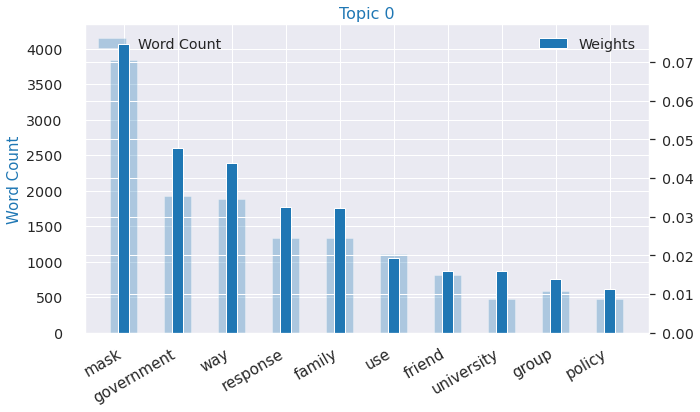

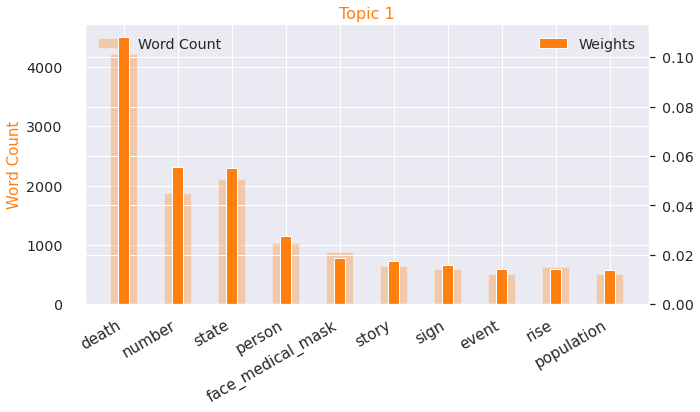

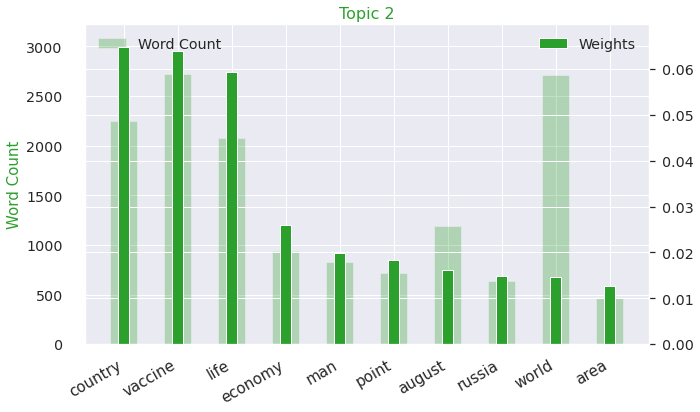

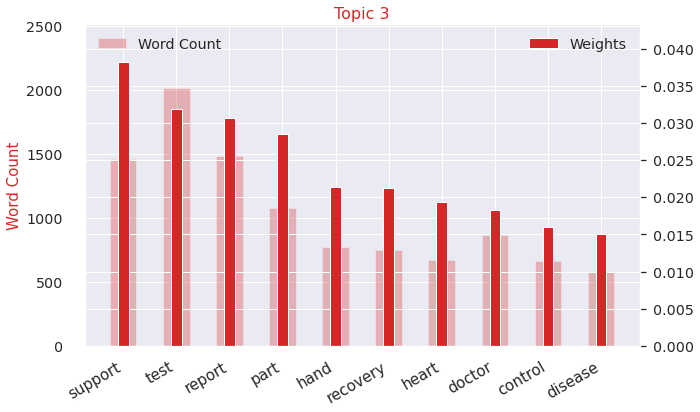

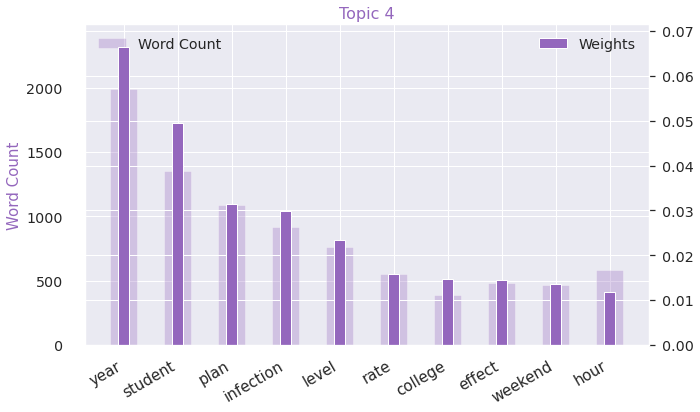

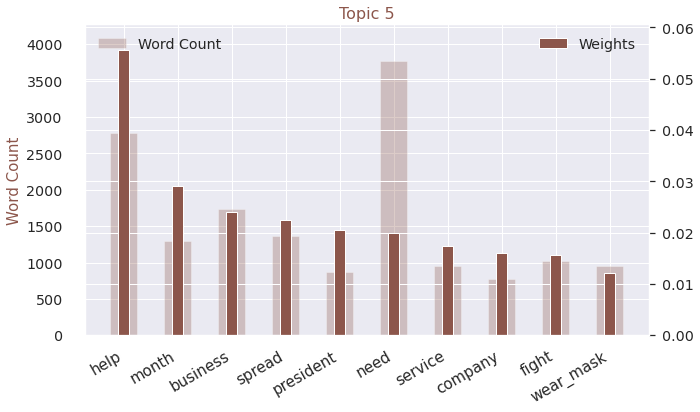

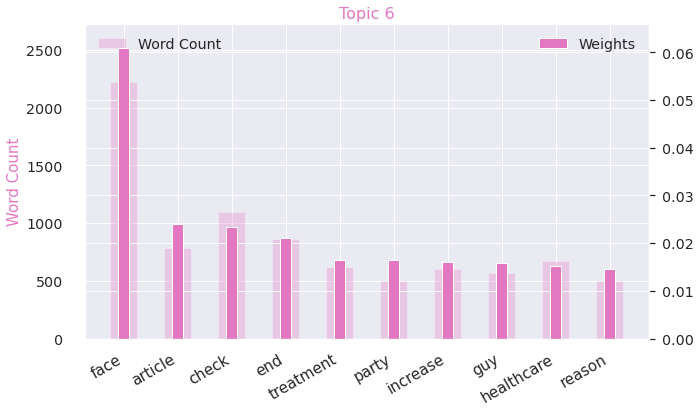

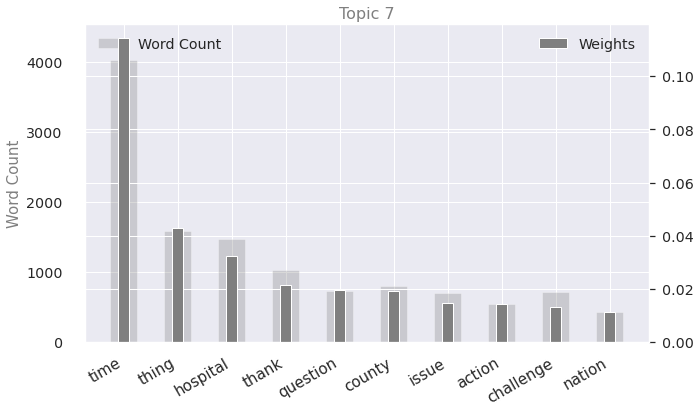

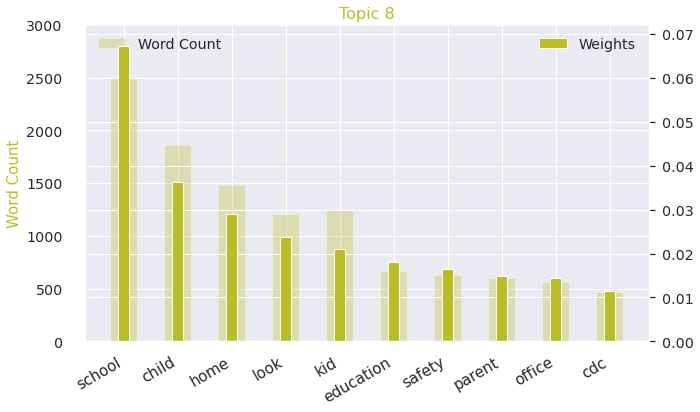

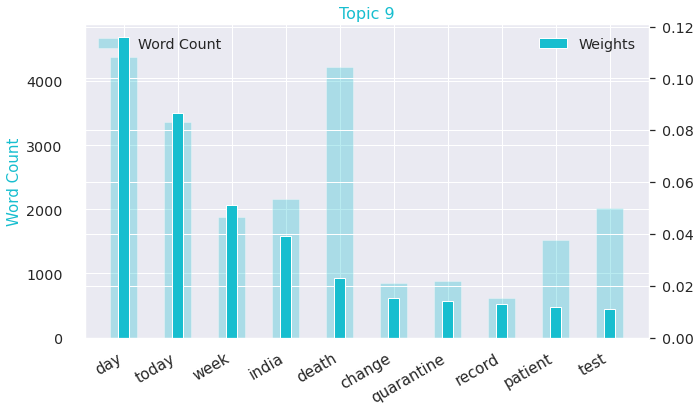

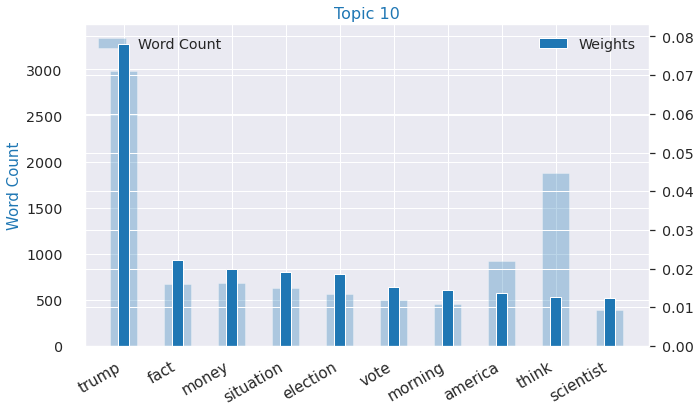

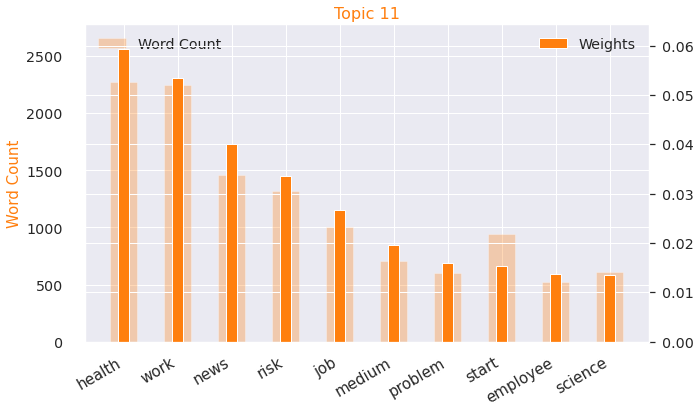

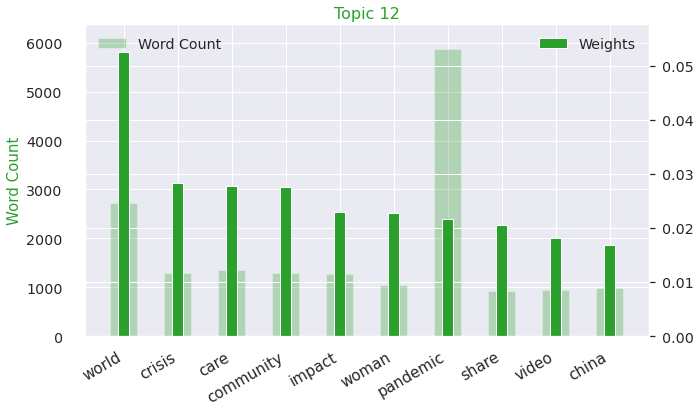

In [ ]:
cluster_wordcount(lda_model, bigrams_trigrams, k = best_k, mode = 'save')

# Labelling
In this section we present the different strategies we have decided to adopt to go and assign the label 'depressed' to each tweet.

In general, regardless of the strategy, we have assigned:
- `0` to indicate `not depressed`
- `1` to indicate `depressed`

The strategies we have adopted are the following:
- **TWINT**: through the use of TWINT (an advanced Twitter scraping tool written in Python that allows for scraping Tweets from Twitter profiles without using Twitter's API), we were able to extract different datasets based on keywords related to the theme of depression. Based on the analysis of these datasets we were able to create what we called a `depression_list` that we used to label the tweets. Please, see the **TWINT Section** for further details. 
- **VADER**: through the use of VADER-Sentiment Analyzer we were able to label each tweet by studying the polarities assigned by VADER to each tweet. In particular, tweets with positive polarity were labeled as `not_depressed` (positive sentiment), while tweets with negative polarity were labeled as `depressed` (negative sentiment). Obviously behind this reasoning there is a basic knowledge linked to the fact that in general the condition of depression is associated with a feeling socially and globally evaluated as negative. Please, see the **VADER Section** for further details. 
- **NRCLex**: through the use of NRCLex we measured emotional affect from a body of text. Affect dictionary contains approximately 27,000 words, and is based on the National Research Council Canada (NRC) affect lexicon (see link below) and the NLTK library's WordNet synonym sets. So we were able to analyze the emotions retrieved by NRCLex in our tweets and to mark as `depressed` those tweets affected by negative top-emotions. We considered as negative top-emotions `fear` and `sadness` (because `negative` is too much general to be directly linked with the theme of depression). Please, see the **NRCLex Section** for further details. 



## TWINT
Through the use of TWINT (an advanced Twitter scraping tool written in Python that allows for scraping Tweets from Twitter profiles without using Twitter's API), we were able to extract different datasets based on keywords related to the theme of depression. 

- All the datasets have been extracted by taking the tweets written in the period from 01/01/2019 to 01/05/2019. 
  - We chose to use a period prior to the evolution of COVID19 in the world, so that this research produced the most objective results possible and did not overlap with our analysis. 
- This research was done incrementally
  - We started with a word (depressed)
  - We extracted the tweets of the chosen period characterized by this word 
  - Through the analysis of the Word Cloud of the extracted dataset we extracted one of the most frequent words (anxious) 
  - We then repeated the download of the dataset for this new word and proceeded with the same technique for the extraction of a third term and so on. 
  - Note that we scraped only tweets written in English
  
- In particular, we finally extracted **5 different datasets** referring to the words `depressed`, `anxious`, `stressed`, `sad`, `lonely`. 
- We applied our TextPreprocessing - Pipeline 1 to these new datasets 
- We compared the Word Clouds of the 5 datasets and carried out analyzes based on the most frequent terms in and among the various datasets in order to extract the `depression_list`: a list of terms related to the theme of depression. 
- Finally, we used this list to analyze our tweets:
  - if the tweet contains at least one word of the depression_list it is labeled as `depressed (1)`
  - if the tweet does not contain any word of the depression_list it is labeled as `not_depressed (0)`


-------

***NOTE***: We decided to select adjectives instead of nouns considering that when someone want to communicate something on social networks, usually refers to himself with adjectives. Examples: "I am depressed", "I feel anxious". 

-------

### Datasets extraction
It may take a while.


#### 1 - "depressed" 

In [ ]:
!twint -s “depressed” --limit 30000 --lang en --since 2018-01-01 --until 2019-05-01 -o df  --json 

In [ ]:
df_depressed = pd.read_json("/content/df/tweets.json", lines=True)

In [ ]:
lang_cnt = Counter(df_depressed.language)
print(lang_cnt)

In [ ]:
eng_df_depressed = df_depressed[df_depressed.language == 'en']
lang_cnt = Counter(eng_df_depressed.language)
print(lang_cnt)

#### 2 - "anxious" 

In [ ]:
!twint -s “anxious” --limit 30000 --lang en --since 2018-01-01 --until 2019-05-01 -o df  --json 

In [ ]:
df_anxious = pd.read_json("/content/df/tweets.json", lines=True)

In [ ]:
lang_cnt = Counter(df_anxious.language)
print(lang_cnt)

In [ ]:
eng_df_anxious = df_anxious[df_anxious.language == 'en']
lang_cnt = Counter(eng_df_anxious.language)
print(lang_cnt)

#### 3 - "stressed" 

In [ ]:
!twint -s “stressed” --limit 30000 --lang en --since 2018-01-01 --until 2019-05-01 -o df  --json --hide-output

In [ ]:
df_stress = pd.read_json("/content/df/tweets.json", lines=True)

In [ ]:
lang_cnt = Counter(df_stress.language)
print(lang_cnt)

In [ ]:
eng_df_stress = df_stress[df_stress.language == 'en']
lang_cnt = Counter(eng_df_stress.language)
print(lang_cnt)

#### 4 - "sad" 

In [ ]:
!twint -s “sad” --limit 30000 --lang en --since 2018-01-01 --until 2019-05-01 -o df  --json --hide-output

In [ ]:
df_sad = pd.read_json("/content/df/tweets.json", lines=True)

In [ ]:
lang_cnt = Counter(df_sad.language)
print(lang_cnt)

In [ ]:
eng_df_sad = df_sad[df_sad.language == 'en']
lang_cnt = Counter(eng_df_sad.language)
print(lang_cnt)

#### 5 - "lonely" 

In [ ]:
!twint -s “lonely” --limit 30000 --lang en --since 2018-01-01 --until 2019-05-01 -o df  --json --hide-output

In [ ]:
df_lonely = pd.read_json("/content/df/tweets.json", lines=True)

In [ ]:
lang_cnt = Counter(df_lonely.language)
print(lang_cnt)

In [ ]:
eng_df_lonely = df_lonely[df_lonely.language == 'en']
lang_cnt = Counter(eng_df_lonely.language)
print(lang_cnt)

### Text Preprocessing - new Datasets 

In [ ]:
# WARNING: time consuming!
%%time 
ct = CleanText()
eng_df_depressed['tweet'] = ct.fit(eng_df_depressed.tweet).transform(eng_df_depressed.tweet)
eng_df_anxious['tweet'] = ct.fit(eng_df_anxious.tweet).transform(eng_df_anxious.tweet)
eng_df_stress['tweet'] = ct.fit(eng_df_stress.tweet).transform(eng_df_stress.tweet)
eng_df_sad['tweet'] = ct.fit(eng_df_sad.tweet).transform(eng_df_sad.tweet)
eng_df_lonely['tweet'] = ct.fit(eng_df_lonely.tweet).transform(eng_df_lonely.tweet)



In [ ]:
eng_df_depressed['tweet'].head()

In [ ]:
eng_df_anxious['tweet'].head()

In [ ]:
eng_df_stress['tweet'].head()

In [ ]:
eng_df_sad['tweet'].head()

In [ ]:
eng_df_lonely['tweet'].head()

### Word Clouds

In [ ]:
# Word Cloud
from wordcloud import WordCloud, STOPWORDS
def plot_wordcloud(corpus):
  wc = WordCloud(width = 3000, 
                            height = 2000, 
                            collocations=False, 
                            stopwords = STOPWORDS, 
                            random_state = 42,
                            colormap = 'gist_rainbow').generate(" ".join(corpus))
  # Plot
  plt.figure(figsize=(20,20))
  plt.axis("off")
  plt.imshow(wc) 
  plt.title('WordCloud Tweets');

In [ ]:
corpus_depressed = eng_df_depressed["tweet"].tolist()

In [ ]:
plot_wordcloud(corpus_depressed)

In [ ]:
corpus_anxious = eng_df_anxious["tweet"].tolist()

In [ ]:
plot_wordcloud(corpus_anxious)

In [ ]:
corpus_stress = eng_df_stress["tweet"].tolist()

In [ ]:
plot_wordcloud(corpus_stress)

In [ ]:
corpus_sad = eng_df_sad["tweet"].tolist()

In [ ]:
plot_wordcloud(corpus_sad)

In [ ]:
corpus_lonely = eng_df_lonely["tweet"].tolist()

In [ ]:
plot_wordcloud(corpus_lonely)

### Depression-list creation
Analysis of the most frequent words in and among Word Clouds:
- In the Word Clouds of `stress` and `anxious` we find the words `depressed` / `depression`,  so this makes us think that these 3 words are good candidates for `depression_list`; vice versa we find this link also between `depressed` and `stressed` because both in the Word Clouds of `depressed` and `anxious` there is the word `stressed` 
- In the Word Cloud of  `depressed` we find `depress` and `depression ` which we add to the `depression_list`
- In the Word Cloud of `depressed` emerge words such as `alone`, `cry`; these words also emerge in the Word Clouds of `sad` and `anxious` and this make us think that there exists a link between `sad` - `depression` - `anxious` 
- In the Word Clouds of `lonely` and `sad` we find in both the word `cry`
- In all Word Cloud we find negative words such as `nothing`, `never`. Many scientific articles correlate the use of these two terms to depression, so we're going to add them to the `depression_list`. (https://www.thehealthy.com/mental-health/depression/words-phrases-sign-depression/)
- In all our Word Clouds we find the word `face` in the sense of "fronting", but we will not put it in the `depression_list` due to the unfortunate combination with `face mask`; otherwise we would have a lot of false positives. However, if there had not been `face mask` (so if the topic of the target tweets had been different from the COVID19) we would have put it.
- In conclusion,  mainly there seems to be a fairly important correlation between the words that we highlighted above, that lead to depression.

So, our `depression_list` is composed as follows: 
      
      [depression, depressed, depress, anxious, anxiety, stress, stressed, cry, alone, lonely, never, nothing, sad]

<img src="https://drive.google.com/uc?id=11x-1NwA7pvggSWfmRKEyv1W-OkRO_X9x" style="float: right;" width="700">


In [ ]:
depression_list = ['depression', 'depressed', 'depress', 'anxious', 'anxiety', 
                   'stress', 'stressed', 'cry', 'alone', 'lonely', 'never', 
                   'nothing', 'sad']

### Labelling
In this section we label our tweets following the strategy that we presented at the beginning.

We report a short reminder of the strategy here: 
  - if the tweet contains at least one word of the depression_list it is labeled as `depressed (1)`
  - if the tweet does not contain any word of the depression_list it is labeled as `not_depressed (0)`

In [ ]:
# uncomment this cell if you want to show the full text of each tweet
# pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [ ]:
df['twint'] = df['clean_text'].apply(lambda x:int(1) if any(ele in x.split() for ele in depression_list) else int(0))

In [ ]:
df[df.twint == 1].shape[0]

3004

In [ ]:
df[df.twint == 1].clean_text.head(100)

1                trump never claimed wa hoax claim effort
28        feeling little anxious seems detracted everyone
56      saturdayvibes current situation call awareness...
57      everyone fight covered major disaster nothing ...
70      shout earth hand worst reaction emergency I ev...
                              ...                        
3843    month later still national plan slow spread no...
3876    never love anything cannot love back good morn...
3946    man walk oxford street wearing nothing face ma...
3973    pumped medium outlet I never know hopefully wa...
4000    stop making people fearful let get drinking be...
Name: clean_text, Length: 100, dtype: object

In [ ]:
df[df.twint == 0].shape[0]

125444

## VADER
VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. 

VADER uses a combination of a sentiment lexicon (which is a list of lexical features e.g., words) which are generally labelled according to their semantic orientation as either positive or negative.

VADER has been found to be quite successful when dealing with social media texts, NY Times editorials, movie reviews, and product reviews. This is because VADER not only tells about the Positivity and Negativity score but also tells us about how positive or negative a sentiment is.

VADER analyses sentiments primarily based on certain key points:
- **Punctuation**: The use of an exclamation mark(!), increases the magnitude of the intensity without modifying the semantic orientation. For example, “The food here is good!” is more intense than “The food here is good.” and an increase in the number of (!), increases the magnitude accordingly.
- **Capitalization**: Using upper case letters to emphasize a sentiment-relevant word in the presence of other non-capitalized words, increases the magnitude of the sentiment intensity. For example, “The food here is GREAT!” conveys more intensity than “The food here is great!
- **Degree modifiers**: Also called intensifiers, they impact the sentiment intensity by either increasing or decreasing the intensity. For example, “The service here is extremely good” is more intense than “The service here is good”, whereas “The service here is marginally good” reduces the intensity.
- **Conjunctions**: Use of conjunctions like “but” signals a shift in sentiment polarity, with the sentiment of the text following the conjunction being dominant. “The food here is great, but the service is horrible” has mixed sentiment, with the latter half dictating the overall rating.
- **Preceding Tri-gram**: By examining the tri-gram preceding a sentiment-laden lexical feature, we catch nearly 90% of cases where negation flips the polarity of the text. A negated sentence would be “The food here isn’t really all that great”.
- **Emojis, Slangs, and Emoticons**: VADER performs very well with emojis, slangs, and acronyms in sentences. 

The Compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1(most extreme negative) and +1 (most extreme positive)

**Labeling Strategy**

After computing the score with VADER Sentiment Analyzer we: 
- label as `depressed` (1) if $compound\_score <0$
- label as `not_depressed` (0) if $compound\_score \geq 0$


In [ ]:
analyzer = SentimentIntensityAnalyzer()

In [ ]:
df['vader'] = df['VADER_clean_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

In [ ]:
df[['VADER_clean_text', 'twint', 'vader']].head(10)

VADER_clean_text  twint   vader
0  If I smelled the scent of hand sanitizers toda...      0  0.4939
1  Trump never once claimed  COVID19 was a hoax. ...      1 -0.2732
2  The one gift  COVID19 has give me is an apprec...      0  0.7351
3  25 July : Media Bulletin on Novel  CoronaVirus...      0  0.3182
4   coronavirus  covid19 deaths continue to rise....      0 -0.4976
5  You now have to wear face coverings when out s...      0  0.0000
6  Praying for good health and recovery of   .  c...      0  0.6597
7  POPE AS GOD - Prophet Sadhu Sundar Selvaraj. W...      0  0.4278
8  49K+ Covid19 cases still no response from     ...      0 -0.2263
9  Order here:    logo  graphicdesigner  logodesi...      0  0.0000

In [ ]:
positive_num = len(df[df['vader'] >=0.00])
negative_num = len(df[df['vader']<-0.00])
positive_num, negative_num

(91619, 36829)

### Labelling

**Labeling Strategy**

After computing the score with VADER Sentiment Analyzer we: 
- label as `depressed` (1) if $compound\_score <0$
- label as `not_depressed` (0) if $compound\_score>=0$

In [ ]:
# map positive values to positive sentiment and negative values to negative sentiment
# if the sentiment is positive we label the tweet as 'non-depressed" (0)
# if the sentiment is negative we label the tweet as 'depressed' (1)
df['vader']= df['vader'].map(lambda x:int(0) if x>=0.00 else int(1) )

In [ ]:
df.vader.head()

0    0
1    1
2    0
3    0
4    1
Name: vader, dtype: int64

In [ ]:
df[df.vader == 1].clean_text.head()

1              trump never claimed wa hoax claim effort
4     death continue rise almost bad ever wa politic...
8        k still response please cancel compartment exa
14        darkest moment must focus see light aristotle
17    image list source careful overall risk dying s...
Name: clean_text, dtype: object

## NCRLex
Through the use of NRCLex we measure emotional affect from a body of text. Affect dictionary contains approximately 27,000 words, and is based on the National Research Council Canada (NRC) affect lexicon (see link below) and the NLTK library's WordNet synonym sets. 

So we were able to analyze the emotions retrieved by NRCLex in our tweets and to mark as `depressed` those tweets affected by negative top-emotions.

Let's take a look at how NRCLex-python module works. 



1.   Assign input text (each tweet in our case)
2.   Create NRCLex object for each input text.
3.   Apply methods to classify emotions.
    <img src="https://drive.google.com/uc?id=1y3uJjkgwTm7V2-21dc9Uh-V1ETGzTRtL" style="float: right;" width="300">

4. Among all of these methods we use 'top-emotions' to return the highest emotions of each tweets. 
5. We iterate among the dataframe containing NRCLex results for each tweet and if `top_emotions` list of a tweet contains an emotion of our `depression_list` we mark it as `depressed` (1) (0 otherwise). 

--------------

**Affects**

Emotional affects measured include the following:

- fear
- anger
- anticipation
- trust
- surprise
- positive
- negative
- sadness
- disgust
- joy

---------

**Depression List** 

 We considered as negative top-emotions `fear` and `sadness` (because `negative` is too much general to be directly linked with the theme of depression). 

----------------
***NOTE***: In the text preprocessing section we used the Lemmatization technique to find right matches with the words in NRC Lexicon, since NRC lexicon contains lemmatized terms. 

------------


### NRCLex Methods Overview

In [ ]:
text = 'I am so sad toady and so angry!'
text_object = NRCLex(text)

#Return affect list.

print('Affect list:\n',text_object.affect_list)

#Return affect dictionary.

print('Affect dict:\n',text_object.affect_dict)


#Return raw emotional counts.

print('Raw emotional score:\n',text_object.raw_emotion_scores)


#Return highest emotions.

print('Top emotions:\n',text_object.top_emotions)

#Return affect frequencies.

print('Affect frequencies:\n',text_object.affect_frequencies)

Affect list:
 ['anger', 'disgust', 'negative']
Affect dict:
 {'angry': ['anger', 'disgust', 'negative']}
Raw emotional score:
 {'anger': 1, 'disgust': 1, 'negative': 1}
Top emotions:
 [('anger', 0.3333333333333333), ('negative', 0.3333333333333333), ('disgust', 0.3333333333333333)]
Affect frequencies:
 {'fear': 0.0, 'anger': 0.3333333333333333, 'anticip': 0.0, 'trust': 0.0, 'surprise': 0.0, 'positive': 0.0, 'negative': 0.3333333333333333, 'sadness': 0.0, 'disgust': 0.3333333333333333, 'joy': 0.0}


### Labelling

In [ ]:
%%time
nrclex_df = {
    'emotions': {},
    'top_emotions': {},
    'affect_frequencies' : {},
    'affect_dict': {}}

#Instantiate text object (for best results, 'text' should be unicode).
for i, text in enumerate(df.clean_text):
  text_object = NRCLex(text)
  nrclex_df['emotions'][i] =  text_object.affect_list
  nrclex_df['affect_dict'][i] =  text_object.affect_dict
  nrclex_df['top_emotions'][i] =  text_object.top_emotions
  nrclex_df['affect_frequencies'][i] = text_object.affect_frequencies

nrclex_df = pd.DataFrame(nrclex_df)

CPU times: user 34.2 s, sys: 328 ms, total: 34.5 s
Wall time: 34.6 s


In [ ]:
nrclex_df

emotions  ...                                        affect_dict
0                                     [disgust, negative]  ...           {'intoxicated': ['disgust', 'negative']}
1       [surprise, anger, disgust, negative, sadness, ...  ...  {'trump': ['surprise'], 'hoax': ['anger', 'dis...
2       [anticipation, joy, positive, surprise, joy, p...  ...  {'gift': ['anticipation', 'joy', 'positive', '...
3                                                      []  ...                                                 {}
4       [anger, anticipation, disgust, fear, negative,...  ...  {'death': ['anger', 'anticipation', 'disgust',...
...                                                   ...  ...                                                ...
128443                            [anger, fear, negative]  ...       {'challenge': ['anger', 'fear', 'negative']}
128444          [anger, disgust, fear, negative, sadness]  ...  {'insanity': ['anger', 'disgust', 'fear', 'neg...
128445  [anger, anticipation, disgust, fear, joy, posi...  ...  {'powerful': ['anger', 'anticipation', 'disgus...
128446                 [positive, anticipation, positive]  ...  {'major': ['positive'], 'university': ['antici...
128447                                                 []  ...                                                 {}

[128448 rows x 4 columns]

In [ ]:
depression_list = [ 'fear',
                   'sadness']

def nrcLex_labeling(df, depression_list, mode = 'top_emotions'):
  labels = np.zeros(shape = len(df), dtype = 'int32')

  if mode == 'top_emotions':
    for i, emotion_freq in enumerate(df.top_emotions):
      if len(emotion_freq) < 10:
        for emotion, freq in emotion_freq:
          if emotion in depression_list:
            labels[i] = 1
    return labels

  else:
    return 9999


In [ ]:
df['NCRLex'] = pd.Series(nrcLex_labeling(nrclex_df, depression_list))

In [ ]:
Counter(df['NCRLex'] )

Counter({0: 96610, 1: 31838})

In [ ]:
df[['clean_text', 'NCRLex']]

clean_text  NCRLex
0       smelled scent hand sanitizers today someone pa...       0
1                trump never claimed wa hoax claim effort       0
2       one gift give appreciation simple thing always...       0
3                              july medium bulletin novel       0
4       death continue rise almost bad ever wa politic...       1
...                                                   ...     ...
128443     thanks nominating wearamask challenge nominate       1
128444                                  year insanity lol       1
128445  powerful painting juan lucena tribute grandpar...       0
128446    student test positive major university abc news       0
128447                                      stop see stop       0

[128448 rows x 2 columns]

In [ ]:
df.clean_text[df.NCRLex == 1]

4         death continue rise almost bad ever wa politic...
8            k still response please cancel compartment exa
13                       second wave flanders back homework
15        update infection rate florida following natura...
17        image list source careful overall risk dying s...
                                ...                        
128438    update today tri county region per death state...
128439    really bummed could cop one time ai weiwei fac...
128440                        life sufferer kill trumpvirus
128443       thanks nominating wearamask challenge nominate
128444                                    year insanity lol
Name: clean_text, Length: 31838, dtype: object

## Save Labeled Dataframe 


In [ ]:
# quick look to the data
df.head()

user_name  ... NCRLex
0            ᏉᎥ☻լꂅϮ  ...      0
1   Time4fisticuffs  ...      0
2       ethel mertz  ...      0
3          DIPR-J&K  ...      0
4  🎹 Franz Schubert  ...      1

[5 rows x 8 columns]

In [ ]:
with open('df_labeled.pickle', 'wb') as handle:
    pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Load Labeled Dataframe

In [ ]:
with open('df_labeled.pickle', 'rb') as handle:
    df = pickle.load(handle)

# Labelling Comparison
To compare the 3 different strategies we used to label our tweet we rely on **Cohen's kappa**, which measures the agreement between two raters ${\textstyle A}$ and ${\textstyle B}$  who each classify ${\textstyle N}$ items into ${\textstyle |C|}$ mutually exclusive categories:

> <img src= 'https://wikimedia.org/api/rest_v1/media/math/render/svg/d45fc75d4d1a8d672083492fd147f75e8ba374bd'>   
where _${\textstyle p_o}$ is the relative observed agreement among raters_, and _${\textstyle p_e}$ is the hypothetical probability of chance agreement_. 
 

${\textstyle p_e}$ is computed by using the observed data to calculate the probabilities of each observer randomly seeing each category:   
> <img src= 'https://wikimedia.org/api/rest_v1/media/math/render/svg/408205fbf33b446ddca56631d529256e98d36066'>   
where $\textstyle n_{ki}$ is the number of times classifier $i$ predicted category $k$.

([Source](https://en.wikipedia.org/wiki/Cohen%27s_kappa))
_____________________________
In our case study ${\textstyle C = \{0,1\}}$, thus ${\textstyle p_e = { {1 \over{N^2}} (n_{0A} n_{0B} + n_{1A} n_{1B})}}$ and $p_o$ can be computed by looking at the contingency table of the two labelling strategies $A$ and $B$.  
Looking at Cohen's K definition, we can easily conclude that
* if our labelling strategies are in complete agreement ${\textstyle \Rightarrow \kappa = 1}$;
* if there is no agreement other than what would be expected by chance ${\textstyle \Rightarrow \kappa = 0}$. 

From the graph below we can clearly see that our **3 labelling strategies are not equivalent**. VADER and NCRLex agree with each other slghtly more than with TWINT, but their score is still low. 

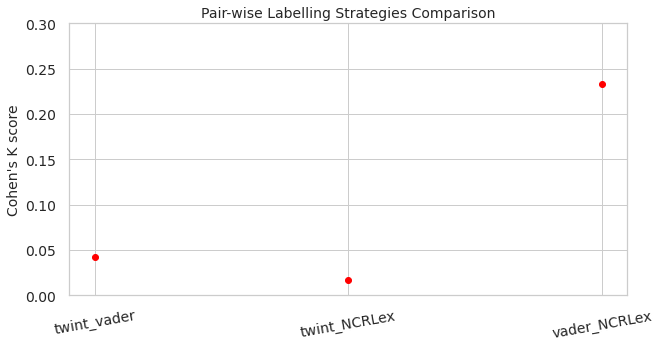

In [ ]:
ck_scores = {}
ck_scores['twint_vader'] = cohen_kappa_score(df.twint, df.vader, labels=[0,1])
ck_scores['twint_NCRLex'] = cohen_kappa_score(df.twint, df.NCRLex, labels=[0,1])
ck_scores['vader_NCRLex'] = cohen_kappa_score(df.vader, df.NCRLex, labels=[0,1])

plt.figure(figsize= (10,5))
plt.scatter([1,2,3], ck_scores.values(), color='red')
plt.ylim(0,0.3)
plt.title("Pair-wise Labelling Strategies Comparison", size = 14)
plt.ylabel("Cohen's K score", size = 14)
plt.xticks([1,2,3], ck_scores.keys(), rotation = 10, size = 14);
plt.yticks(size = 14);

# Unsupervised Analysis



## Utils

In [ ]:
def cluster_wordcount(lda_kmeans):
  
  # Prepare data
  N = len(lda_kmeans)
  cluster_topics = [lda_model['lda'].show_topics(formatted=False) for lda_model in lda_kmeans.values()]
  data_flat = [w for w_list in bigrams_trigrams for w in w_list]
  counter = Counter(data_flat)

  out = []
  for i, cluster in enumerate(cluster_topics):
    for _, topic in cluster:
      for word, weight in topic:
          out.append([word, i , weight, counter[word]])

  df_word_counts = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        
  cols = [color for name, color in cluster_colors.items()]
  for i in range(len(df_word_counts.topic_id.unique())):
      fig, ax = plt.subplots(1,1, figsize=(10,6))
      ax.bar(x='word', height="word_count", data=df_word_counts.loc[df_word_counts.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
      ax_twin = ax.twinx()
      ax_twin.bar(x='word', height="importance", data=df_word_counts.loc[df_word_counts.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
      # Y-axes
      ax.set_ylabel('Word Count', color=cols[i], size = 15)
      y_max_importance = max(df_word_counts[df_word_counts.topic_id==i].importance) + 0.005
      y_max_wc = max(df_word_counts[df_word_counts.topic_id==i].word_count) + 500
      ax_twin.set_ylim(0, y_max_importance); ax.set_ylim(0, y_max_wc)
      # X-axis
      ax.set_xticklabels(df_word_counts.loc[df_word_counts.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right', size = 15)
      # General
      ax.set_title('Cluster ' + str(i), color=cols[i], fontsize=16)
      ax.tick_params(axis='y', left=False, size = 15)
      ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')
      fig.tight_layout(w_pad=2)      
      #plt.show()
      plt.savefig('8_clusters_keywords'+str(i+1))


def cluster_wordcloud(lda_kmeans):
  """Plots the word cloud of the given LDA model."""

  cloud = WordCloud(width = 1500, 
                      height = 1000,
                      background_color = 'black', 
                      collocations=True, 
                      random_state = 42,
                      colormap = 'gist_rainbow')
  N = len(lda_kmeans)
  fig, axs = plt.subplots(int(N/2), 2, figsize=(12,10))
  for i in range(int(N/2)):
    topics = lda_kmeans[i]['lda'].show_topics(formatted=False)
    topic_words = dict(topics[0][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    axs[i,0].imshow(cloud)
    axs[i,0].set_title('Cluster '+str(i), fontdict=dict(size=16))
    axs[i,0].axis('off')
    axs[i,0].axis('off')
    axs[i,0].margins(x=0, y=0)

    topics = lda_kmeans[i + N/2]['lda'].show_topics(formatted=False)
    topic_words = dict(topics[0][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    axs[i,1].imshow(cloud)
    axs[i,1].set_title('Cluster '+str(i + int(N/2)), fontdict=dict(size=16))
    axs[i,1].axis('off')
    axs[i,1].axis('off')
    axs[i,1].margins(x=0, y=0)

  plt.tight_layout()
  plt.show()

In [ ]:
# SVD
def visualize_embeddings(embeddings, q_min = 0.01, q_max = 0.99):
    

    # 2D
    if embeddings.shape[1] == 2:

      fig, ax = plt.subplots(1, 1, figsize=(15, 12))

      ax.scatter(embeddings[:, 0], embeddings[:, 1], alpha=0.1, c='blue')

      # Set proper axis limit range
      # We avoid outliers ruining the visualization if they are quite far away
      xmin_quantile = np.quantile(embeddings[:, 0], q=q_min)
      xmax_quantile = np.quantile(embeddings[:, 0], q=q_max)

      ymin_quantile = np.quantile(embeddings[:, 1], q=q_min)
      ymax_quantile = np.quantile(embeddings[:, 1], q=q_max)

      ax.set_xlim(xmin_quantile, xmax_quantile)
      ax.set_ylim(ymin_quantile, ymax_quantile)
      plt.grid(False)

    # 3D
    elif embeddings.shape[1] == 3:
      fig = plt.figure( figsize = (20,10))
      ax = fig.add_subplot(111, projection='3d')
      xs = embeddings[:, 0]
      ys = embeddings[:, 1]
      zs = embeddings[:, 2]
      ax.scatter(xs, ys, zs, alpha=0.1, marker='o')
      
      # Set proper axis limit range
      # We avoid outliers ruining the visualization if they are quite far away
      xmin_quantile = np.quantile(embeddings[:, 0], q=q_min)
      xmax_quantile = np.quantile(embeddings[:, 0], q=q_max)

      ymin_quantile = np.quantile(embeddings[:, 1], q=q_min)
      ymax_quantile = np.quantile(embeddings[:, 1], q=q_max)
      
      zmin_quantile = np.quantile(embeddings[:, 2], q=q_min)
      zmax_quantile = np.quantile(embeddings[:, 2], q=q_max)

      ax.set_xlim(xmin_quantile, xmax_quantile)
      ax.set_ylim(ymin_quantile, ymax_quantile)
      ax.set_zlim(zmin_quantile, zmax_quantile)
      
      plt.grid(False)


# LABELS
def visualize_labels(embeddings, labels, title, mode = 'all', legend = ['Not Depressed', 'Depressed'], q_min = 0.01, q_max = 0.99):
  
  # LEGEND AND LABEL COLOURS
  c = ['green' if i == 0 else 'red' for i in labels]
  legend_elements = [Line2D([0], [0], 
                          color='white', 
                          marker='o', 
                          label=legend[0], 
                          markerfacecolor='green', 
                          markersize=15),
                   Line2D([0], [0], 
                          marker='o', 
                          color='white', 
                          label=legend[1],
                          markerfacecolor='red', 
                          markersize=15)]


  # 2-DIMENSIONAL SPACE

  if embeddings.shape[1] == 2:
    fig, ax = plt.subplots(1, 1, figsize=(15, 12))
    
    if mode == 'all':
      x = embeddings[:,0]
      y = embeddings[:,1]
      c = ['green' if i == 0 else 'red' for i in labels]
      plt.scatter(x,y, alpha=0.5, c=c)
      plt.title(title)
    
    elif mode == 'depressed':
      x = embeddings[labels == 1][:,0]
      y = embeddings[labels == 1][:,1]
      c = ['red' for i in labels[labels == 1]]
      plt.scatter(x,y, alpha=0.5, c=c)
      plt.title(title +" "+ legend[1])
    
    elif mode == 'not_depressed':
      x = embeddings[labels == 0][:,0]
      y = embeddings[labels == 0][:,1]
      c = ['green' for i in labels[labels == 0]]
      plt.scatter(x, y, alpha=0.5, c=c)                      
      plt.title(title +" "+ legend[0])
    # Set proper axis limit range
    # We avoid outliers ruining the visualization if they are quite far away
    xmin_quantile = np.quantile(embeddings[:, 0], q=q_min)
    xmax_quantile = np.quantile(embeddings[:, 0], q=q_max)

    ymin_quantile = np.quantile(embeddings[:, 1], q=q_min)
    ymax_quantile = np.quantile(embeddings[:, 1], q=q_max)

    ax.set_xlim(xmin_quantile, xmax_quantile)
    ax.set_ylim(ymin_quantile, ymax_quantile)  


  # 3-DIMENSIONAL SPACE

  elif embeddings.shape[1] == 3:
    fig = plt.figure( figsize = (20,10))
    ax = fig.add_subplot(111, projection='3d')
    
    if mode == 'all':
      xs = embeddings[:, 0]
      ys = embeddings[:, 1]

      zs = embeddings[:, 2]
      c = ['green' if i == 0 else 'red' for i in labels]
      ax.scatter(xs, ys, zs, alpha=0.5, c=c)
      plt.title(title)
    
    elif mode == 'depressed':
      xs = embeddings[labels == 1][:, 0]
      ys = embeddings[labels == 1][:, 1]
      zs = embeddings[labels == 1][:, 2]
      c = ['red' for i in labels[labels == 1]]
      ax.scatter(xs, ys, zs, alpha=0.5, c=c)
      plt.title(title +" "+ legend[1])
    
    elif mode == 'not_depressed':
      xs = embeddings[labels == 0][:, 0]
      ys = embeddings[labels == 0][:, 1]
      zs = embeddings[labels == 0][:, 2]
      c = ['green' for i in labels[labels == 0]]
      ax.scatter(xs, ys, zs, alpha=0.5, c=c)
      plt.title(title +" "+ legend[0])

    # Set proper axis limit range
    # We avoid outliers ruining the visualization if they are quite far away
    xmin_quantile = np.quantile(embeddings[:, 0], q=q_min)
    xmax_quantile = np.quantile(embeddings[:, 0], q=q_max)

    ymin_quantile = np.quantile(embeddings[:, 1], q=q_min)
    ymax_quantile = np.quantile(embeddings[:, 1], q=q_max)
    
    zmin_quantile = np.quantile(embeddings[:, 2], q=q_min)
    zmax_quantile = np.quantile(embeddings[:, 2], q=q_max)

    ax.set_xlim(xmin_quantile, xmax_quantile)
    ax.set_ylim(ymin_quantile, ymax_quantile)
    ax.set_zlim(zmin_quantile, zmax_quantile)
      

  plt.grid(False)
  plt.show()
    
##########
# KMEANS #
##########
def visualize_kmeans(embeddings, labels, centroids, title = ""):
  
  # 2D
  if embeddings.shape[1] == 2:
    plt.figure(figsize=(15,12))
    # Colormap and Colorbar 
    n = len(centroids)
    cmap = mcolors.ListedColormap(sns.color_palette("husl", 8), N = n)
    norm = mcolors.BoundaryNorm(np.arange(n+1)-0.5, n)
    # Scatter
    sc = plt.scatter(embeddings[:, 0], 
                embeddings[:, 1], 
                c=labels, 
                alpha=0.5, 
                cmap=cmap, 
                norm=norm)
    plt.colorbar(sc, ticks=range(len(centroids)))
    plt.title(title)
    plt.grid(False)
    plt.show()

  # 3D
  if embeddings.shape[1] == 3:
    fig = plt.figure( figsize = (15,12))
    ax = fig.add_subplot(111, projection='3d')
    xs = embeddings[:, 0]
    ys = embeddings[:, 1]
    zs = embeddings[:, 2]
    ax.scatter(xs, ys, zs,  c=labels, alpha=0.5, cmap='viridis')
    ax.scatter(centroids[:, 0], 
               centroids[:, 1], 
               centroids[:, 2], 
               c='black', 
               alpha=1.,  
               marker = '*', 
               s = 200, 
               label = "Centroid")
    plt.legend(loc='best')
    plt.title(title)
    plt.grid(False)
    plt.show()




In [ ]:
def draw_vector(v0, v1, ax=None, color= 'red'):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, 
                    shrinkB=0,
                    color=color)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

## LSA

As the vast majority of text data, our dataset heavily suffers from high-dimensionality. In order to address this problem and easily work with our data, we apply the well known **Latent Semantic Analysis (LSA)** technique on the tf-idf matrix.  

Since we are dealing with sparse data, we rely on `scikit-learn` `TruncatedSVD` transformer which performs linear dimensionality reduction by means of truncated **Singular Value Decomposition** (**SVD**).
To define the number of components we look at the **cumulative explained variance ratio** as a function of the number of components: 

<img src="https://drive.google.com/uc?id=1zDz-uhPjO6m2amkaNE4KOUdfvbMhMHjd" width="500">



We set `n_components = 500` as a trade-off between the percentage of data variance explained (around $30\%$) and the clustering algorithm training time.  

To visualize our data we only need to plot the first 2 components of the reduced matrix:


<img src="https://drive.google.com/uc?id=1TLngXoSn2rEYgp7MtoDZgPycjbUw-Yf3" width="500">



**Input Data**

In [ ]:
# List of tokens
data = df['clean_text']
tokens = data.map(lambda sentences: list(sentences.split()))
tokens = list(tokens)

# Create Dictionary
token2id = corpora.Dictionary(tokens).token2id
print("Number of terms:",len(token2id))

# Vectorization: TF-IDF
vectorizer = TfidfVectorizer(min_df = 2, max_df = 0.75, ngram_range=(1,1), vocabulary=token2id)
svd_input = vectorizer.fit_transform(df.clean_text)
print("Input shape:",svd_input.shape )

Number of terms: 77738
Input shape: (128448, 77738)


**Explained Variance Ratio vs Number of Components**

In [ ]:
%%time
svd = TruncatedSVD(n_components=1000,
                   algorithm='randomized', 
                   n_iter=10, 
                   random_state=42).fit(svd_input)
plt.figure(figsize=(12,10))
plt.plot(np.cumsum(svd.explained_variance_ratio_), 'b')
plt.xlabel('# of components')
plt.ylabel('cumulative explained variance')
plt.title('Truncated SVD');

**Truncated SVD**


In [ ]:
n = 500
svd = TruncatedSVD(n_components=n,
                   algorithm='randomized', 
                   n_iter=10, 
                   random_state=42).fit(svd_input)
svd_output = svd.transform(svd_input)
print("Data variance explained:", svd.explained_variance_ratio_.sum())

Data variance explained: 0.29254380617492814


**2-dimensional data visualization**

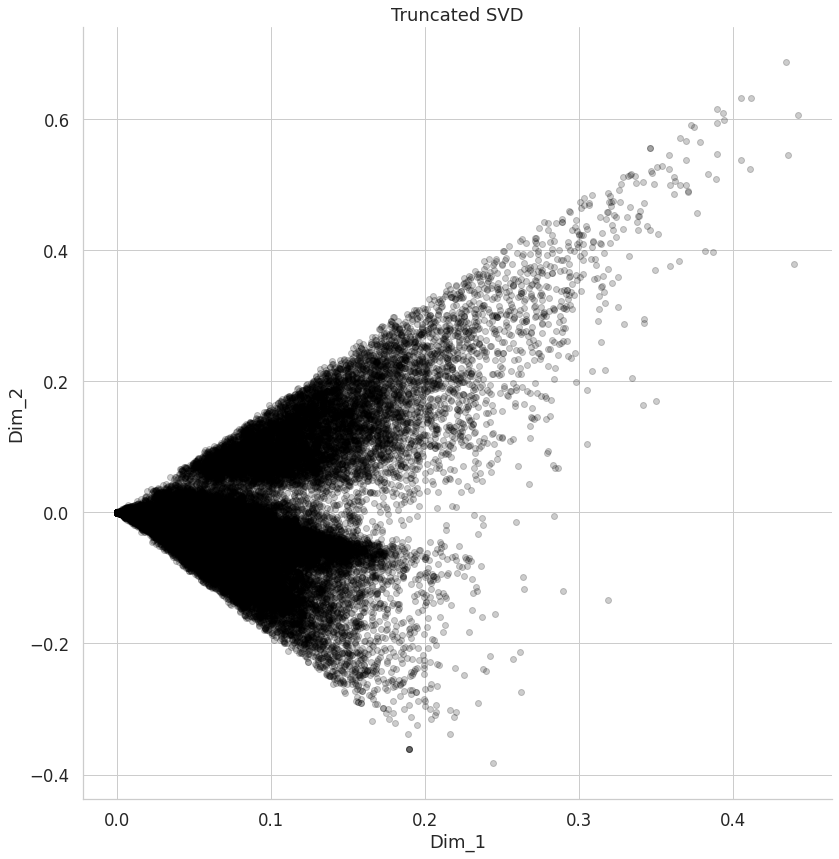

In [ ]:
svd_2D = pd.DataFrame(data = svd_output[:,:2], columns= ("Dim_1", "Dim_2"))

sns.set(font_scale=1.5, 
        style='whitegrid')
sns.FacetGrid(svd_2D, height=12).map(plt.scatter,'Dim_1','Dim_2', alpha=0.2, color='black')
plt.title('Truncated SVD');


**Labels visualization**

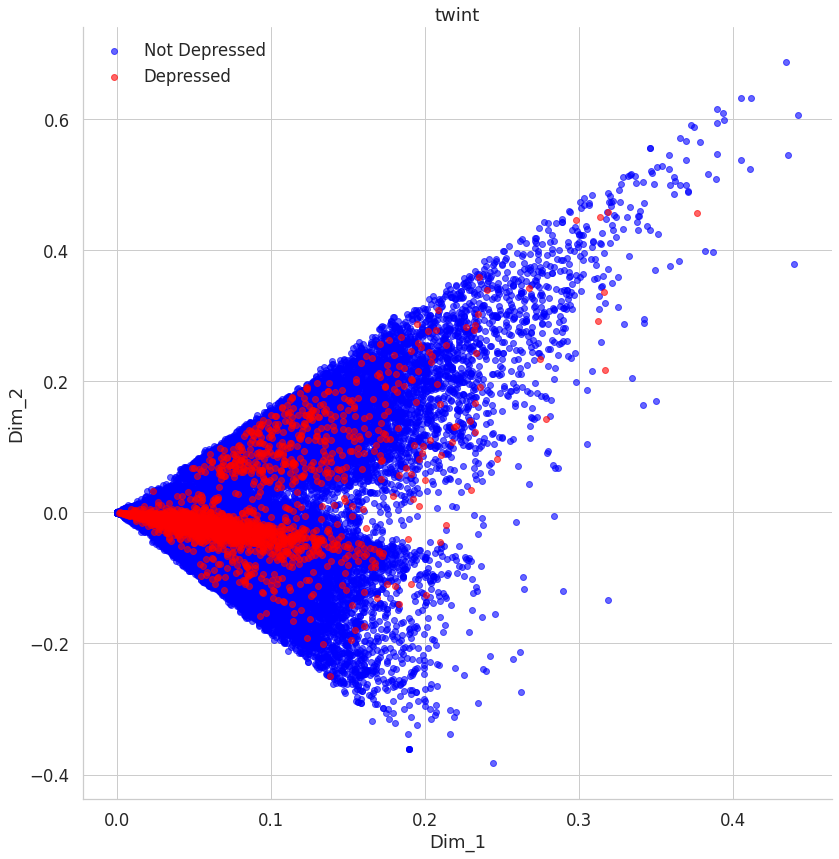

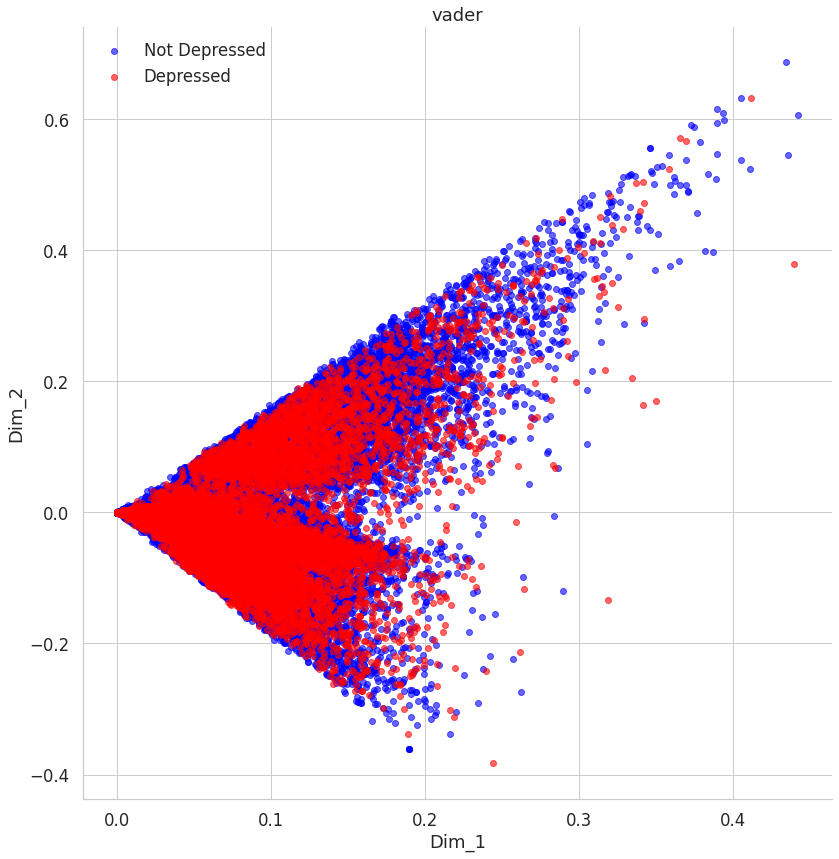

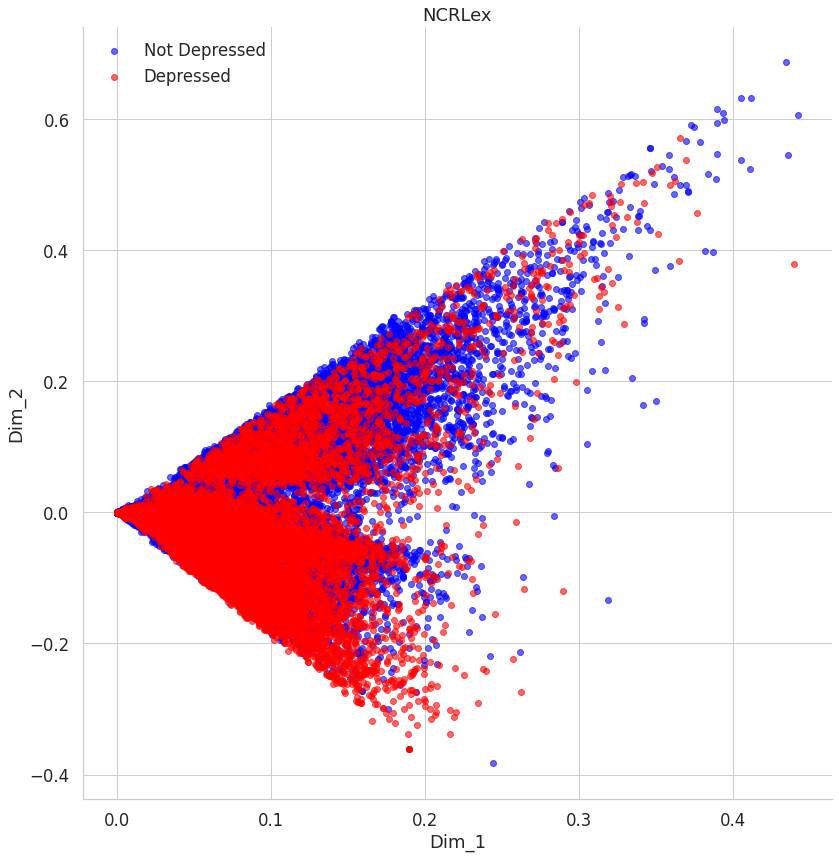

In [ ]:
svd_2D['twint'] = df.twint
svd_2D['vader'] = df.vader
svd_2D['NCRLex'] = df.NCRLex

for label in ['twint', 'vader', 'NCRLex']:
  sns.FacetGrid(svd_2D, 
                hue = label, 
                height=12, 
                palette = ['blue','red']).map(plt.scatter,'Dim_1','Dim_2', alpha=0.6)
  plt.legend(['Not Depressed', 'Depressed'])
  plt.title(label)
  plt.show()

## Clustering 
One of the most well known clustering method is the **k-Means algorithm** which clusters a set of samples $X$ into disjoint $k$ clusters, each described by the mean or ”centroid” $\mu_j$
of the samples in the cluster.  
The k-Means algorithm is based on the **minimization** of the **inertia**, or **within-cluster sum-of-squares criterion**, formally:
$$\sum_{i=0}^{n}\min_{\mu_j \in C}(||x_i - \mu_j||^2)$$


*k-Means* have various drawbacks:

* it is based on *inertia* which makes the **assumption that clusters are convex and isotropic**, which is not always the case. It responds poorly to elongated clusters, or manifolds with irregular shapes.  
Moreover, *inertia* is **not a normalized metric**, thus it suffers from the “*curse of dimensionality*”. However, the LSA we have performed should mitigate this problem and speed up the computation.

* *k-Means* requires the number of clusters to be specified, and this is not always a simple task. We will try to find the best number of clusters by applying the **Elbow Method**.  

* *k-Means* convergence is **highly dependent on the initialization of the centroids**. To avoid being stuck in a local minimum the computation is often done several times, with different initializations of the centroids.  
To speed up the process we rely on the **k-means++ initialization scheme**, which has been implemented in `sklearn.cluster.KMeans` class. With this inizialization, the centroids are placed distant from each other, leading to provably better results than random initialization. 


### Elbow Method

As anticipated, we use the **Elbow Method** to select the **best number of clusters**.  
This method consists of running the algorithm multiple times with an increasing number of cluster choice $k$, and computing the sum of squared distances from each point to its assigned centroid (i.e. the **“distortion”**). Then, the *distortion* is plotted as a function of the number of clusters, and the best value of $k$ is selected by identifying the point where the *distortion* begins to decrease most rapidly before the curve reached a plateau.  

Here we display the Elbow Method result for $k \in [2, 12]$: 


<img src="https://drive.google.com/uc?id=1DXiNXfWdqi3YrUl29p2hg5g8X3Lyw5vi" width="700">

By looking at the figure, we can identify an elbow at both $k = 6$ and $k = 8$. In the next section we will compare these 2 values of $k$ by performing an analysis on the two resulting sets of clusters.


In [ ]:
# WARNING: highly time consuming!

# Clustering model
model = KMeans(init='k-means++', 
               n_init=10, 
               max_iter=300, 
               tol=0.0001,
               verbose=1, 
               random_state=42, 
               copy_x=True, 
               n_jobs=-1, 
               algorithm='auto')

# Visualizer
visualizer = KElbowVisualizer(model, 
                              k=(2,13), 
                              metric='distortion', 
                              verbose = True, 
                              size=(1080, 720))


%time visualizer.fit(svd_output)             

In [ ]:
# Visualize
visualizer.show();    

### k-Means Clustering
As mentioned in the previous section, we compare two values of $k$ ($6$ and $8$)  by applying the corresponding *k-Means* algorithm on the reduced matrix and comparing the results.  

In the figures below we display the 2-dimensional representation of our dataset colouring data points according to the cluster they belong to:  
> $k=6$  
 <img src="https://drive.google.com/uc?id=1-IXe_8NN4UCGfFoTG2U1LpXUQJTu4Pd0" width="700">   


> $k=8$  
<img src="https://drive.google.com/uc?id=1s_m8JII1PZbYGMN7Iv7WHMZSRvYSSYhW" width="700">  






As we can clearly see
+ $k=6$: **cluster 1** is by far the largest cluster, while **cluster 5** is the smallest; 
+ $k=8$: **cluster 2** is by far the largest cluster, while **cluster 5** seems to be the smallest;

These observations are confirmed in the **intercluster distance maps** displayed below which are 2-dimensional representations of the cluster centers obtained by performing **Multidimensional Scaling (MDS)** on *k-Means* output.  
In the intercluster distance maps **the distance among the centroids are preserved** (i.e. the closer two centers are in the visualization, the closer they are in the original feature space). Moreover, the clusters are **sized by membership** (i.e. the number of instances that belong to each center).  
*Note: the fact that two clusters overlap in the 2D space does not imply that they overlap in the original feature space.*

> $k=6$   
<img src="https://drive.google.com/uc?id=1GE0sPXFuc6qyMy4ia-CTRv2QTp0-uY1s" width="600">  

> $k=8$   
<img src="https://drive.google.com/uc?id=1B-8nTjnDFkQ6F1KO-o3suezgtp62KY87" width="600">  





**Run k-Means algorithm with the best $k$**

In [ ]:
%%time 
k = 4
model = KMeans(n_clusters=k,
               init='k-means++', 
               n_init=10, 
               max_iter=300, 
               tol=0.0001,
               verbose=1, 
               random_state=42, 
               copy_x=True, 
               n_jobs=-1, 
               algorithm='auto')

kmeans_output = model.fit_transform(svd_output) 


CPU times: user 1.28 s, sys: 404 ms, total: 1.68 s
Wall time: 2min 12s


Save the clusters labels for further analysis:

In [ ]:
df['cluster4'] = pd.Series(model.labels_) # replace cluster6 <-> cluster8 to save the corresponding clustering
svd_2D['cluster4'] = pd.Series(model.labels_) # replace cluster6 <-> cluster8 to save the corresponding clustering

**Clusters visualization on PCA reduction**

In [ ]:
cluster_colors = {
    0:'red',
    1:'blue',
    2:'green',
    3:'orange',
    4:'purple',
    5:'turquoise',
    6:'black',
    7:'brown'}

for cluster in ['cluster6','cluster8']:
  sns.FacetGrid(svd_2D, 
                hue = cluster, 
                height=12, 
                palette = cluster_colors).map(plt.scatter,
                                              'Dim_1',
                                              'Dim_2', 
                                              alpha = 0.5).add_legend()
  plt.title('k-Means clustering')
  plt.show()

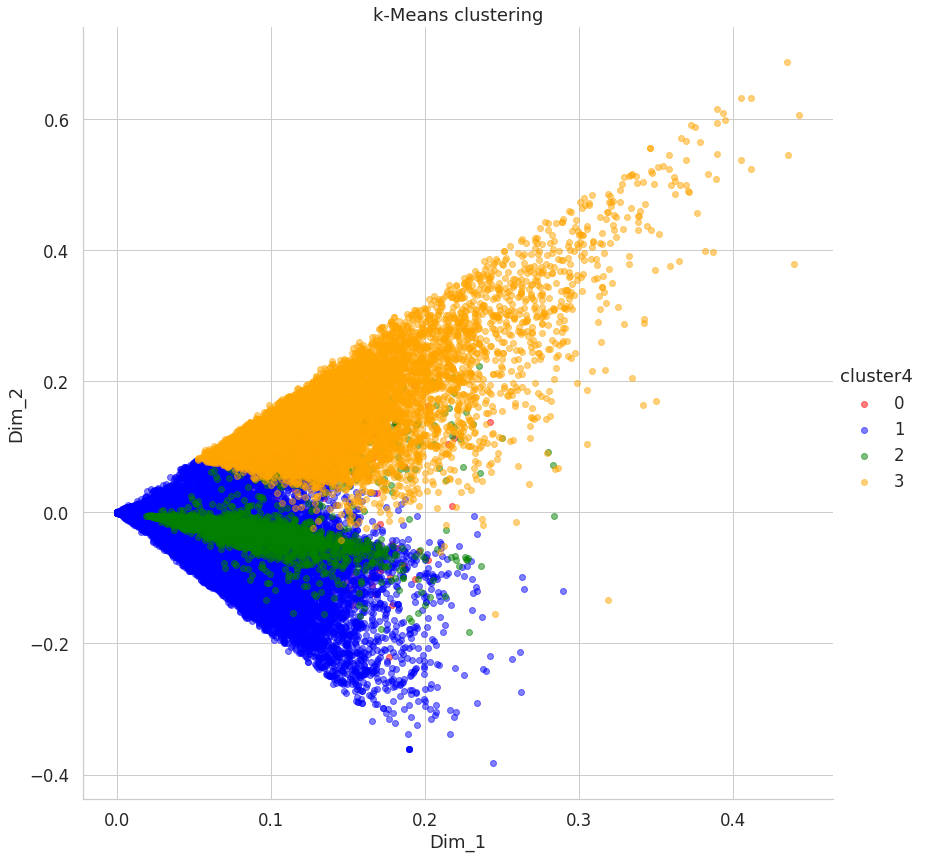

In [ ]:
sns.FacetGrid(svd_2D, 
              hue = 'cluster4', 
              height=12, 
              palette = cluster_colors).map(plt.scatter,
                                            'Dim_1',
                                            'Dim_2', 
                                            alpha = 0.5).add_legend()
plt.title('k-Means clustering')
plt.show()

**Intercluster Distance Map**

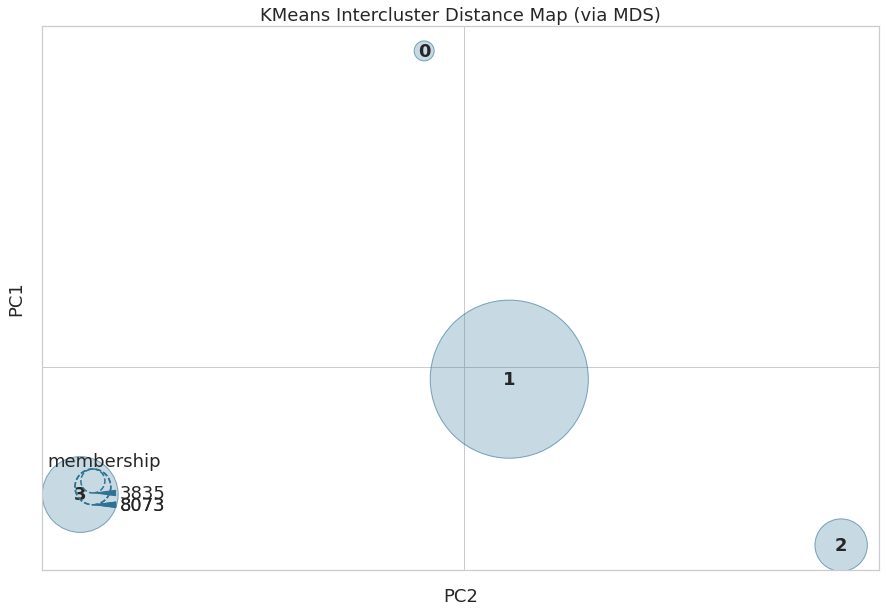

In [ ]:
visualizer = InterclusterDistance(model, 
                                  size=(1080, 720), 
                                  embedding='mds', 
                                  random_state=42) 
visualizer.fit(svd_output)     
visualizer.show(); 

### Analysis on single clusters

Let's have a closer look at the clusters by plotting them individually:



> $k=6$   
<img src="https://drive.google.com/uc?id=1gyRh1Klox4o2aqxC4xAAVv8opfP4bOKi" width="900">  


> $k=8$   
<img src="https://drive.google.com/uc?id=1itiRju4ZH7XPRQSwwt9eBC-cudVtog9e" width="900">  


________________
**LDA on single clusters**  
We perform LDA on the tweets belonging to a given cluster to get a deeper insight into it. We use the same LDA configuration specified in section *LDA - Running LDA with best parameters* and we 
In the figures below we display the resulting Word Clouds obtained by using the same configuration of section *LDA - Running LDA with best parameters*:

> $k=6$  
* __Cluster 0__: news about reopening schools.
* __Cluster 1__: news related to the increasing number of deaths.
* __Cluster 2__: monthly and weekly plans; inforation about the current state.  
* __Cluster 3__: face masks and related topics.
* __Cluster 4__: no a clear topic.
* __Cluster 5__: vaccine and related topics.   

**Word Clouds**  


> $k=8$  
It is more difficult to find the main topic of these Word Clouds
* __Cluster 0__: death rates and 
* __Cluster 1__: news related to the increasing number of deaths.
* __Cluster 2__: information related to research and study on the infection, also linked to the government.
* __Cluster 3__: news from India, h
* __Cluster 4__: many of the represented words are related to the encoding of emoji:
  + folded\_hand\_medium\_light\_skin\_tone $\rightarrow$ 🙏🏼
  + woman\_shrugging\_medium\_light\_skin\_tone $\rightarrow$ 🤷🏼‍♀️ 
  + backhand_index_pointing $\rightarrow$ 👉 (and rotations)
This may suggest that the tweets of Cluster 4 contained lot of these emoji (we confirmed this hypothesis by visually inspected tweets text).
* __Cluster 5__: vaccine and related topics.
* __Cluster 6__: news about reopening schools and camps.
* __Cluster 7__: news related to the increasing number of deaths.







#### **A closer look at the clusters**

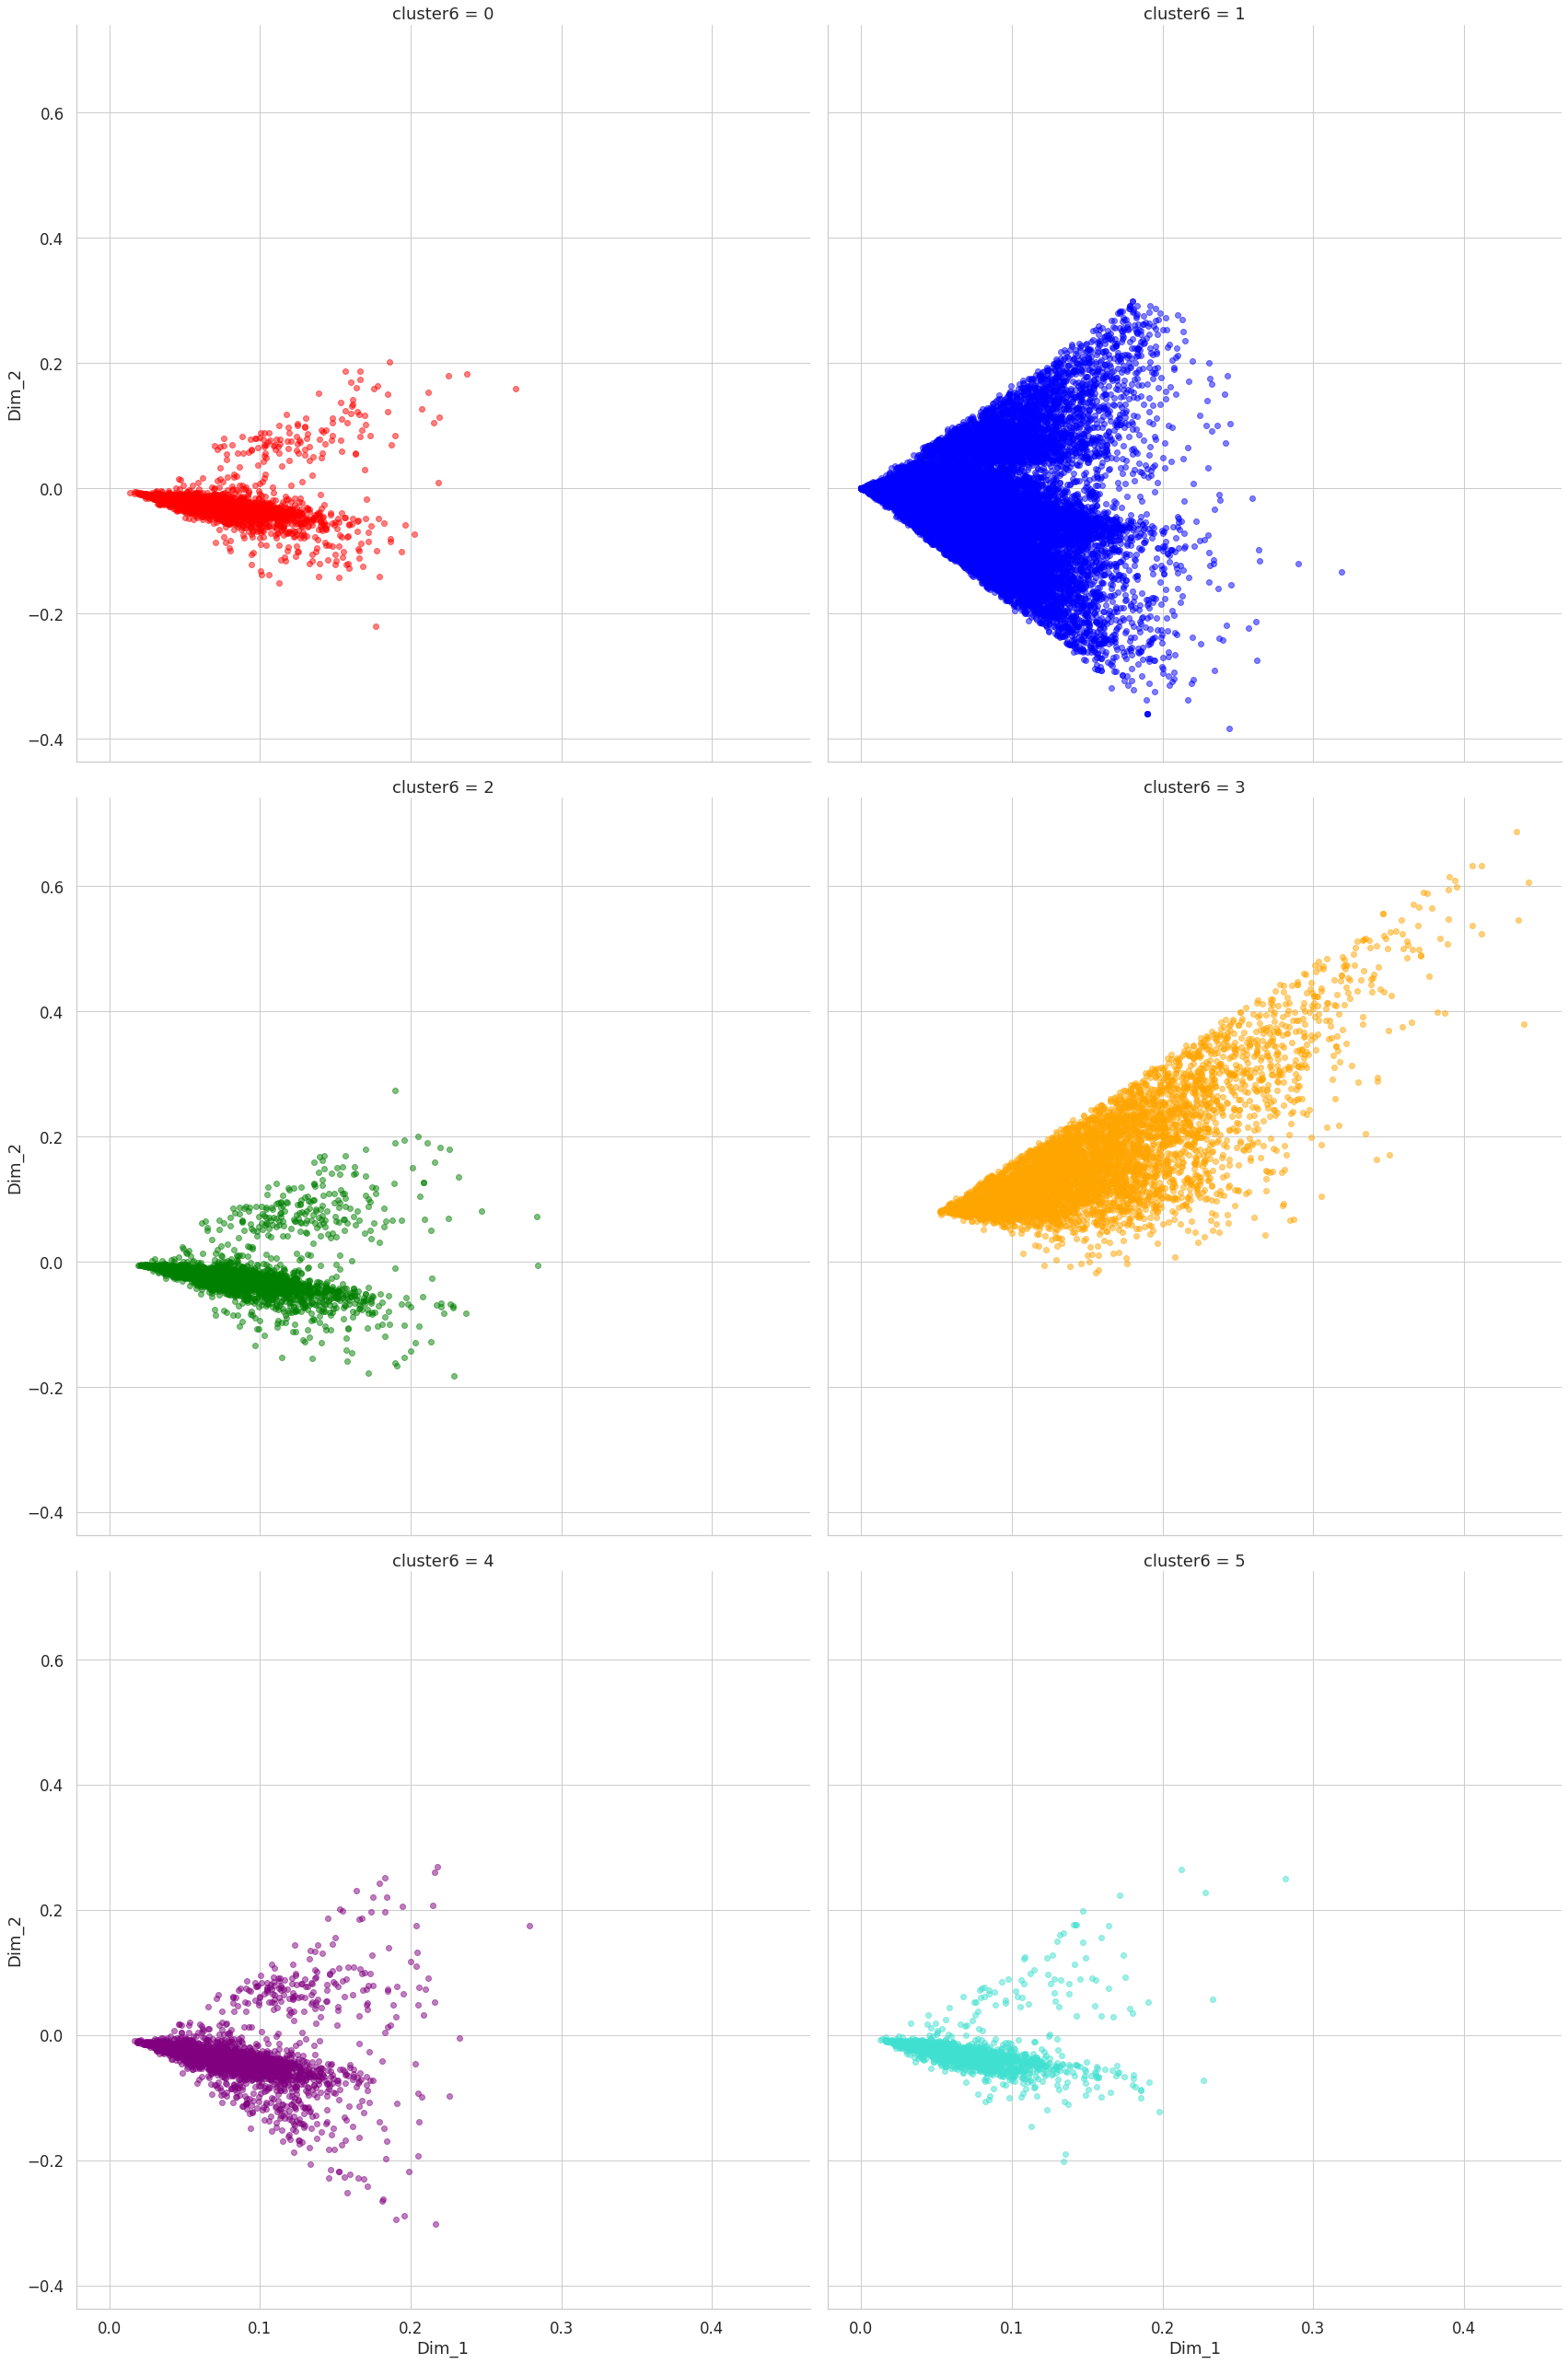

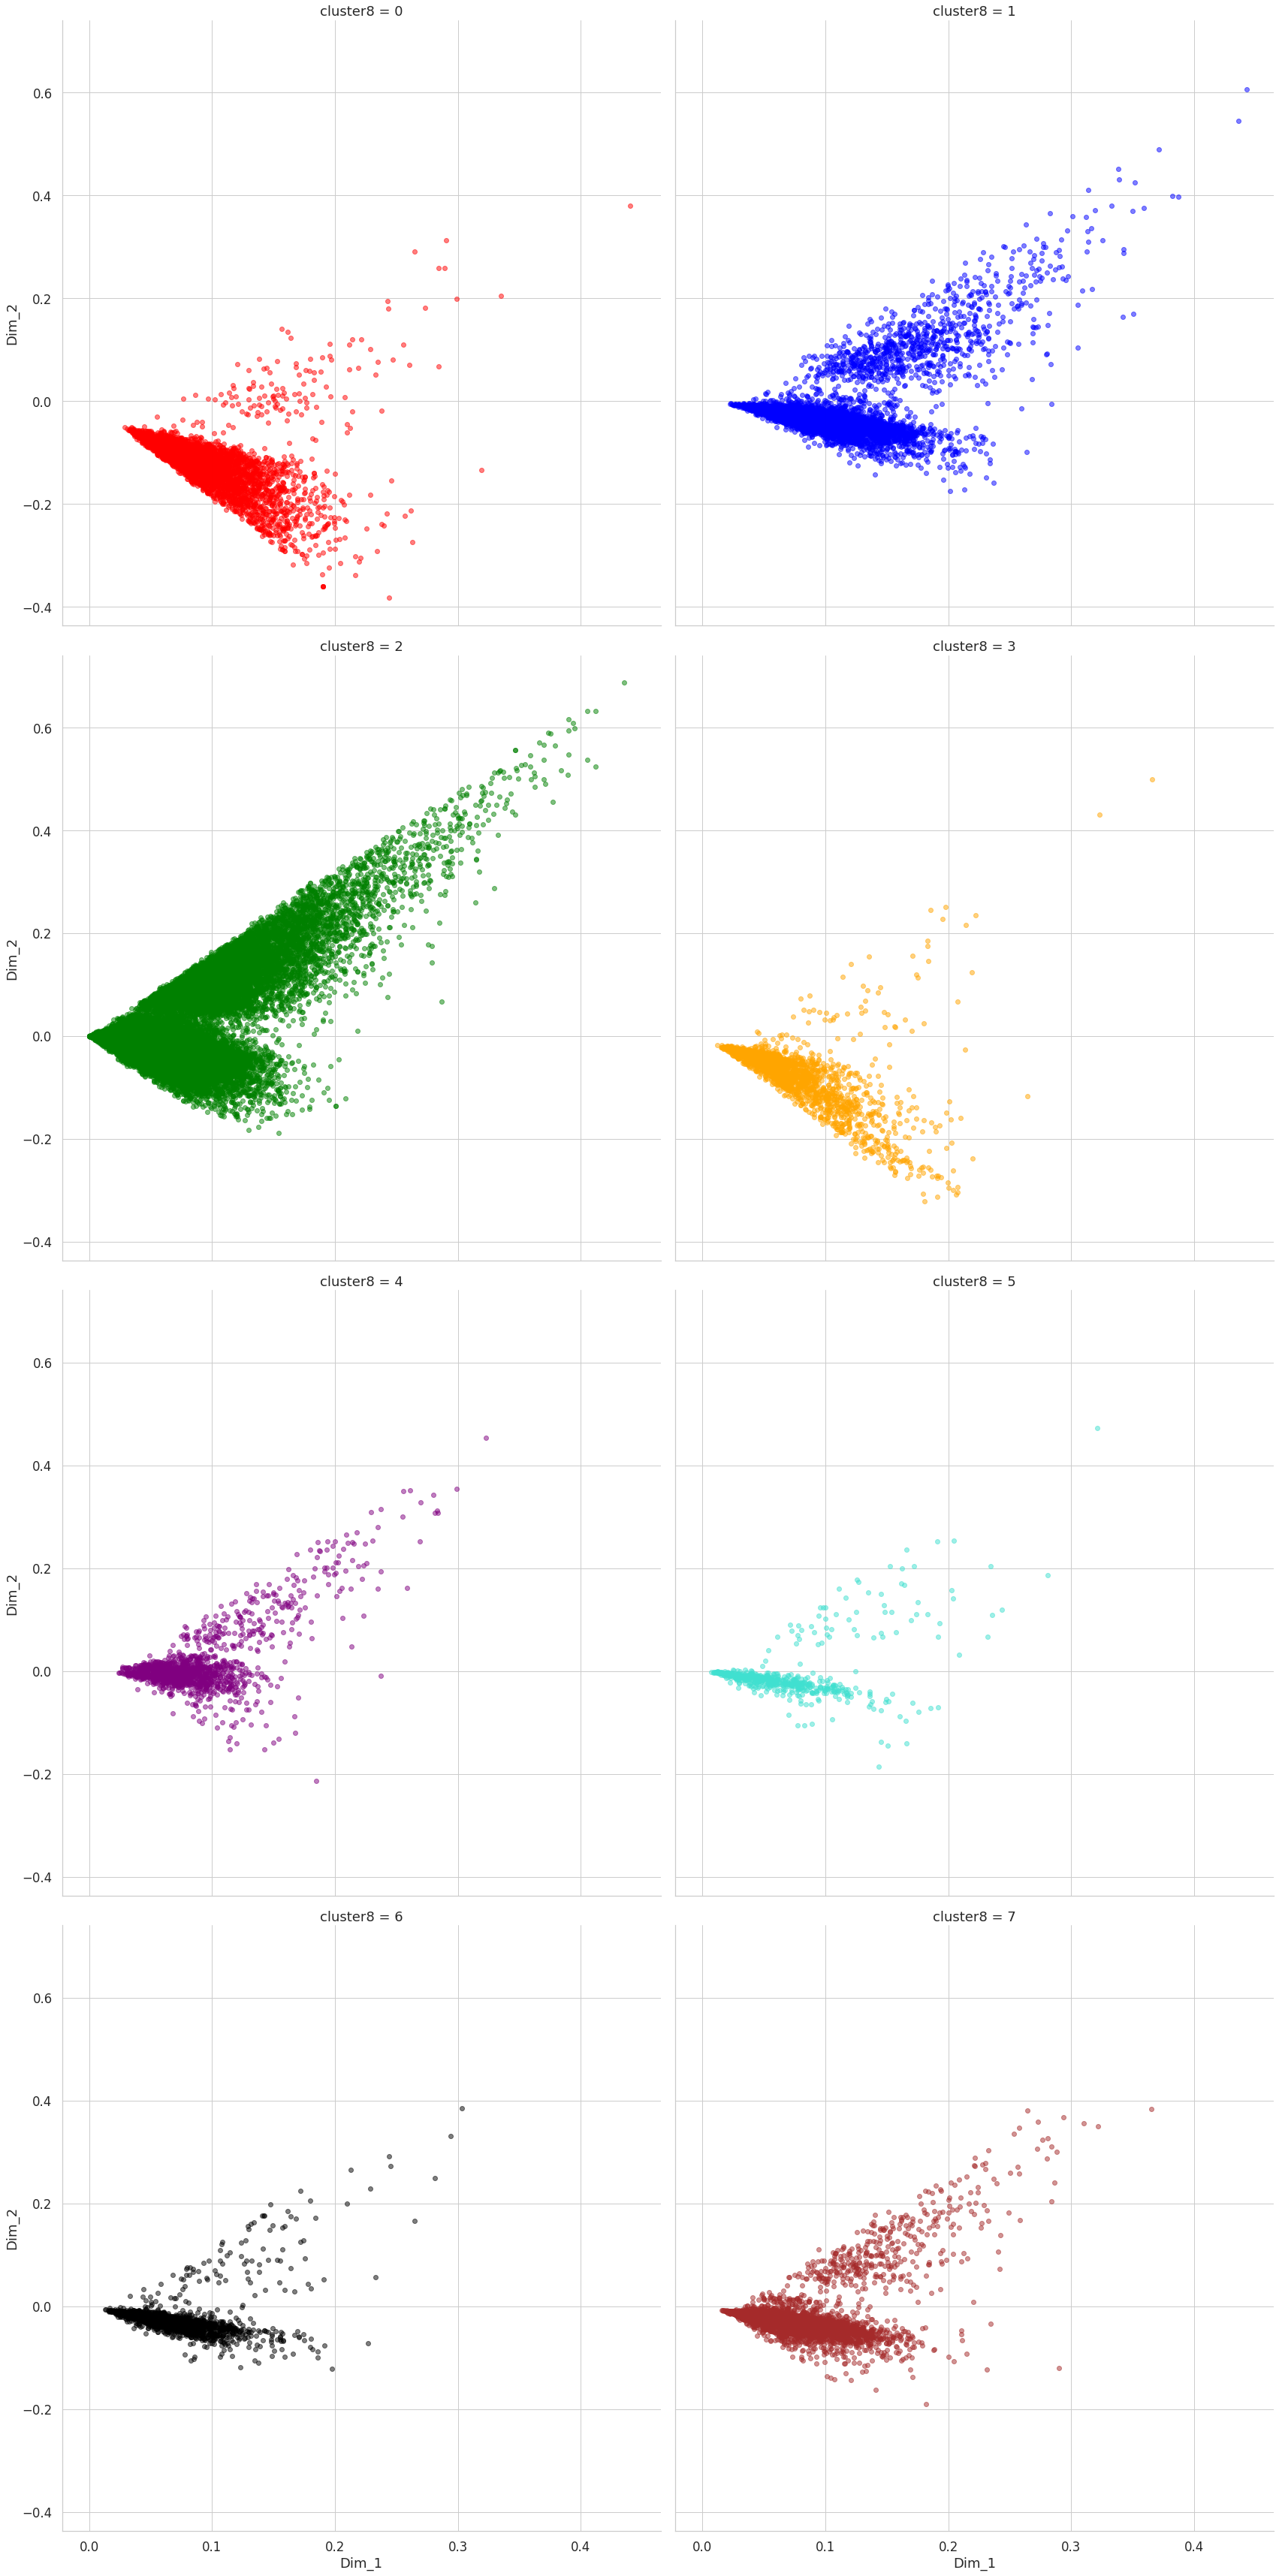

In [ ]:
for cluster in ['cluster6','cluster8']:
  sns.FacetGrid(svd_2D, 
                hue = cluster,
                col = cluster,
                col_wrap=2,
                height=12, 
                palette = cluster_colors).map(plt.scatter,
                                              'Dim_1',
                                              'Dim_2', 
                                              alpha = 0.5)
  plt.show()

In [ ]:
df.text[df.cluster8 == 7][:50]

6      Praying for good health and recovery of @ChouhanShivraj .\n#covid19\n#covidPositive                                                                 
62     @theJagmeetSingh @MatthewGreenNDP you took money at the beginning of the pandemic from woman front line workers who… https://t.co/NXYIA38Rj6        
65     The cost of preventing further pandemics over the next decade by protecting wildlife and forests would equate to ju… https://t.co/8yqpH3GrLf        
80     Companies must protect their workforce’s physical and mental health during the crisis. The use of smart technology,… https://t.co/uExGQbwx1I        
90     Lunch in #Amsterdam away from the mass tourists that have invaded so quickly during the #COVID19 pandemic ! #travel https://t.co/DBCPWA0Ao9         
155    Symptom Duration and Risk Factors for Delayed Return to Usual Health Among Outpatients with #COVID19 in a Multistat… https://t.co/wNUL5Bd5Ok        
187    “Since everything stopped because of the pandemic, I have

In [ ]:
df.text[df.cluster8 == 0]

4         #coronavirus #covid19 deaths continue to rise. It's almost  as bad as it ever was.  Politicians and businesses want… https://t.co/hXMHooXX2C      
24        An update on the total #covid19 cases, recoveries, and deaths reported in countries in #Africa.  See the total numb… https://t.co/eqCJ3EhwRi      
35        #Delhi reports 1,142 #COVID19 positive cases and 29 deaths on Saturday. Death toll rises to 3,806, reports ANI quot… https://t.co/JxsVpWMRQS      
47        See this Instagram post by @facts.covid19 https://t.co/glmd51L1OJ \nfacts.covid19 Deaths rates not rising in lockste… https://t.co/SeZieeSxAk     
81        Today's cases:  92\nTotal cases: 4102\nToday's sample: 602\nToday's cured: 45\nTotal cured: 3233\nToday's death: 2\nTotal… https://t.co/tmrdKOWoma
                                                                                 ...                                                                        
128358    7 consecutive days without a death from #Covid19

**Labels distribution across the clusters**

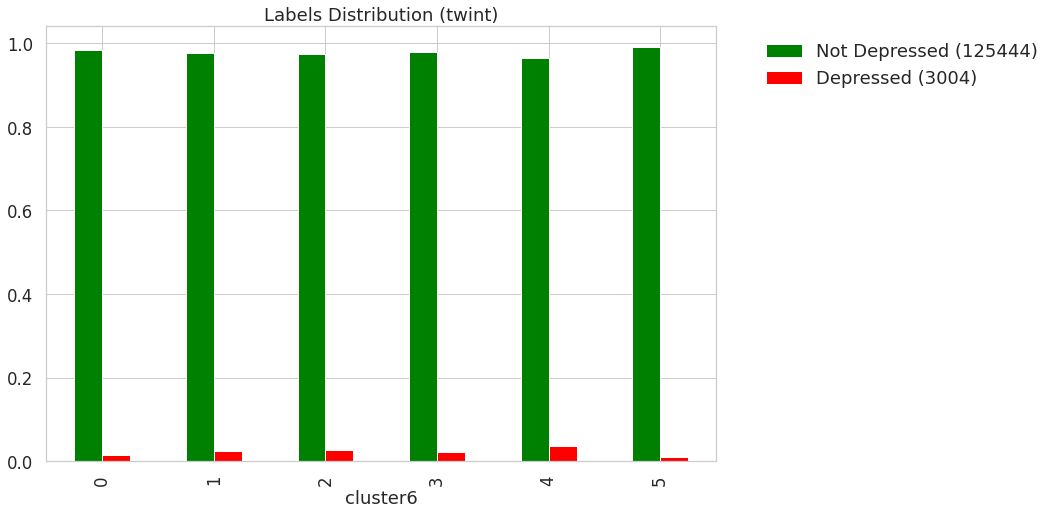

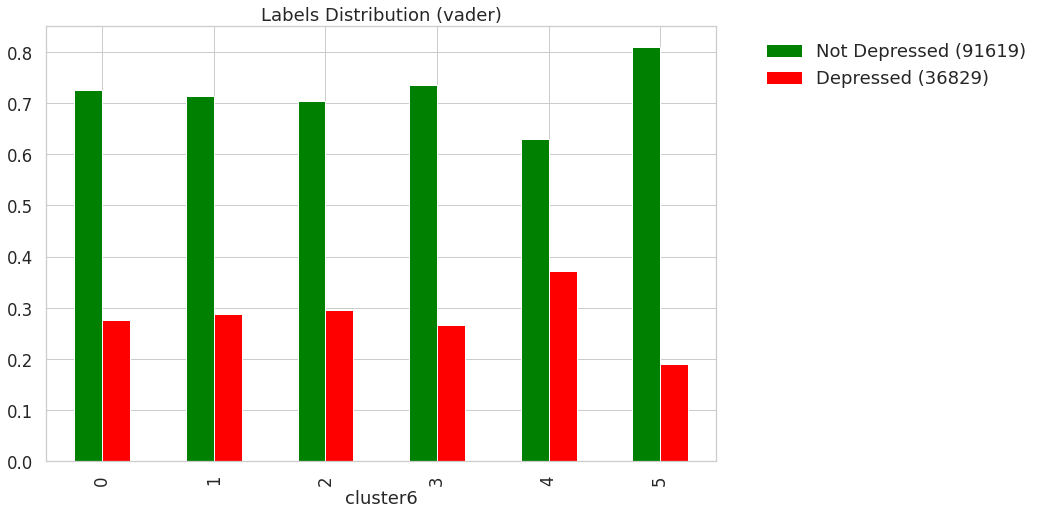

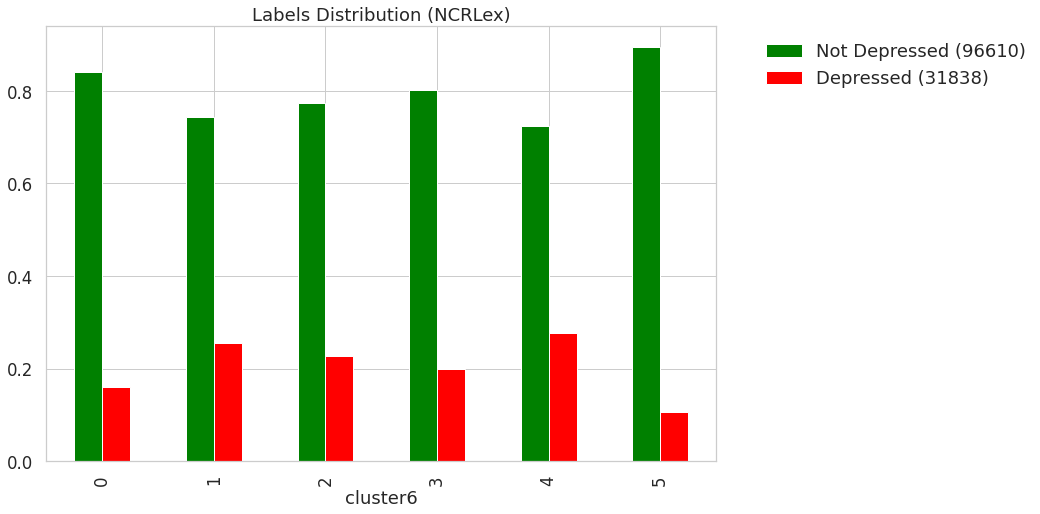

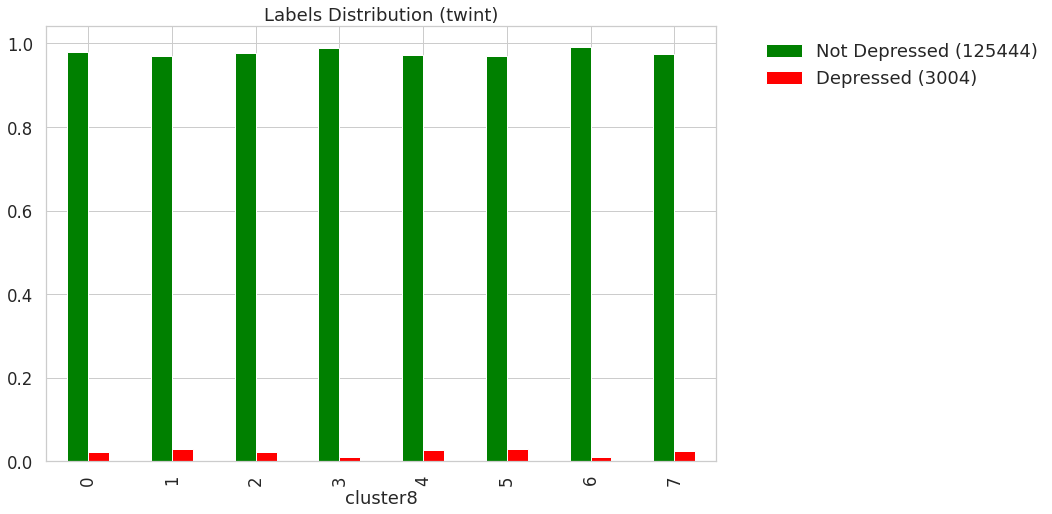

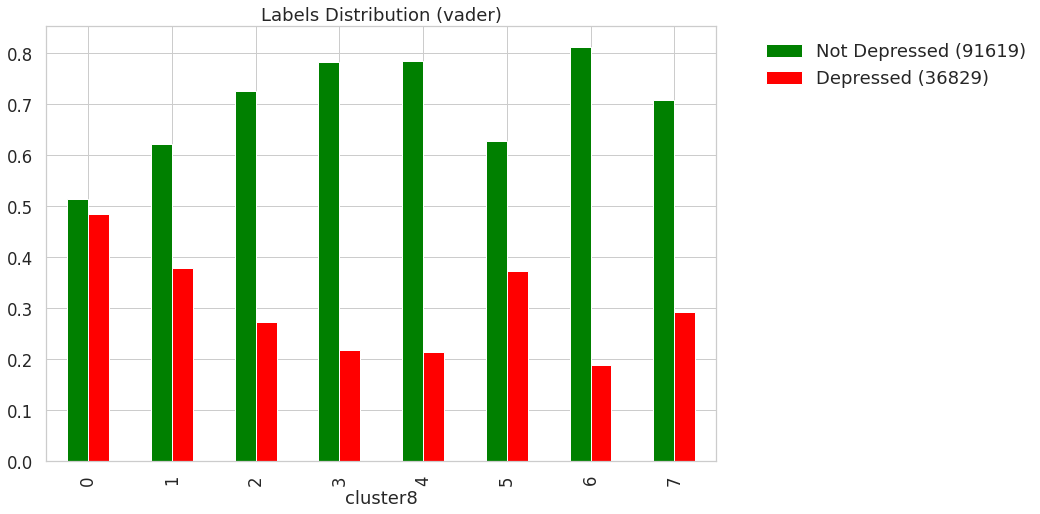

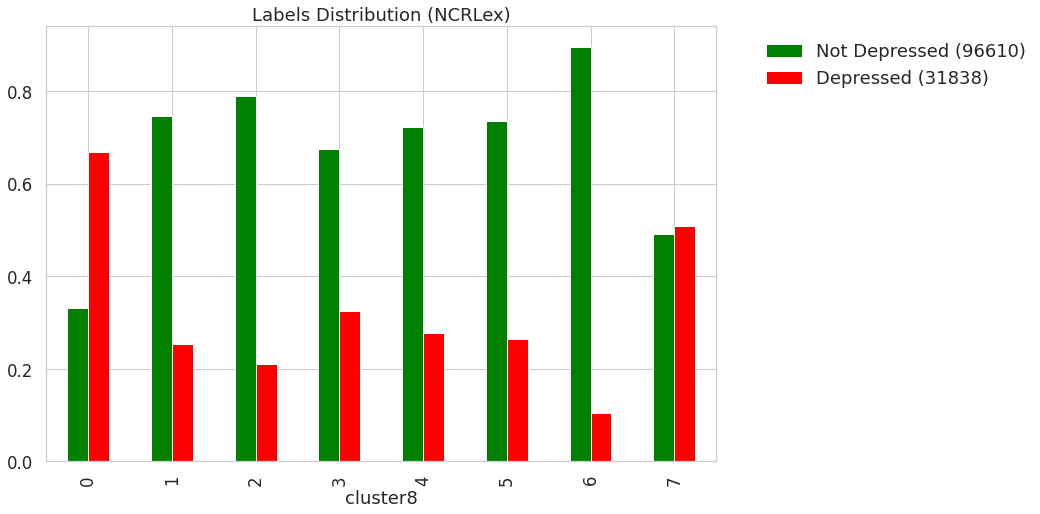

In [ ]:
for cluster in ['cluster6','cluster8']:
  fontP = FontProperties()
  fontP.set_size('medium')

  for label in ['twint', 'vader', 'NCRLex']:
    data = df.groupby([cluster, label]).count()['text']
    data = pd.concat([data.to_frame('count'),data.groupby(level=cluster).apply(lambda x: x.div(x.sum())).to_frame('percent')], axis=1)
    data['percent'].unstack(level=1).plot.bar(
      title = 'Labels Distribution ('+label+')', 
      figsize=(12, 8), 
      color=['green','red']);
    plt.legend(['Not Depressed ('+str(Counter(df[label])[0])+')',
                'Depressed ('+str(Counter(df[label])[1])+')'],
              bbox_to_anchor=(1.05, 1), 
              loc='upper left', 
              prop=fontP)

#### **LDA on single clusters**

In [ ]:
# REQUIRES LDA DATA PREPARATION
# WARNING: time consuming!
%%time
lda_kmeans = {}
corpus = np.array(corpus, dtype = 'object')
bigrams_trigrams = np.array(bigrams_trigrams, dtype = 'object')
for i in range(k):
  print("Topic:", i)
  num_topics = 1
  lda_kmeans[i] ={}
  lda_kmeans[i]['corpus'] = corpus[df['cluster4'] == i].tolist()
  lda_kmeans[i]['text'] = bigrams_trigrams[df['cluster4'] == i].tolist()
  lda_kmeans[i]['lda']= models.LdaModel(lda_kmeans[i]['corpus'],
                                        num_topics=num_topics, 
                                        id2word = id2word, 
                                        passes=10,
                                        iterations = 100,
                                        chunksize = 10000, 
                                        random_state = 42)

Topic: 0
Topic: 1
Topic: 2
Topic: 3
CPU times: user 1min 53s, sys: 28.2 ms, total: 1min 53s
Wall time: 1min 54s


**Word Count and Importance of Topic Keywords**

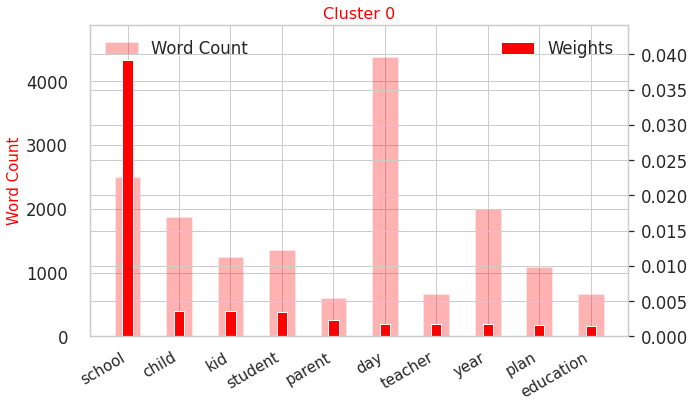

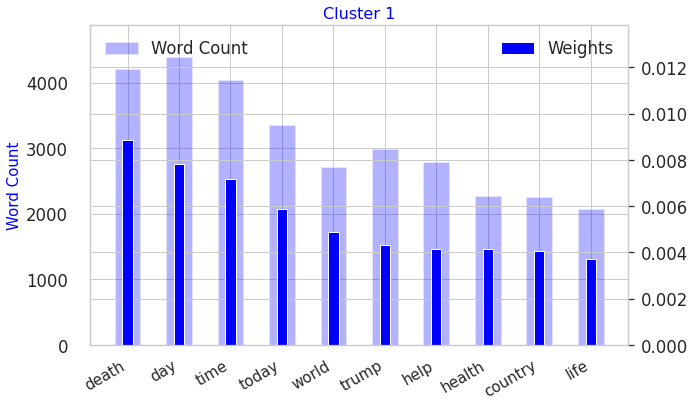

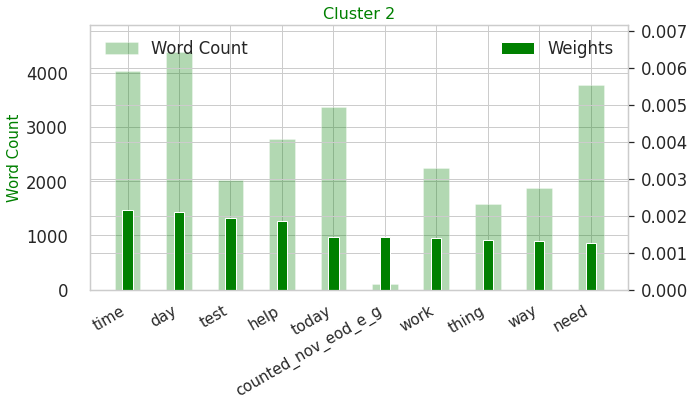

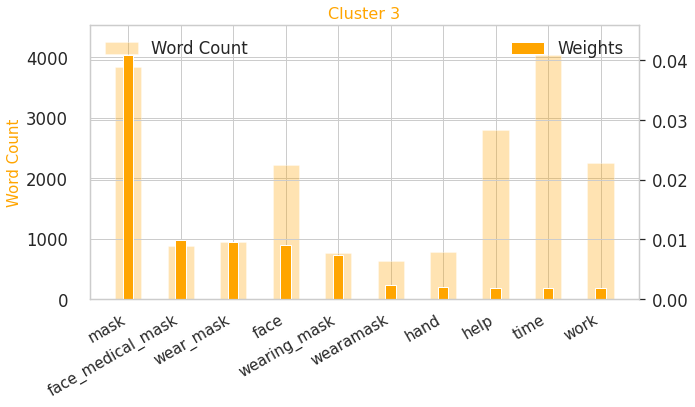

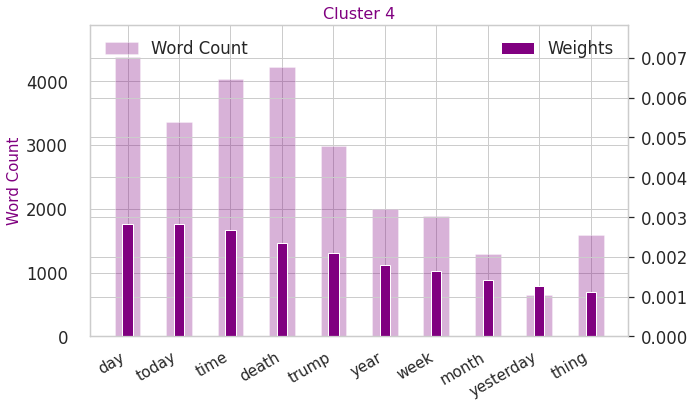

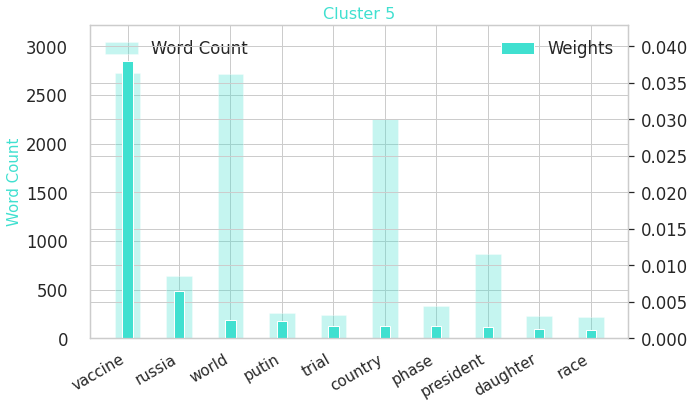

In [ ]:
# 6 Clusters
cluster_wordcount(lda_kmeans6)

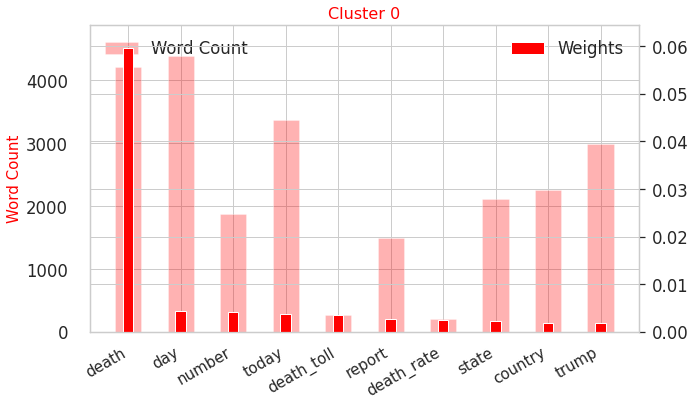

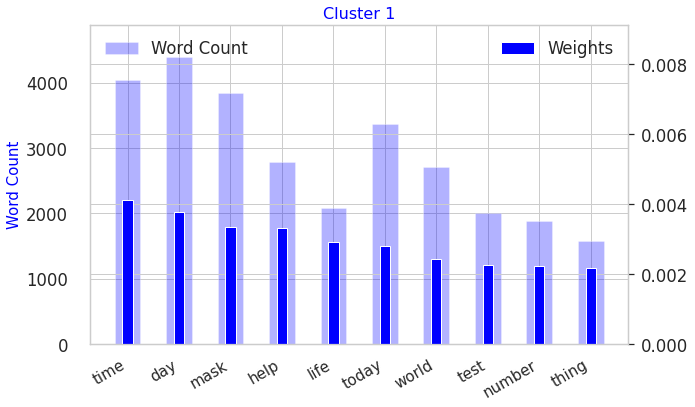

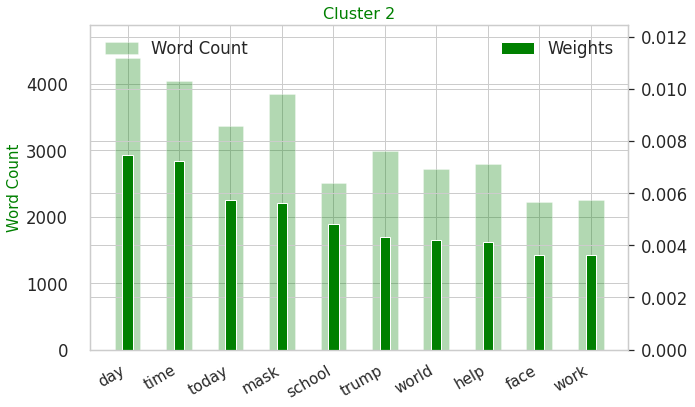

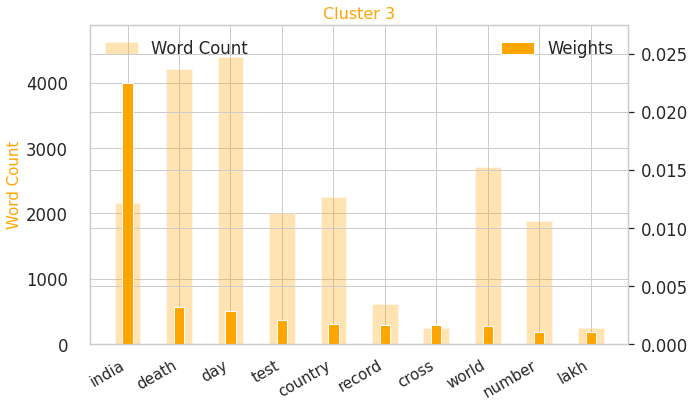

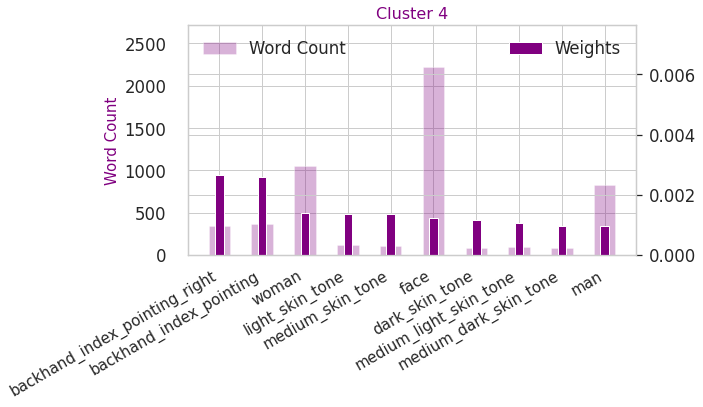

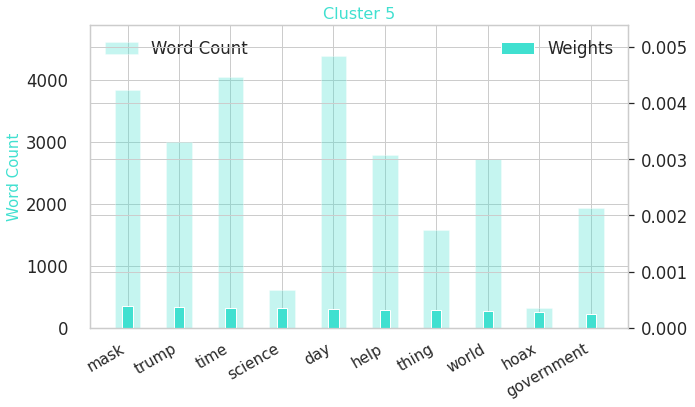

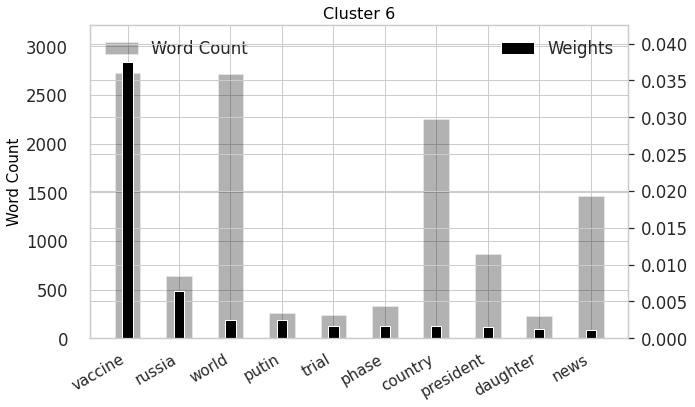

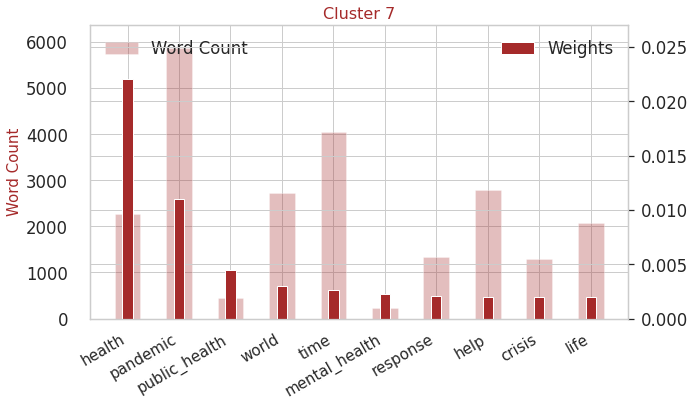

In [ ]:
# 8 Clusters
cluster_wordcount(lda_kmeans8)

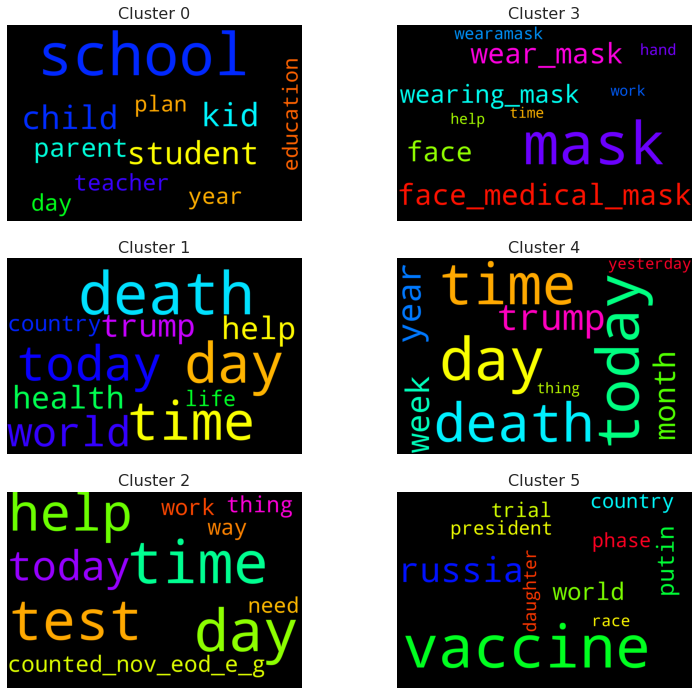

In [ ]:
# 6 clusters
cluster_wordcloud(lda_kmeans6)

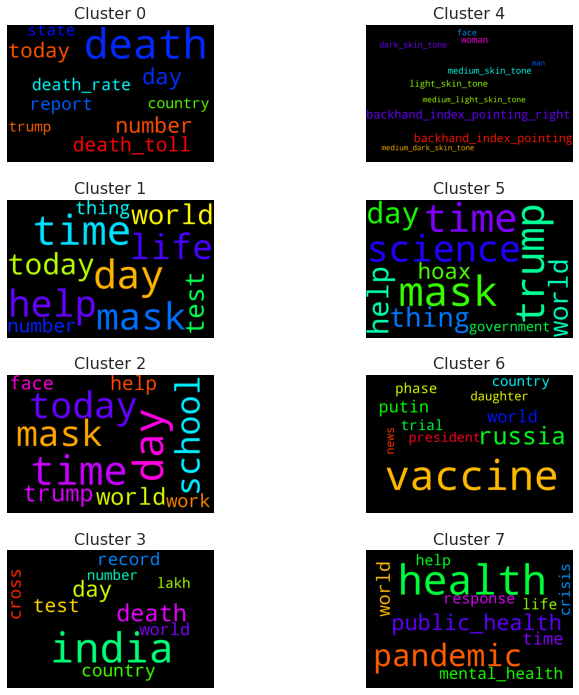

In [ ]:
# 8 clusters
cluster_wordcloud(lda_kmeans8)

**Focus on Cluster 4 with k = 8: EMOJI**

In [ ]:
df[['user_name','text']][df.cluster == 4].head(20)

user_name                                                                                                                                              text
89    The AssarV10 Team™©                      Four mayors reflect on their evolving response to the coronavirus pandemic https://t.co/TMqFfkPjcC  👈 click the lin… https://t.co/ZmqzTU7Nsv    
143   Lisa Murray                              100% feeling good and 0% some symptoms🙃 Long May it last 🤞🏻 #COVID19 🦠🤛🏻 https://t.co/37Dc8BweJO                                                
199   Austeiin 🔞                               If this is not AWESOMENESS, I don't know what is👇👇👇\n\n#BBNaijia2020 #RihannaXTiwa #alreadyvideo #COVID19 https://t.co/gUjp3t8OLd               
311   @NaniExperience                          Check us out on Spotify as well \n🙌🎶👑🔊🔥👇👇👇👇\nhttps://t.co/v2XKBfaTfj\n\n#GospelHouse 🎶👑🔊💯\n#GodGotThis ❤🙌🔥🔥🔥… https://t.co/oeIUQVc6gR           
371   Diana Mashni Awawdeh🇵🇸                   Please send prayers towards my family and I, we’re getting tested for covid 🥺🤲🏼🤍 #COVID19                                                       
604   The AssarV10 Team™©                      C.D.C. Calls On Schools to Reopen, Downplaying Coronavirus Risks https://t.co/7ElqAhk4p4  👈 click the link… https://t.co/3qDDuZWtYJ             
716   Sergio_Raguso 🌐                          🟠  Search &amp; Found  #COVID19 virus 🦠 with 🔍intelligent #tech in #SmartBuilding via @memoori 👇\n\n@OphelieJanus… https://t.co/AIEjEX9GbP      
780   Lockdown Lover                           Good old British common sense you must wear a mask in a shop but the staff won’t wear any !! 🤷🏻‍♂️ good old conside… https://t.co/tCFi52l4kq    
896   مهرة ✨                                   UAE has been always the icon of giving ✊🏻\nIt helped the whole world to fight #COVID19 with support packages which s… https://t.co/PRLrxGu8Un   
905   Tintswalo.cdk                            Who still remembers this advert from @ChickenLickenSA? @ChickenLickenSA 🤷🏽‍♀️😂😂 Is the funniest yet best  advert ma… https://t.co/jkVuw6W8cs    
925   Janice Brown                             #TheTrumpRegime #WhatTimeItIs?😒🤔👉🏾👌🏻👈🏾 They'd #BeBest, to #PackTheySh_t &amp; #GTFO, now!🤬#GOP think they gone #TearGas… https://t.co/XXb7gK2aYw
977   ♛ Asjad Khan ♛                           Big Breaking 👇\n#MadhyaPradesh CM #ShivrajSinghChouhan tests positive for #Covid19. He was the same man who once bla… https://t.co/3muR8uCEvC   
1045  Zanga Musakuzi                           #ZedTwitter would you want a free hand sanitizer\nDownload the medsearch zambia 👉📱app. And get location of the neare… https://t.co/LFMjEJa3qA   
1099  🧛‍♂️BIG GINGER NEXT🧛‍♂️                  I see that u follow the #Covid19 guideline👇🤦‍♀️🤦‍♀️ https://t.co/6DVNJQaFLh                                                                     
1107  The AssarV10 Team™©                      Anna Levine got her law degree at 62 and beat cancer twice. Then coronavirus took her https://t.co/rK1v0R67dT  👈 cl… https://t.co/Ciz4tBLBPJ    
1121  Carsten Finke                            New #MRI study by @ComaRecoveryLab shows microvascular lesions in 11/16 (69%) of patients with severe #COVID19 \n\n👉… https://t.co/OKDzZvGIy2   
1135  bluedarkArt                              😷 #Face #Masks 😷\n☆\n#designed by #BluedarkArt #TheChameleonArt\n☆\nAvailable in my #Shop 👉 https://t.co/aMkBNjKJ0B\n☆… https://t.co/7fPHjbBoJK 
1224  Lady Lawson of Galloway #BorisHasFailed  @bbclaurak In the spirit of sharing #COVID19 second wave learning👉https://t.co/y5jqRqdgfT. FYI: @BorisJohnson… https://t.co/INjWl6y84r          
1240  🍀🏴󠁧󠁢󠁳󠁣󠁴󠁿🐟Mick the Fish🐟🏴󠁧󠁢󠁳󠁣󠁴󠁿🍀          This is the best bit of #COVID19 advice about 👍🏻👍🏻 https://t.co/K5wBqAOuZJ                                                                      
1324  The AssarV10 Team™©                      Social Media Has Turned Bill Gates Into The Coronavirus Pandemic’s Fake Villain https://t.co/bHuCfuMoCj  👈 click th… https://t.co/YyPI4T41zR